In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
# Installing the requirements
print('Installing Requirements... ',end='')
%pip install lightning
%pip install wandb
print('Done')

Installing Requirements... Requirement already satisfied: lightning in /system/conda/miniconda3/envs/cloudspace/lib/python3.10/site-packages (2.2.0.post0)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Done


In [11]:
# Importing Libraries
print('Importing Libraries... ',end='')
import os
from pathlib import Path
import pandas as pd
import torchaudio
import zipfile
from torchaudio.transforms import Resample
import IPython.display as ipd
from matplotlib import pyplot as plt
from tqdm import tqdm
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import torch
from statistics import mean, median
print('Done')

Importing Libraries... Done


In [12]:
# # Extract data
# with zipfile.ZipFile("/content/drive/MyDrive/Archive.zip", 'r') as zip_ref:
#     zip_ref.extractall("/content/")

In [13]:
# # Loading dataset
# path = Path('/content/')
# df = pd.read_csv('/content/meta/esc50.csv')

In [14]:
# Loading dataset
path = Path('/teamspace/studios/this_studio/assign1')
df = pd.read_csv('/teamspace/studios/this_studio/assign1/meta/esc50.csv')

Shape of waveform: torch.Size([1, 220500])
Sample rate of waveform: 44100


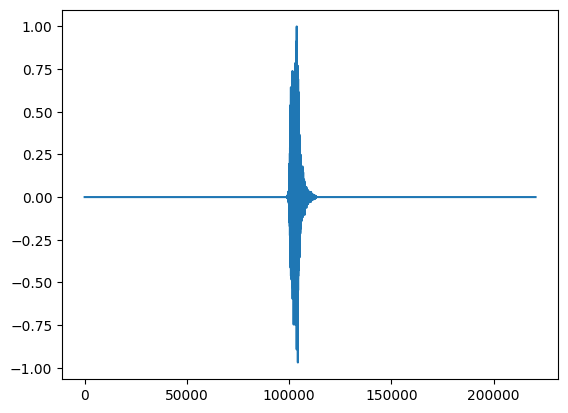

In [15]:
# Getting list of raw audio files
wavs = list(path.glob('audio/*'))  # List all audio files in the 'audio' directory using pathlib.Path.glob

# Visualizing data
waveform, sample_rate = torchaudio.load(str(wavs[0])) # Load the waveform and sample rate of the first audio file using torchaudio

print("Shape of waveform: {}".format(waveform.size()))  # Print the shape of the waveform tensor
print("Sample rate of waveform: {}".format(sample_rate))  # Print the sample rate of the audio file

# Plot the waveform using matplotlib
plt.figure()
plt.plot(waveform.t().numpy())  # Transpose and convert the waveform tensor to a NumPy array for plotting

# Display the audio using IPython.display.Audio
ipd.Audio(waveform, rate=sample_rate)  # Create an interactive audio player for the loaded waveform


In [16]:
class CustomDataset(Dataset):
    def __init__(self, dataset, **kwargs):
        # Initialize CustomDataset object with relevant parameters
        # dataset: "train", "val", or "test"
        # kwargs: Additional parameters like data directory, dataframe, folds, etc.

        # Extract parameters from kwargs
        self.data_directory = kwargs["data_directory"]
        self.data_frame = kwargs["data_frame"]
        self.validation_fold = kwargs["validation_fold"]
        self.testing_fold = kwargs["testing_fold"]
        self.esc_10_flag = kwargs["esc_10_flag"]
        self.file_column = kwargs["file_column"]
        self.label_column = kwargs["label_column"]
        self.sampling_rate = kwargs["sampling_rate"]
        self.new_sampling_rate = kwargs["new_sampling_rate"]
        self.sample_length_seconds = kwargs["sample_length_seconds"]

        # Filter dataframe based on esc_10_flag and data_type
        if self.esc_10_flag:
            self.data_frame = self.data_frame.loc[self.data_frame['esc10'] == True]

        if dataset == "train":
            self.data_frame = self.data_frame.loc[
                (self.data_frame['fold'] != self.validation_fold) & (self.data_frame['fold'] != self.testing_fold)]
        elif dataset == "val":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.validation_fold]
        elif dataset == "test":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.testing_fold]

        # Get unique categories from the filtered dataframe
        self.categories = sorted(self.data_frame[self.label_column].unique())

        # Initialize lists to hold file names, labels, and folder numbers
        self.file_names = []
        self.labels = []

        # Initialize dictionaries for category-to-index and index-to-category mapping
        self.category_to_index = {}
        self.index_to_category = {}

        for i, category in enumerate(self.categories):
            self.category_to_index[category] = i
            self.index_to_category[i] = category

        # Populate file names and labels lists by iterating through the dataframe
        for ind in tqdm(range(len(self.data_frame))):
            row = self.data_frame.iloc[ind]
            file_path = self.data_directory / "audio" / row[self.file_column]
            self.file_names.append(file_path)
            self.labels.append(self.category_to_index[row[self.label_column]])

        self.resampler = torchaudio.transforms.Resample(self.sampling_rate, self.new_sampling_rate)

        # Window size for rolling window sample splits (unfold method)
        if self.sample_length_seconds == 2:
            self.window_size = self.new_sampling_rate * 2
            self.step_size = int(self.new_sampling_rate * 0.75)
        else:
            self.window_size = self.new_sampling_rate
            self.step_size = int(self.new_sampling_rate * 0.5)

    def __getitem__(self, index):
        # Split audio files with overlap, pass as stacked tensors tensor with a single label
        path = self.file_names[index]
        audio_file = torchaudio.load(str(path), format=None, normalize=True)
        audio_tensor = self.resampler(audio_file[0])
        splits = audio_tensor.unfold(1, self.window_size, self.step_size)
        samples = splits.permute(1, 0, 2)
        return samples, self.labels[index]

    def __len__(self):
        return len(self.file_names)


In [17]:
class CustomDataModule(pl.LightningDataModule):
    def __init__(self, **kwargs):
        # Initialize the CustomDataModule with batch size, number of workers, and other parameters
        super().__init__()
        self.batch_size = kwargs["batch_size"]
        self.num_workers = kwargs["num_workers"]
        self.data_module_kwargs = kwargs

    def setup(self, stage=None):
        # Define datasets for training, validation, and testing during Lightning setup

        # If in 'fit' or None stage, create training and validation datasets
        if stage == 'fit' or stage is None:
            self.training_dataset = CustomDataset(dataset="train", **self.data_module_kwargs)
            self.validation_dataset = CustomDataset(dataset="val", **self.data_module_kwargs)

        # If in 'test' or None stage, create testing dataset
        if stage == 'test' or stage is None:
            self.testing_dataset = CustomDataset(dataset="test", **self.data_module_kwargs)

    def train_dataloader(self):
        # Return DataLoader for training dataset
        return DataLoader(self.training_dataset,
                          batch_size=self.batch_size,
                          shuffle=True,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        # Return DataLoader for validation dataset
        return DataLoader(self.validation_dataset,
                          batch_size=self.batch_size,
                          shuffle=False,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        # Return DataLoader for testing dataset
        return DataLoader(self.testing_dataset,
                          batch_size=32,
                          shuffle=False,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def collate_function(self, data):
        """
        Collate function to process a batch of examples and labels.

        Args:
            data: a tuple of 2 tuples with (example, label) where
                example are the split 1 second sub-frame audio tensors per file
                label = the label

        Returns:
            A list containing examples (concatenated tensors) and labels (flattened tensor).
        """
        examples, labels = zip(*data)
        # examples = torch.cat(examples)
        examples = torch.stack(examples)
        examples = examples.reshape(examples.size(0),1,-1)
        labels = torch.flatten(torch.tensor(labels))

        return [examples, labels]


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve
import wandb

import torchvision
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [20]:
class Architecture1(nn.Module):
    def __init__(self):
        super(Architecture1, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(16)  # BatchNorm1d after first conv layer
        self.conv2 = nn.Conv1d(16, 8, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm1d(8)  # BatchNorm1d after second conv layer

        self.dropout1 = nn.Dropout(p=0.2)  # Dropout after maxpooling

        self.conv3 = nn.Conv1d(8, 4, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(4)  # BatchNorm1d after third conv layer
        self.conv4 = nn.Conv1d(4, 2, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(2)

        # self.dropout2 = nn.Dropout(p=0.2)  # Dropout after maxpooling

        # self.conv5 = nn.Conv1d(2, 1, kernel_size=3, stride=1, padding=1)
        # self.bn5 = nn.BatchNorm1d(1)
        self.fc1 = nn.Linear(1124, 10)
        # self.fc2 = nn.Linear(600, 10)
        # self.fc3 = nn.Linear(2250, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool1d(F.relu(self.bn2(self.conv2(x))), 8)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool1d(F.relu(self.bn4(self.conv4(x))), 8)
        # x = self.dropout2(x)

        # x = F.max_pool1d(F.relu(self.bn5(self.conv5(x))), 8)
        x = x.view(x.size(0), -1)
        # x = F.relu(self.fc1(x))  # Add ReLU after fc1
        # x = F.relu(self.fc2(x))  # Add ReLU after fc2
        x = F.softmax(self.fc1(x), dim=1)  # Apply softmax on final layer
        return x

In [21]:
learning_rates = [0.001, 0.05]
optimizers = ['Adam', 'SGD']

In [22]:
#Model1

100%|██████████| 80/80 [00:00<00:00, 17351.55it/s]
wandb: Currently logged in as: m23csa014. Use `wandb login --relogin` to force relogin


Adam, 0.001 lr, 2 fold, Epoch 10/100, Training Loss: 1.9593105465173721, Training Accuracy: 55.416666666666664
Adam, 0.001 lr, 2 fold, Epoch 10/100, Validation Loss: 2.0693722565968833, Validation Accuracy: 42.5
Adam, 0.001 lr, 2 fold, Epoch 20/100, Training Loss: 1.8034572899341583, Training Accuracy: 70.83333333333333
Adam, 0.001 lr, 2 fold, Epoch 20/100, Validation Loss: 2.008262356122335, Validation Accuracy: 45.0
Adam, 0.001 lr, 2 fold, Epoch 30/100, Training Loss: 1.7485388070344925, Training Accuracy: 73.33333333333333
Adam, 0.001 lr, 2 fold, Epoch 30/100, Validation Loss: 2.0253506898880005, Validation Accuracy: 41.25
Adam, 0.001 lr, 2 fold, Epoch 40/100, Training Loss: 1.703494355082512, Training Accuracy: 80.41666666666667
Adam, 0.001 lr, 2 fold, Epoch 40/100, Validation Loss: 2.0331137975056968, Validation Accuracy: 41.25
Adam, 0.001 lr, 2 fold, Epoch 50/100, Training Loss: 1.6328728944063187, Training Accuracy: 85.83333333333333
Adam, 0.001 lr, 2 fold, Epoch 50/100, Validat

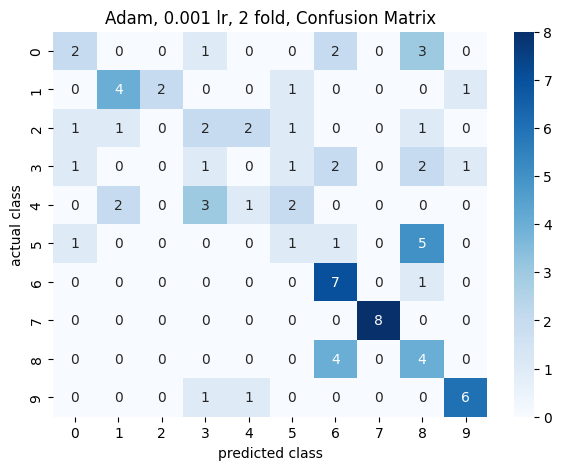

Adam, 0.001 lr, 2 fold, Overall F1 Score: 0.39422161172161174


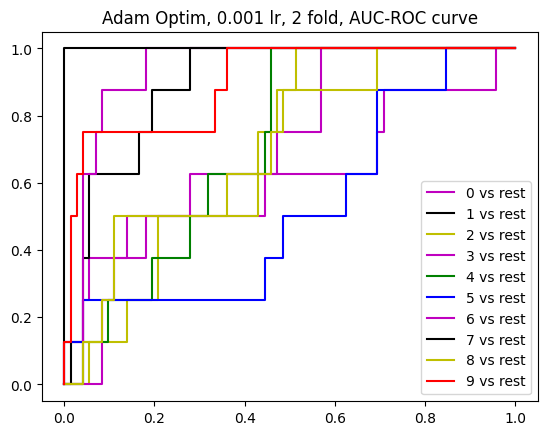

100%|██████████| 80/80 [00:00<00:00, 16087.08it/s]


Adam, 0.001 lr, 3 fold, Epoch 10/100, Training Loss: 1.9428301602602005, Training Accuracy: 54.166666666666664
Adam, 0.001 lr, 3 fold, Epoch 10/100, Validation Loss: 2.14860463142395, Validation Accuracy: 36.25
Adam, 0.001 lr, 3 fold, Epoch 20/100, Training Loss: 1.8575818240642548, Training Accuracy: 62.916666666666664
Adam, 0.001 lr, 3 fold, Epoch 20/100, Validation Loss: 2.135758717854818, Validation Accuracy: 36.25
Adam, 0.001 lr, 3 fold, Epoch 30/100, Training Loss: 1.8310029357671738, Training Accuracy: 63.75
Adam, 0.001 lr, 3 fold, Epoch 30/100, Validation Loss: 2.1361141999562583, Validation Accuracy: 35.0
Adam, 0.001 lr, 3 fold, Epoch 40/100, Training Loss: 1.8034326136112213, Training Accuracy: 65.41666666666667
Adam, 0.001 lr, 3 fold, Epoch 40/100, Validation Loss: 2.148761510848999, Validation Accuracy: 33.75
Adam, 0.001 lr, 3 fold, Epoch 50/100, Training Loss: 1.7849731147289276, Training Accuracy: 67.91666666666667
Adam, 0.001 lr, 3 fold, Epoch 50/100, Validation Loss: 2.

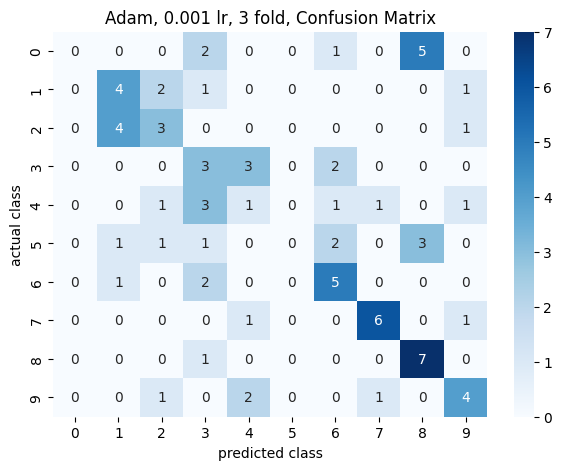

Adam, 0.001 lr, 3 fold, Overall F1 Score: 0.3623503505139661


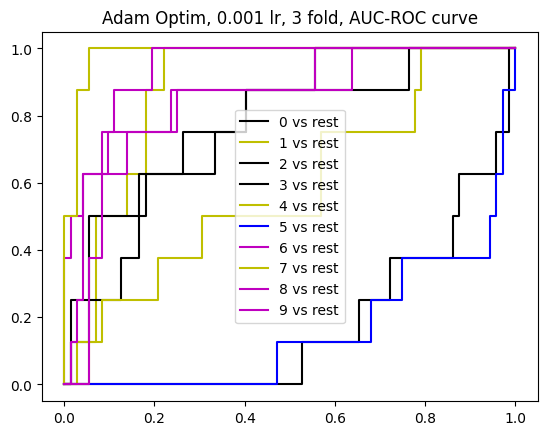

100%|██████████| 80/80 [00:00<00:00, 12927.43it/s]


Adam, 0.001 lr, 4 fold, Epoch 10/100, Training Loss: 1.982459932565689, Training Accuracy: 51.666666666666664
Adam, 0.001 lr, 4 fold, Epoch 10/100, Validation Loss: 2.1642632484436035, Validation Accuracy: 30.0
Adam, 0.001 lr, 4 fold, Epoch 20/100, Training Loss: 1.8885299265384674, Training Accuracy: 59.583333333333336
Adam, 0.001 lr, 4 fold, Epoch 20/100, Validation Loss: 2.142326513926188, Validation Accuracy: 36.25
Adam, 0.001 lr, 4 fold, Epoch 30/100, Training Loss: 1.8590671867132187, Training Accuracy: 62.083333333333336
Adam, 0.001 lr, 4 fold, Epoch 30/100, Validation Loss: 2.100554625193278, Validation Accuracy: 41.25
Adam, 0.001 lr, 4 fold, Epoch 40/100, Training Loss: 1.8335976153612137, Training Accuracy: 63.75
Adam, 0.001 lr, 4 fold, Epoch 40/100, Validation Loss: 2.1062564849853516, Validation Accuracy: 37.5
Adam, 0.001 lr, 4 fold, Epoch 50/100, Training Loss: 1.808236986398697, Training Accuracy: 65.83333333333333
Adam, 0.001 lr, 4 fold, Epoch 50/100, Validation Loss: 2.

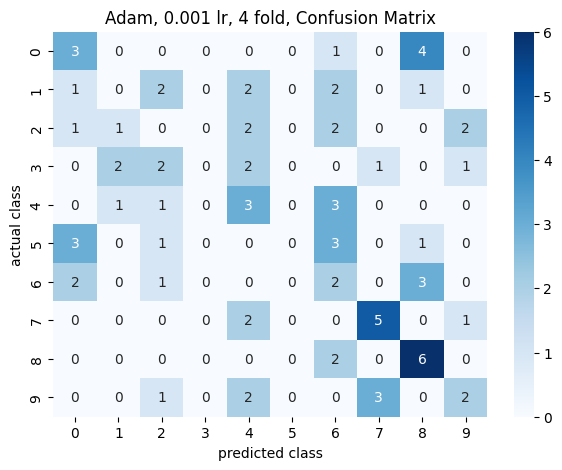

Adam, 0.001 lr, 4 fold, Overall F1 Score: 0.21886493727925954


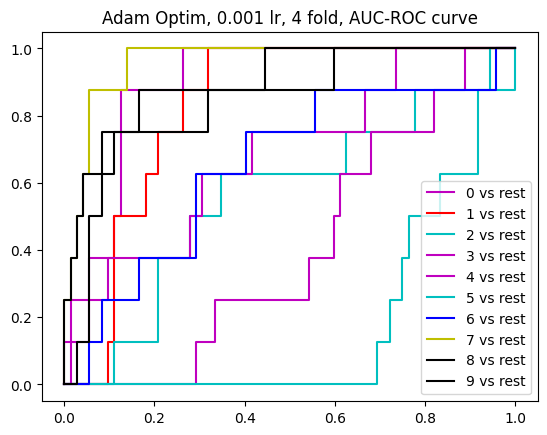

100%|██████████| 80/80 [00:00<00:00, 17678.84it/s]


Adam, 0.001 lr, 5 fold, Epoch 10/100, Training Loss: 1.911416694521904, Training Accuracy: 63.75
Adam, 0.001 lr, 5 fold, Epoch 10/100, Validation Loss: 2.163585583368937, Validation Accuracy: 27.5
Adam, 0.001 lr, 5 fold, Epoch 20/100, Training Loss: 1.755775809288025, Training Accuracy: 73.75
Adam, 0.001 lr, 5 fold, Epoch 20/100, Validation Loss: 2.1954967180887857, Validation Accuracy: 28.75
Adam, 0.001 lr, 5 fold, Epoch 30/100, Training Loss: 1.7159669250249863, Training Accuracy: 77.5
Adam, 0.001 lr, 5 fold, Epoch 30/100, Validation Loss: 2.118190288543701, Validation Accuracy: 35.0
Adam, 0.001 lr, 5 fold, Epoch 40/100, Training Loss: 1.6845023781061172, Training Accuracy: 80.41666666666667
Adam, 0.001 lr, 5 fold, Epoch 40/100, Validation Loss: 2.165913979212443, Validation Accuracy: 27.5
Adam, 0.001 lr, 5 fold, Epoch 50/100, Training Loss: 1.6659831404685974, Training Accuracy: 79.58333333333333
Adam, 0.001 lr, 5 fold, Epoch 50/100, Validation Loss: 2.127038319905599, Validation Ac

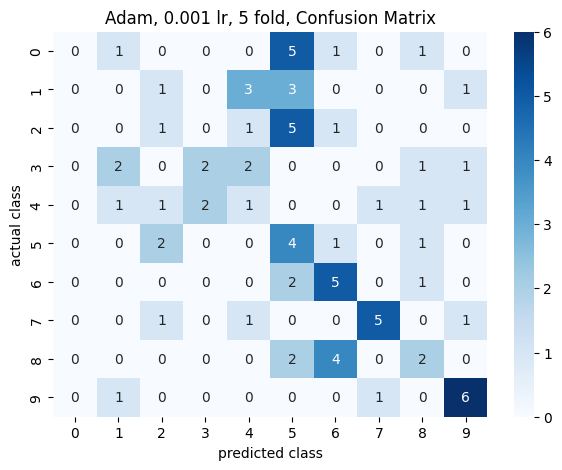

Adam, 0.001 lr, 5 fold, Overall F1 Score: 0.2977052545155993


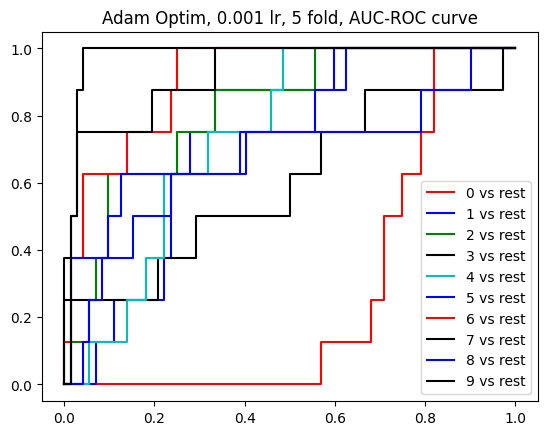

Adam, 0.001 lr, Mean validation accuracy: 35.0
Adam, 0.001 lr, Best test accuracy: 42.5


100%|██████████| 80/80 [00:00<00:00, 17606.48it/s]


Adam, 0.05 lr, 2 fold, Epoch 10/100, Training Loss: 2.3595883548259735, Training Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 10/100, Validation Loss: 2.367400805155436, Validation Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 20/100, Training Loss: 2.3595883548259735, Training Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 20/100, Validation Loss: 2.367400805155436, Validation Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 30/100, Training Loss: 2.3634946048259735, Training Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 30/100, Validation Loss: 2.367400805155436, Validation Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 40/100, Training Loss: 2.3556821048259735, Training Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 40/100, Validation Loss: 2.367400805155436, Validation Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 50/100, Training Loss: 2.3556821048259735, Training Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 50/100, Validation Loss: 2.367400805155436, Validation Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Ep

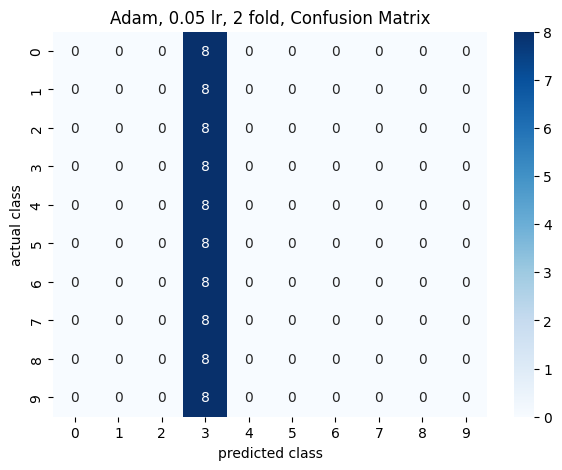

Adam, 0.05 lr, 2 fold, Overall F1 Score: 0.01818181818181818


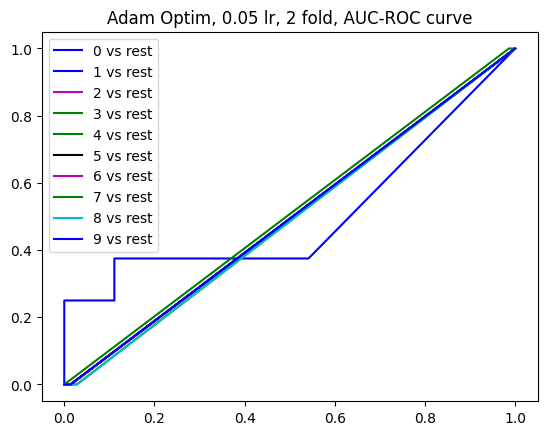

100%|██████████| 80/80 [00:00<00:00, 17588.95it/s]


Adam, 0.05 lr, 3 fold, Epoch 10/100, Training Loss: 2.3517758548259735, Training Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 10/100, Validation Loss: 2.367400805155436, Validation Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 20/100, Training Loss: 2.3634946048259735, Training Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 20/100, Validation Loss: 2.367400805155436, Validation Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 30/100, Training Loss: 2.3634946048259735, Training Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 30/100, Validation Loss: 2.367400805155436, Validation Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 40/100, Training Loss: 2.3517758548259735, Training Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 40/100, Validation Loss: 2.367400805155436, Validation Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 50/100, Training Loss: 2.3634946048259735, Training Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 50/100, Validation Loss: 2.367400805155436, Validation Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Ep

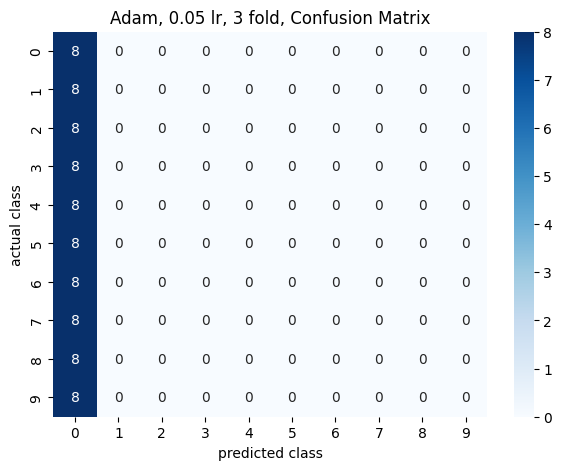

Adam, 0.05 lr, 3 fold, Overall F1 Score: 0.01818181818181818


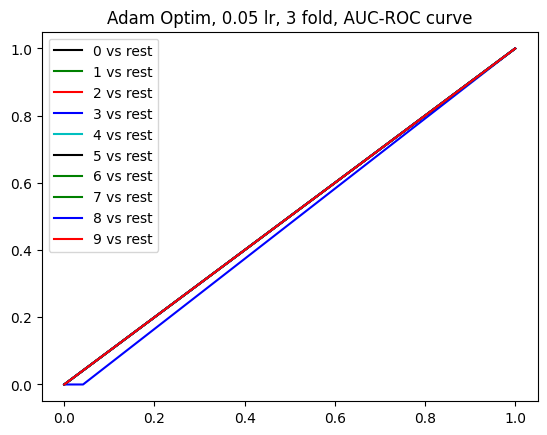

100%|██████████| 80/80 [00:00<00:00, 16683.79it/s]


Adam, 0.05 lr, 4 fold, Epoch 10/100, Training Loss: 2.089528664946556, Training Accuracy: 38.333333333333336
Adam, 0.05 lr, 4 fold, Epoch 10/100, Validation Loss: 2.2277936935424805, Validation Accuracy: 23.75
Adam, 0.05 lr, 4 fold, Epoch 20/100, Training Loss: 2.0676837116479874, Training Accuracy: 40.0
Adam, 0.05 lr, 4 fold, Epoch 20/100, Validation Loss: 2.1591342290242515, Validation Accuracy: 31.25
Adam, 0.05 lr, 4 fold, Epoch 30/100, Training Loss: 1.9760878831148148, Training Accuracy: 50.0
Adam, 0.05 lr, 4 fold, Epoch 30/100, Validation Loss: 2.1713348229726157, Validation Accuracy: 28.75
Adam, 0.05 lr, 4 fold, Epoch 40/100, Training Loss: 1.9387897700071335, Training Accuracy: 51.666666666666664
Adam, 0.05 lr, 4 fold, Epoch 40/100, Validation Loss: 2.0976919333140054, Validation Accuracy: 36.25
Adam, 0.05 lr, 4 fold, Epoch 50/100, Training Loss: 1.955386534333229, Training Accuracy: 50.416666666666664
Adam, 0.05 lr, 4 fold, Epoch 50/100, Validation Loss: 2.147744576136271, Val

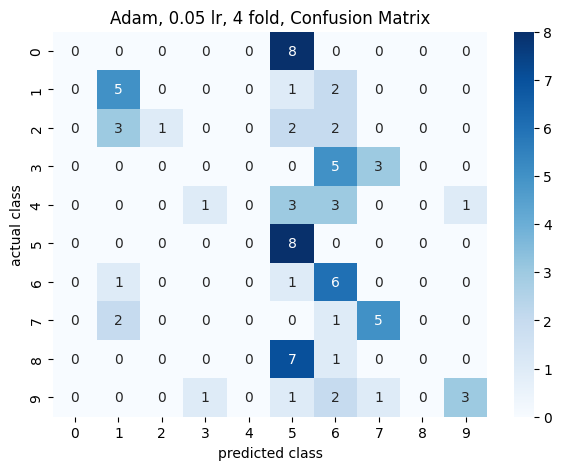

Adam, 0.05 lr, 4 fold, Overall F1 Score: 0.26470297160699635


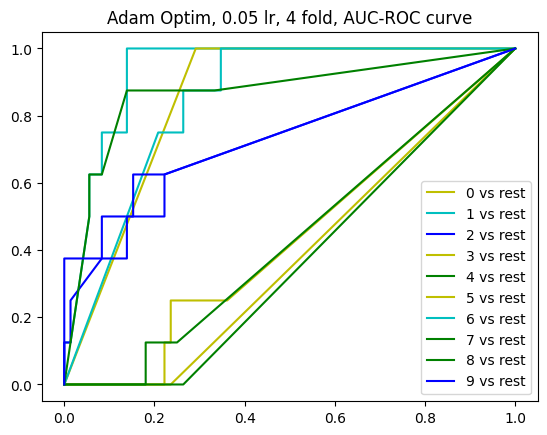

100%|██████████| 80/80 [00:00<00:00, 17212.70it/s]


Adam, 0.05 lr, 5 fold, Epoch 10/100, Training Loss: 2.3595883548259735, Training Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 10/100, Validation Loss: 2.3569841384887695, Validation Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 20/100, Training Loss: 2.3674008548259735, Training Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 20/100, Validation Loss: 2.3569841384887695, Validation Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 30/100, Training Loss: 2.3674008548259735, Training Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 30/100, Validation Loss: 2.3569841384887695, Validation Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 40/100, Training Loss: 2.3478696048259735, Training Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 40/100, Validation Loss: 2.3569841384887695, Validation Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 50/100, Training Loss: 2.3634946048259735, Training Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 50/100, Validation Loss: 2.3569841384887695, Validation Accuracy: 10.0
Adam, 0.05 lr, 5 fol

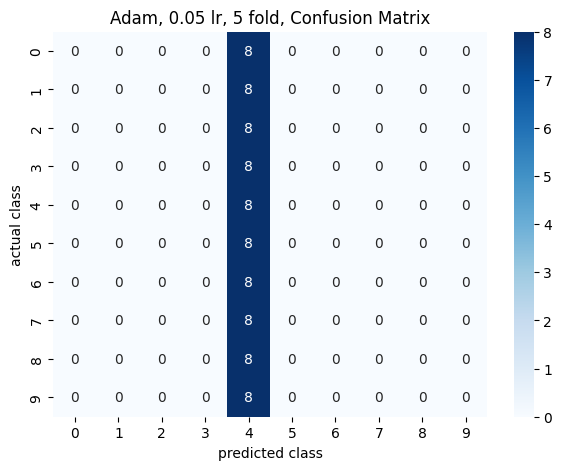

Adam, 0.05 lr, 5 fold, Overall F1 Score: 0.01818181818181818


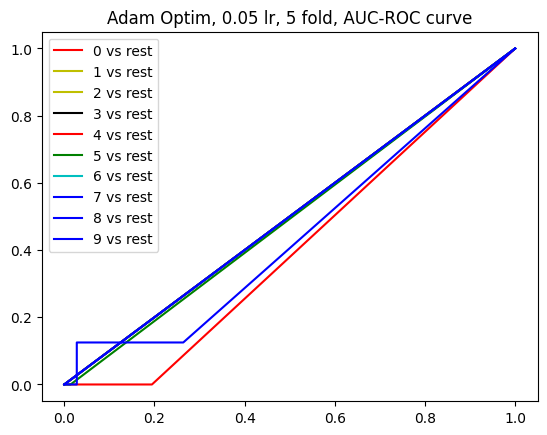

Adam, 0.05 lr, Mean validation accuracy: 15.9375
Adam, 0.05 lr, Best test accuracy: 35.0


100%|██████████| 80/80 [00:00<00:00, 16043.24it/s]


SGD, 0.001 lr, 2 fold, Epoch 10/100, Training Loss: 2.2859182953834534, Training Accuracy: 10.416666666666666
SGD, 0.001 lr, 2 fold, Epoch 10/100, Validation Loss: 2.2878917853037515, Validation Accuracy: 12.5
SGD, 0.001 lr, 2 fold, Epoch 20/100, Training Loss: 2.2727274000644684, Training Accuracy: 12.083333333333334
SGD, 0.001 lr, 2 fold, Epoch 20/100, Validation Loss: 2.273383061091105, Validation Accuracy: 17.5
SGD, 0.001 lr, 2 fold, Epoch 30/100, Training Loss: 2.26061749458313, Training Accuracy: 15.416666666666666
SGD, 0.001 lr, 2 fold, Epoch 30/100, Validation Loss: 2.264436721801758, Validation Accuracy: 17.5
SGD, 0.001 lr, 2 fold, Epoch 40/100, Training Loss: 2.2442122399806976, Training Accuracy: 16.666666666666668
SGD, 0.001 lr, 2 fold, Epoch 40/100, Validation Loss: 2.2560221354166665, Validation Accuracy: 18.75
SGD, 0.001 lr, 2 fold, Epoch 50/100, Training Loss: 2.2301427721977234, Training Accuracy: 20.0
SGD, 0.001 lr, 2 fold, Epoch 50/100, Validation Loss: 2.24790517489

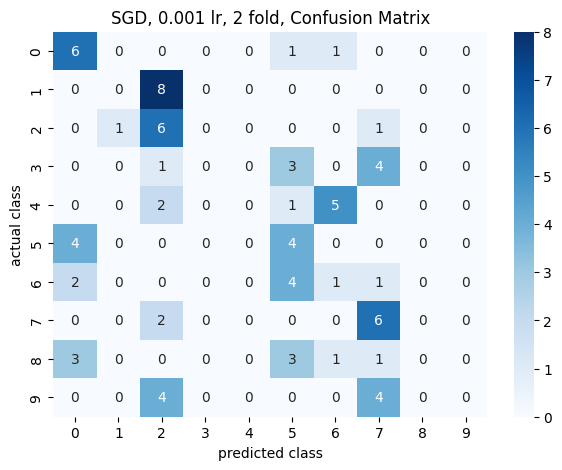

SGD, 0.001 lr, 2 fold, Overall F1 Score: 0.18471692379616642


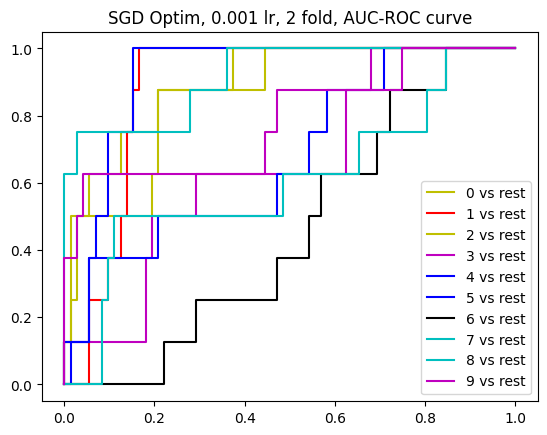

100%|██████████| 80/80 [00:00<00:00, 12090.38it/s]


SGD, 0.001 lr, 3 fold, Epoch 10/100, Training Loss: 2.2415169775485992, Training Accuracy: 20.416666666666668
SGD, 0.001 lr, 3 fold, Epoch 10/100, Validation Loss: 2.2860916455586753, Validation Accuracy: 16.25
SGD, 0.001 lr, 3 fold, Epoch 20/100, Training Loss: 2.2306263148784637, Training Accuracy: 22.083333333333332
SGD, 0.001 lr, 3 fold, Epoch 20/100, Validation Loss: 2.2811675866444907, Validation Accuracy: 18.75
SGD, 0.001 lr, 3 fold, Epoch 30/100, Training Loss: 2.205693304538727, Training Accuracy: 25.0
SGD, 0.001 lr, 3 fold, Epoch 30/100, Validation Loss: 2.2763001918792725, Validation Accuracy: 18.75
SGD, 0.001 lr, 3 fold, Epoch 40/100, Training Loss: 2.1893426179885864, Training Accuracy: 26.666666666666668
SGD, 0.001 lr, 3 fold, Epoch 40/100, Validation Loss: 2.2700209617614746, Validation Accuracy: 20.0
SGD, 0.001 lr, 3 fold, Epoch 50/100, Training Loss: 2.180127114057541, Training Accuracy: 27.083333333333332
SGD, 0.001 lr, 3 fold, Epoch 50/100, Validation Loss: 2.2645115

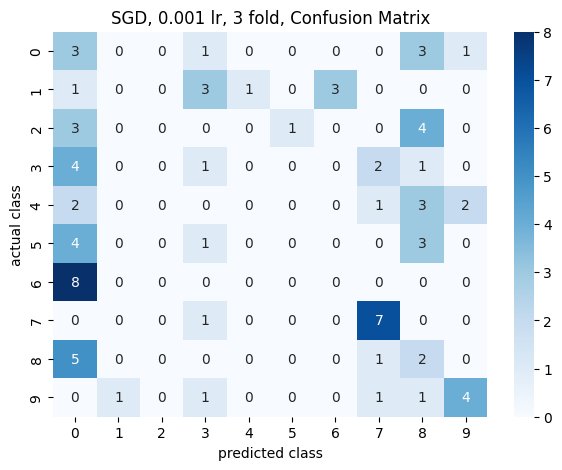

SGD, 0.001 lr, 3 fold, Overall F1 Score: 0.1676228070175439


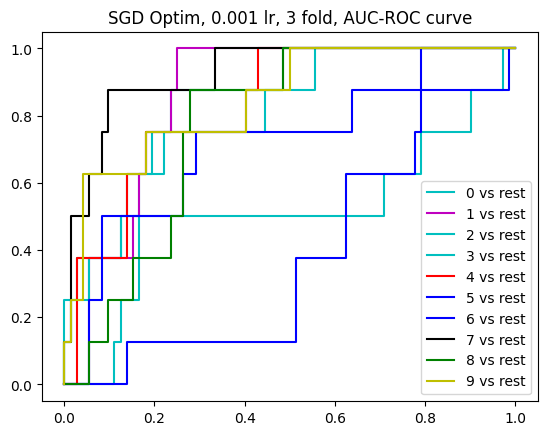

100%|██████████| 80/80 [00:00<00:00, 16002.69it/s]


SGD, 0.001 lr, 4 fold, Epoch 10/100, Training Loss: 2.289834886789322, Training Accuracy: 10.416666666666666
SGD, 0.001 lr, 4 fold, Epoch 10/100, Validation Loss: 2.2981321016947427, Validation Accuracy: 7.5
SGD, 0.001 lr, 4 fold, Epoch 20/100, Training Loss: 2.2596286833286285, Training Accuracy: 19.583333333333332
SGD, 0.001 lr, 4 fold, Epoch 20/100, Validation Loss: 2.2862143516540527, Validation Accuracy: 15.0
SGD, 0.001 lr, 4 fold, Epoch 30/100, Training Loss: 2.2366151809692383, Training Accuracy: 18.75
SGD, 0.001 lr, 4 fold, Epoch 30/100, Validation Loss: 2.2752456665039062, Validation Accuracy: 17.5
SGD, 0.001 lr, 4 fold, Epoch 40/100, Training Loss: 2.216978758573532, Training Accuracy: 30.416666666666668
SGD, 0.001 lr, 4 fold, Epoch 40/100, Validation Loss: 2.2690451939900718, Validation Accuracy: 28.75
SGD, 0.001 lr, 4 fold, Epoch 50/100, Training Loss: 2.205192506313324, Training Accuracy: 33.75
SGD, 0.001 lr, 4 fold, Epoch 50/100, Validation Loss: 2.264189084370931, Valida

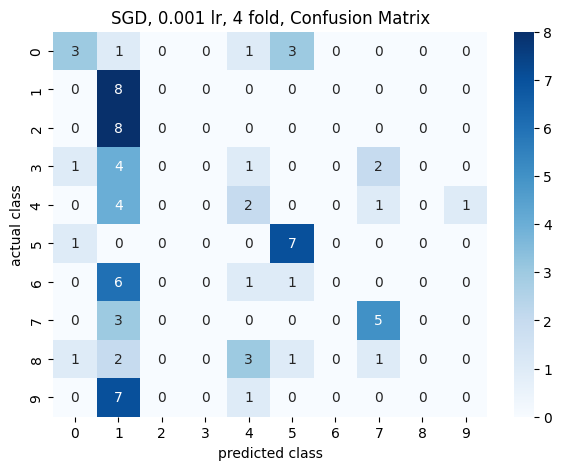

SGD, 0.001 lr, 4 fold, Overall F1 Score: 0.2265826330532213


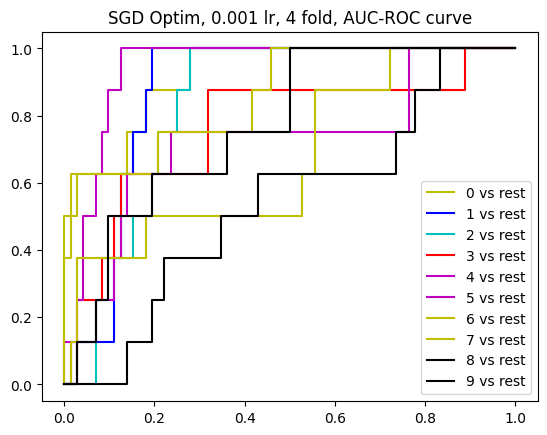

100%|██████████| 80/80 [00:00<00:00, 16169.25it/s]


SGD, 0.001 lr, 5 fold, Epoch 10/100, Training Loss: 2.269121527671814, Training Accuracy: 13.333333333333334
SGD, 0.001 lr, 5 fold, Epoch 10/100, Validation Loss: 2.278163035710653, Validation Accuracy: 12.5
SGD, 0.001 lr, 5 fold, Epoch 20/100, Training Loss: 2.2469635009765625, Training Accuracy: 17.916666666666668
SGD, 0.001 lr, 5 fold, Epoch 20/100, Validation Loss: 2.2555104891459146, Validation Accuracy: 13.75
SGD, 0.001 lr, 5 fold, Epoch 30/100, Training Loss: 2.2299008071422577, Training Accuracy: 20.0
SGD, 0.001 lr, 5 fold, Epoch 30/100, Validation Loss: 2.243441184361776, Validation Accuracy: 16.25
SGD, 0.001 lr, 5 fold, Epoch 40/100, Training Loss: 2.224314332008362, Training Accuracy: 21.666666666666668
SGD, 0.001 lr, 5 fold, Epoch 40/100, Validation Loss: 2.234780470530192, Validation Accuracy: 16.25
SGD, 0.001 lr, 5 fold, Epoch 50/100, Training Loss: 2.20824471116066, Training Accuracy: 22.916666666666668
SGD, 0.001 lr, 5 fold, Epoch 50/100, Validation Loss: 2.221913258234

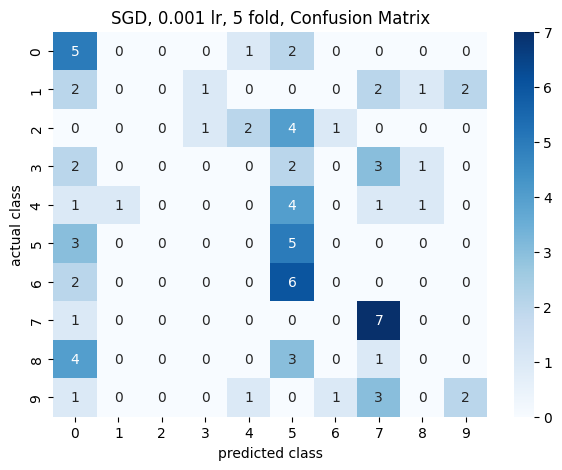

SGD, 0.001 lr, 5 fold, Overall F1 Score: 0.15322785665990535


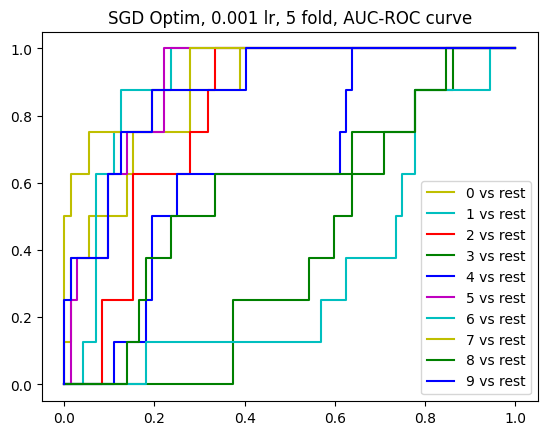

SGD, 0.001 lr, Mean validation accuracy: 27.8125
SGD, 0.001 lr, Best test accuracy: 31.25


100%|██████████| 80/80 [00:00<00:00, 17354.24it/s]


SGD, 0.05 lr, 2 fold, Epoch 10/100, Training Loss: 2.0421977937221527, Training Accuracy: 43.75
SGD, 0.05 lr, 2 fold, Epoch 10/100, Validation Loss: 2.106576919555664, Validation Accuracy: 32.5
SGD, 0.05 lr, 2 fold, Epoch 20/100, Training Loss: 1.9412646740674973, Training Accuracy: 55.833333333333336
SGD, 0.05 lr, 2 fold, Epoch 20/100, Validation Loss: 2.0890340010325112, Validation Accuracy: 40.0
SGD, 0.05 lr, 2 fold, Epoch 30/100, Training Loss: 1.8748679906129837, Training Accuracy: 65.83333333333333
SGD, 0.05 lr, 2 fold, Epoch 30/100, Validation Loss: 2.0709035793940225, Validation Accuracy: 35.0
SGD, 0.05 lr, 2 fold, Epoch 40/100, Training Loss: 1.7880127429962158, Training Accuracy: 67.91666666666667
SGD, 0.05 lr, 2 fold, Epoch 40/100, Validation Loss: 2.042069435119629, Validation Accuracy: 40.0
SGD, 0.05 lr, 2 fold, Epoch 50/100, Training Loss: 1.7724326401948929, Training Accuracy: 69.58333333333333
SGD, 0.05 lr, 2 fold, Epoch 50/100, Validation Loss: 2.017315705617269, Valid

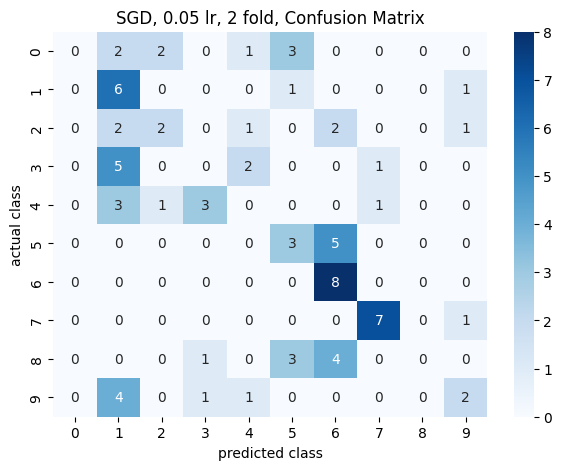

SGD, 0.05 lr, 2 fold, Overall F1 Score: 0.27648399530752477


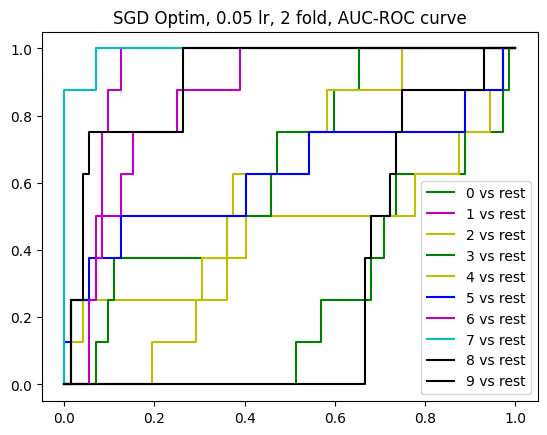

100%|██████████| 80/80 [00:00<00:00, 16131.16it/s]


SGD, 0.05 lr, 3 fold, Epoch 10/100, Training Loss: 1.9800141602754593, Training Accuracy: 48.75
SGD, 0.05 lr, 3 fold, Epoch 10/100, Validation Loss: 2.1308396657307944, Validation Accuracy: 31.25
SGD, 0.05 lr, 3 fold, Epoch 20/100, Training Loss: 1.900538131594658, Training Accuracy: 57.916666666666664
SGD, 0.05 lr, 3 fold, Epoch 20/100, Validation Loss: 2.096881866455078, Validation Accuracy: 37.5
SGD, 0.05 lr, 3 fold, Epoch 30/100, Training Loss: 1.8615818917751312, Training Accuracy: 62.083333333333336
SGD, 0.05 lr, 3 fold, Epoch 30/100, Validation Loss: 2.0825268427530923, Validation Accuracy: 36.25
SGD, 0.05 lr, 3 fold, Epoch 40/100, Training Loss: 1.8203766196966171, Training Accuracy: 64.58333333333333
SGD, 0.05 lr, 3 fold, Epoch 40/100, Validation Loss: 2.1120998859405518, Validation Accuracy: 32.5
SGD, 0.05 lr, 3 fold, Epoch 50/100, Training Loss: 1.6768340170383453, Training Accuracy: 78.75
SGD, 0.05 lr, 3 fold, Epoch 50/100, Validation Loss: 2.099029858907064, Validation Acc

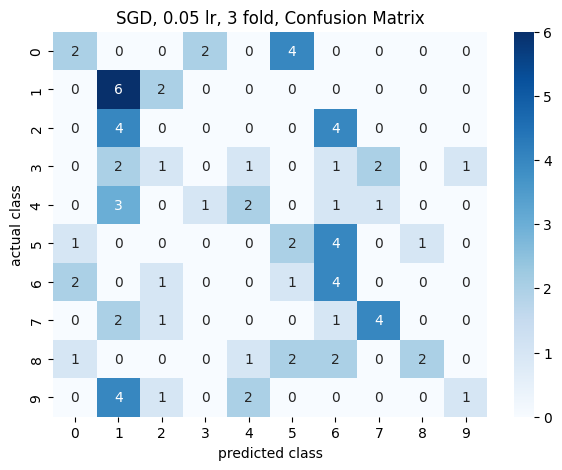

SGD, 0.05 lr, 3 fold, Overall F1 Score: 0.26374854894936034


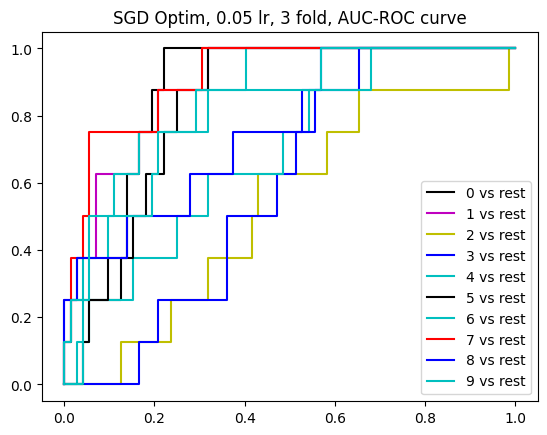

100%|██████████| 80/80 [00:00<00:00, 17226.84it/s]


SGD, 0.05 lr, 4 fold, Epoch 10/100, Training Loss: 2.0571791231632233, Training Accuracy: 42.5
SGD, 0.05 lr, 4 fold, Epoch 10/100, Validation Loss: 2.146334091822306, Validation Accuracy: 37.5
SGD, 0.05 lr, 4 fold, Epoch 20/100, Training Loss: 1.9183163344860077, Training Accuracy: 54.583333333333336
SGD, 0.05 lr, 4 fold, Epoch 20/100, Validation Loss: 2.119901974995931, Validation Accuracy: 40.0
SGD, 0.05 lr, 4 fold, Epoch 30/100, Training Loss: 1.85994291305542, Training Accuracy: 63.75
SGD, 0.05 lr, 4 fold, Epoch 30/100, Validation Loss: 2.1216960748036704, Validation Accuracy: 43.75
SGD, 0.05 lr, 4 fold, Epoch 40/100, Training Loss: 1.8127711564302444, Training Accuracy: 71.66666666666667
SGD, 0.05 lr, 4 fold, Epoch 40/100, Validation Loss: 2.1266488234202066, Validation Accuracy: 37.5
SGD, 0.05 lr, 4 fold, Epoch 50/100, Training Loss: 1.7503668069839478, Training Accuracy: 76.66666666666667
SGD, 0.05 lr, 4 fold, Epoch 50/100, Validation Loss: 2.1173245906829834, Validation Accurac

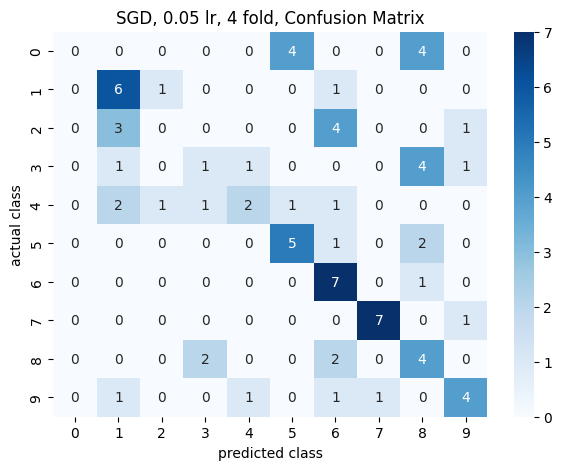

SGD, 0.05 lr, 4 fold, Overall F1 Score: 0.39431435472739823


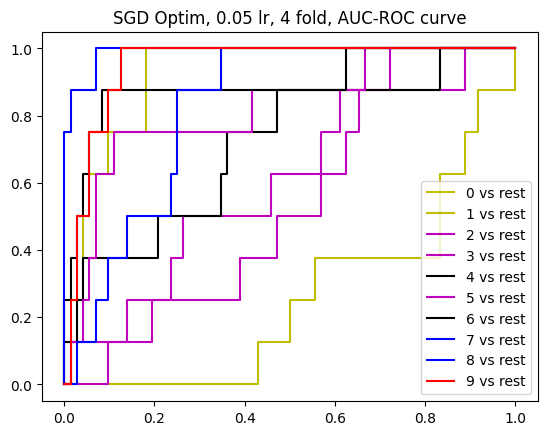

100%|██████████| 80/80 [00:00<00:00, 17229.49it/s]


SGD, 0.05 lr, 5 fold, Epoch 10/100, Training Loss: 2.0159001499414444, Training Accuracy: 47.5
SGD, 0.05 lr, 5 fold, Epoch 10/100, Validation Loss: 2.1240878899892173, Validation Accuracy: 35.0
SGD, 0.05 lr, 5 fold, Epoch 20/100, Training Loss: 1.9032278954982758, Training Accuracy: 59.583333333333336
SGD, 0.05 lr, 5 fold, Epoch 20/100, Validation Loss: 2.075419028600057, Validation Accuracy: 43.75
SGD, 0.05 lr, 5 fold, Epoch 30/100, Training Loss: 1.8707816749811172, Training Accuracy: 62.083333333333336
SGD, 0.05 lr, 5 fold, Epoch 30/100, Validation Loss: 2.1285568873087564, Validation Accuracy: 33.75
SGD, 0.05 lr, 5 fold, Epoch 40/100, Training Loss: 1.8032134771347046, Training Accuracy: 67.5
SGD, 0.05 lr, 5 fold, Epoch 40/100, Validation Loss: 2.0811293919881186, Validation Accuracy: 43.75
SGD, 0.05 lr, 5 fold, Epoch 50/100, Training Loss: 1.80435112118721, Training Accuracy: 66.66666666666667
SGD, 0.05 lr, 5 fold, Epoch 50/100, Validation Loss: 2.0683790842692056, Validation Accu

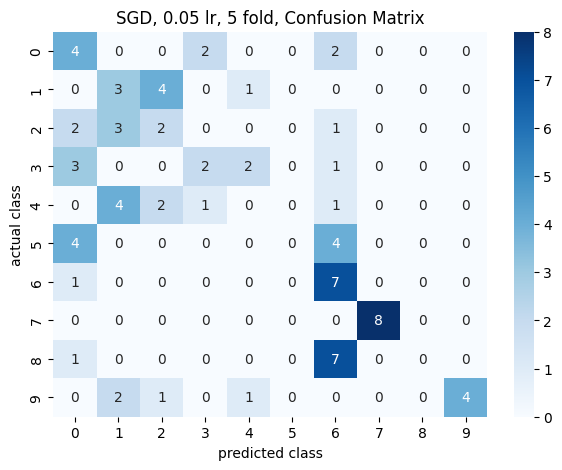

SGD, 0.05 lr, 5 fold, Overall F1 Score: 0.3309092082188361


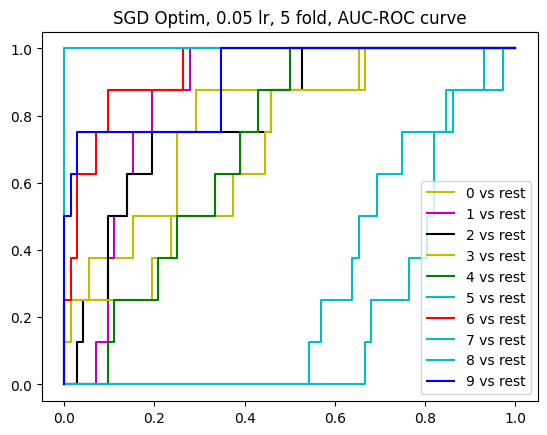

SGD, 0.05 lr, Mean validation accuracy: 40.0
SGD, 0.05 lr, Best test accuracy: 45.0


In [23]:
for optimizer_type in optimizers:
    for lr_type in learning_rates:

        all_test_accuracy = []
        all_validation_accuracy = []
        valid_samples = [2,3,4,5]

        for i in valid_samples:
            # Data Setup
            test_samp = 1 #Do not change this!!
            valid_samp = i # Use any value ranging from 2 to 5 for k-fold validation (valid_fold)
            batch_size = 32 # Free to change
            num_workers = 2 # Free to change
            custom_data_module = CustomDataModule(batch_size=batch_size,
                                                num_workers=num_workers,
                                                data_directory=path,
                                                data_frame=df,
                                                validation_fold=valid_samp,
                                                testing_fold=test_samp,  # set to 0 for no test set
                                                esc_10_flag=True,
                                                file_column='filename',
                                                label_column='category',
                                                sampling_rate=44100,
                                                new_sampling_rate=16000,  # new sample rate for input
                                                sample_length_seconds=1  # new length of input in seconds
                                                )

            custom_data_module.setup()

            # Hyperparameters
            num_classes = 10
            lr = lr_type
            epochs = 100
            # Model, Optimizer, Loss function
            model1 = Architecture1().to(device)
            # model2 = Architecture2()
            # optimizer = optim.Adam(model1.parameters(), lr=lr)
            if optimizer_type == 'Adam':
                optimizer = optim.Adam(model1.parameters(), lr=lr)
            elif optimizer_type == 'SGD':
                optimizer = optim.SGD(model1.parameters(), lr=lr)

            criterion = nn.CrossEntropyLoss()

            # WandB initialization
            wandb.init(project="Architecture1_Model1_final_light", name=f"{optimizer_type}, {lr} lr, {i} fold")

            # Training loop
            train_acc_track = []
            val_acc_track = []
            train_loss_track = []
            val_loss_track = []

            for epoch in range(epochs):
                model1.train()
                running_loss = 0.0
                correct = 0
                total = 0

                for data, target in custom_data_module.train_dataloader():
                    data, target = data.to(device), target.to(device)
                    optimizer.zero_grad()
                    output = model1(data)
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()
                    _, predicted = output.max(1)

                    total += target.size(0)
                    correct += predicted.eq(target).sum().item()

                train_loss = running_loss / len(custom_data_module.train_dataloader())
                train_acc = 100. * correct / total

                train_loss_track.append(train_loss)
                train_acc_track.append(train_acc)

                if (epoch+1) % 10 == 0:
                    print(f'{optimizer_type}, {lr} lr, {i} fold, Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Training Accuracy: {train_acc}')
                # print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Training Accuracy: {train_acc}')

                # Validation
                model1.eval()
                val_loss = 0.0
                val_correct = 0
                val_total = 0

                with torch.no_grad():
                    for data, target in custom_data_module.val_dataloader():
                        data, target = data.to(device), target.to(device)
                        output = model1(data)
                        loss = criterion(output, target)
                        val_loss += loss.item()
                        _, predicted = output.max(1)

                        val_total += target.size(0)
                        val_correct += predicted.eq(target).sum().item()

                val_loss /= len(custom_data_module.val_dataloader())
                val_acc = 100. * val_correct / val_total

                val_loss_track.append(val_loss)
                val_acc_track.append(val_acc)

                if (epoch+1) % 10 == 0:
                    print(f'{optimizer_type}, {lr} lr, {i} fold, Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')
                # print(f'Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

                # # Logging
                wandb.log({"Train Loss": train_loss, "Train Accuracy": train_acc, "Validation Loss": val_loss, "Val Accuracy": val_acc, "Learning rate": lr, "Optimizer": optimizer_type})


            all_validation_accuracy.append(val_acc)

            # Testing
            model1.eval()
            test_correct = 0
            test_total = 0
            all_labels_test = []
            all_preds_test = []
            all_probabilities = []

            with torch.no_grad():
                for data, target in custom_data_module.test_dataloader():
                    data, target = data.to(device), target.to(device)
                    output = model1(data)
                    all_probabilities.extend(output.cpu().numpy())
                    _, predicted = output.max(1)
                    test_total += target.size(0)
                    test_correct += predicted.eq(target).sum().item()
                    all_labels_test.extend(target.cpu().numpy())
                    all_preds_test.extend(predicted.cpu().numpy())

            test_acc = 100. * test_correct / test_total
            print(f'{optimizer_type}, {lr} lr, {i} fold, Test Accuracy: {test_acc:.2f}%')
            # print(f'Test Accuracy: {test_acc:.2f}%')
            all_test_accuracy.append(test_acc)

            # Confusion Matrix for test set
            cm = confusion_matrix(all_labels_test, all_preds_test)
            plt.figure(figsize=(7, 5))
            sns.heatmap(cm, annot=True,fmt = 'd', cmap='Blues')
            plt.title(f'{optimizer_type}, {lr} lr, {i} fold, Confusion Matrix')
            # plt.title(f'Confusion Matrix')
            plt.xlabel("predicted class",size=10)
            plt.ylabel("actual class",size=10)
            # plt.show()

            # # Confusion Matrix
            # cm = wandb.plot.confusion_matrix(
            #     y_true = all_labels_test, preds = all_preds_test
            # )
            wandb.log({"Confusion Matrix": wandb.Image(plt)})
            plt.show()

            # Calculate overall F1 score
            overall_f1_score = f1_score(all_labels_test, all_preds_test, average='weighted')

            # print(f'Overall F1 Score: {overall_f1_score}')
            print(f'{optimizer_type}, {lr} lr, {i} fold, Overall F1 Score: {overall_f1_score}')

            wandb.summary["F1 score"] = overall_f1_score

            # roc curve for classes
            fpr = {}
            tpr = {}
            thresh ={}
            n_class = 10

            for j in range(n_class):
                fpr[j], tpr[j], thresh[j] = roc_curve(all_labels_test, np.array(all_probabilities)[:,j], pos_label=j)
                plt.plot(fpr[j], tpr[j], label = f'{j} vs rest',color = np.random.choice(['r','g','b','y','c','m','k']))
            plt.legend()
            # plt.title("AUC-ROC curve")
            plt.title(f'{optimizer_type} Optim, {lr} lr, {i} fold, AUC-ROC curve')


            # # roc curve for classes
            # roc_curves = {}
            # n_class = 10  # Assuming you have 10 classes, adjust accordingly

            # for j in range(n_class):
            #     fpr[j], tpr[j], _ = roc_curve(all_labels_test, np.array(all_probabilities)[:, j], pos_label=j)
            #     roc_curves[j] = {"fpr": fpr[j], "tpr": tpr[j]}

            wandb.log({"ROC curve": wandb.Image(plt)})
            plt.show()

            wandb.summary["Test accuracy"] = test_acc
            wandb.finish()

        print(f'{optimizer_type}, {lr} lr, Mean validation accuracy: {mean(all_validation_accuracy)}')
        print(f'{optimizer_type}, {lr} lr, Best test accuracy: {max(all_test_accuracy)}')

In [24]:
def numel(model1: torch.nn.Module, only_trainable: bool = False):

    parameters = list(model1.parameters())
    if only_trainable:
        parameters = [p for p in parameters if p.requires_grad]
    unique = {p.data_ptr(): p for p in parameters}.values()
    return sum(p.numel() for p in unique)

numel(model1,only_trainable=True),numel(model1,only_trainable=False)-numel(model1,only_trainable=True)

(12212, 0)

In [25]:
class multi_head_self_attention(nn.Module):
    def __init__(self, embed_dim, n_heads, attn_mask=None):
        super(multi_head_self_attention,self).__init__()
        # print(embed_dim,n_heads)
        # print(embed_dim,n_heads.shape)
        assert embed_dim % n_heads == 0  # Ensure divisibility

        self.head_dim = embed_dim // n_heads  # Key/query dimension per head
        self.n_heads = n_heads
        self.embed_dim = embed_dim

        # Linear projections for queries, keys, and values
        self.linear_q = nn.Linear(self.embed_dim, self.embed_dim * self.n_heads)
        self.linear_k = nn.Linear(self.embed_dim, self.embed_dim * self.n_heads)
        self.linear_v = nn.Linear(self.embed_dim, self.embed_dim * self.n_heads)

        self.unifyheads = nn.Linear(self.n_heads * self.embed_dim, self.embed_dim)

    def forward(self, x):
        # print(x.shape)
        batches, N, d = x.size()
        h = self.n_heads

        k = self.linear_k(x).view(batches ,N, h, d)
        q = self.linear_q(x).view(batches ,N, h, d)
        v = self.linear_v(x).view(batches ,N, h, d)

        k = k.transpose(1, 2).contiguous().view(batches * h, N, d)
        q = q.transpose(1, 2).contiguous().view(batches * h, N, d)
        v = v.transpose(1, 2).contiguous().view(batches * h, N, d)

        # Scaled dot-product attention
        scores = torch.bmm(q, k.transpose(-2, -1)) / np.sqrt(d)

        # if attn_mask is not None:
        #     scores = scores.masked_fill(attn_mask == 0, -1e9)

        attn = F.softmax(scores, dim=-1)
        output = torch.bmm(attn, v).view(batches, h, N, d)

        # Combine heads and return output
        output = output.transpose(1, 2).contiguous().view(batches, N, h * d)
        return self.unifyheads(output)
        # return output.view(x.size(0), self.head_dim * self.n_heads)

In [26]:
#Model2 - Heads=1

In [27]:
class Architecture2(nn.Module):
    def __init__(self):
        super(Architecture2, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(16)  # BatchNorm1d after first conv layer
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(32)  # BatchNorm1d after second conv layer
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)  # BatchNorm1d after third conv layer
        self.conv4 = nn.Conv1d(64, 48, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(48)
        self.ad1 = nn.AdaptiveAvgPool2d((47, 48))
        # self.conv5 = nn.Conv1d(48, 16, kernel_size=3, stride=1, padding=1)
        # self.bn5 = nn.BatchNorm1d(16)
        self.fc1 = nn.Linear(48, 48)
        self.fc2 = nn.Linear(48, 48)
        self.fc3= nn.Linear(48, 10)
        # self.fc3 = nn.Linear(2250, 10)

        self.multi_head_self_attention = multi_head_self_attention(48, 1)
        self.multi_head_self_attention2 = multi_head_self_attention(48, 1)
        self.attention_blocks = [(self.multi_head_self_attention, self.fc1),(self.multi_head_self_attention2, self.fc2) ]

    def forward(self, x):
        # x=x.float()
        x = F.max_pool1d(F.relu(self.bn1(self.conv1(x))), 12)
        x = F.max_pool1d(F.relu(self.bn2(self.conv2(x))), 8)
        x = F.max_pool1d(F.relu(self.bn3(self.conv3(x))), 4)
        x = F.max_pool1d(F.relu(self.bn4(self.conv4(x))), 2)
        x = self.ad1(x)
        # x = F.max_pool1d(F.relu(self.bn5(self.conv5(x))), 16)
        # x = x.view(x.size(0), -1)
        # x = F.relu(self.fc1(x))  # Add ReLU after fc1
        # x = F.relu(self.fc2(x))  # Add ReLU after fc2
        # x = F.softmax(self.fc2(x), dim=1)  # Apply softmax on final layer

        # print(x.shape)
        self.cls_token = nn.Parameter(torch.zeros(1, 48).to(device))
        x = torch.cat((self.cls_token.expand(x.size(0), 1, -1), x), dim=1)
        x = x.to(device)
        # x = torch.cat((cls_token,x), dim=1)
        # print(x.shape)

        #Multi-head self attention
        for blocks in self.attention_blocks:

            #Positional encoding
            x = x + torch.tensor(self.getPositionEncoding(48, 48),dtype = x.dtype).to(device)

            multihead = blocks[0]
            fc = blocks[1]

            y = multihead(x)
            x = x + y

            #layer norm
            x = self.layer_normalization(x)

            #mlp
            y = fc(x)#self.mlp_layer(x)
            x = x + y

            #layer norm
            x = self.layer_normalization(x)

        #final mlp layer for classification
        x = torch.flatten(x[:,0],1)
        # x = self.fc2(x)#self.mlp_layer_final(x)
        x = F.softmax(self.fc3(x), dim=1)  # Apply softmax on final layer

        # print(x.shape)
        return x

    def getPositionEncoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(0,seq_len-1):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k+1, 2*i] = np.sin(k/denominator)
                P[k+1, 2*i+1] = np.cos(k/denominator)
        return P

    def layer_normalization(self, x, eps=1e-6):
        mean = torch.mean(x, dim=-1, keepdim=True)
        std = torch.std(x, dim=-1, keepdim=True) + eps
        return (x - mean) / std

In [28]:
learning_rates = [0.001, 0.05]
optimizers = ['Adam', 'SGD']

100%|██████████| 80/80 [00:00<00:00, 17486.28it/s]


Adam, 0.001 lr, 2 fold, Epoch 10/100, Training Loss: 2.0912924706935883, Training Accuracy: 40.416666666666664
Adam, 0.001 lr, 2 fold, Epoch 10/100, Validation Loss: 2.1028533776601157, Validation Accuracy: 37.5
Adam, 0.001 lr, 2 fold, Epoch 20/100, Training Loss: 1.892945945262909, Training Accuracy: 62.5
Adam, 0.001 lr, 2 fold, Epoch 20/100, Validation Loss: 1.989010492960612, Validation Accuracy: 53.75
Adam, 0.001 lr, 2 fold, Epoch 30/100, Training Loss: 1.810396447777748, Training Accuracy: 69.58333333333333
Adam, 0.001 lr, 2 fold, Epoch 30/100, Validation Loss: 1.9720353682835896, Validation Accuracy: 48.75
Adam, 0.001 lr, 2 fold, Epoch 40/100, Training Loss: 1.7479214519262314, Training Accuracy: 72.5
Adam, 0.001 lr, 2 fold, Epoch 40/100, Validation Loss: 1.956196904182434, Validation Accuracy: 51.25
Adam, 0.001 lr, 2 fold, Epoch 50/100, Training Loss: 1.7543186992406845, Training Accuracy: 72.08333333333333
Adam, 0.001 lr, 2 fold, Epoch 50/100, Validation Loss: 1.952939351399739

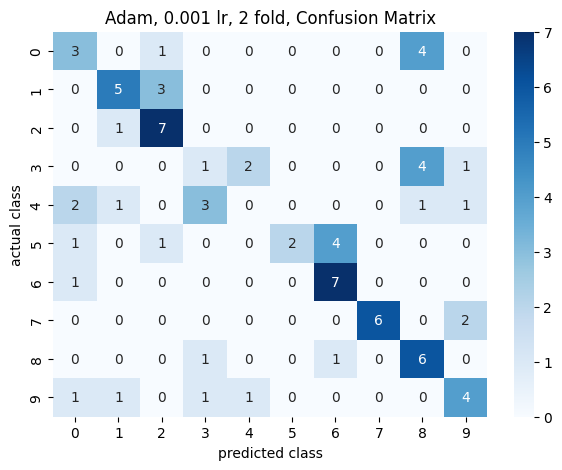

Adam, 0.001 lr, 2 fold, Overall F1 Score: 0.4821739130434783


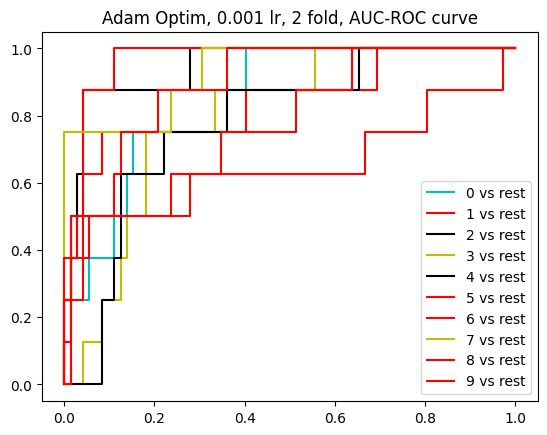

100%|██████████| 80/80 [00:00<00:00, 11439.14it/s]


Adam, 0.001 lr, 3 fold, Epoch 10/100, Training Loss: 2.0194891542196274, Training Accuracy: 52.916666666666664
Adam, 0.001 lr, 3 fold, Epoch 10/100, Validation Loss: 2.158097823460897, Validation Accuracy: 27.5
Adam, 0.001 lr, 3 fold, Epoch 20/100, Training Loss: 1.8460708856582642, Training Accuracy: 66.66666666666667
Adam, 0.001 lr, 3 fold, Epoch 20/100, Validation Loss: 2.1083919207255044, Validation Accuracy: 38.75
Adam, 0.001 lr, 3 fold, Epoch 30/100, Training Loss: 1.6714932769536972, Training Accuracy: 84.58333333333333
Adam, 0.001 lr, 3 fold, Epoch 30/100, Validation Loss: 1.9844758907953899, Validation Accuracy: 47.5
Adam, 0.001 lr, 3 fold, Epoch 40/100, Training Loss: 1.6124047636985779, Training Accuracy: 87.5
Adam, 0.001 lr, 3 fold, Epoch 40/100, Validation Loss: 1.953641454378764, Validation Accuracy: 51.25
Adam, 0.001 lr, 3 fold, Epoch 50/100, Training Loss: 1.587038442492485, Training Accuracy: 88.75
Adam, 0.001 lr, 3 fold, Epoch 50/100, Validation Loss: 1.97495702902476

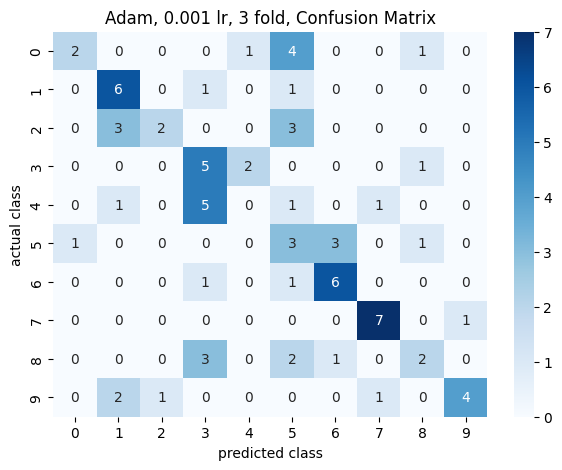

Adam, 0.001 lr, 3 fold, Overall F1 Score: 0.4436197902694067


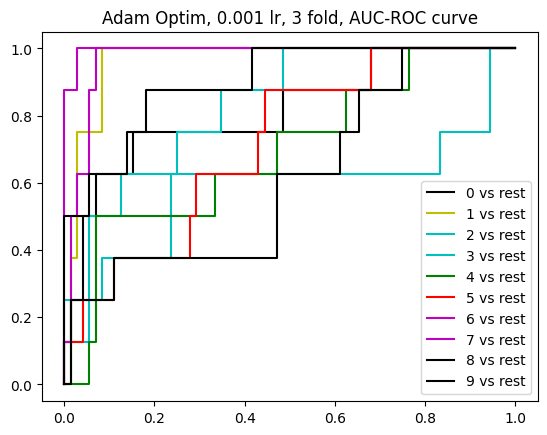

100%|██████████| 80/80 [00:00<00:00, 16566.00it/s]


Adam, 0.001 lr, 4 fold, Epoch 10/100, Training Loss: 2.047171398997307, Training Accuracy: 45.833333333333336
Adam, 0.001 lr, 4 fold, Epoch 10/100, Validation Loss: 2.0681427319844565, Validation Accuracy: 40.0
Adam, 0.001 lr, 4 fold, Epoch 20/100, Training Loss: 1.9169223308563232, Training Accuracy: 58.75
Adam, 0.001 lr, 4 fold, Epoch 20/100, Validation Loss: 2.0697653690973916, Validation Accuracy: 37.5
Adam, 0.001 lr, 4 fold, Epoch 30/100, Training Loss: 1.7920987457036972, Training Accuracy: 73.75
Adam, 0.001 lr, 4 fold, Epoch 30/100, Validation Loss: 1.9440956115722656, Validation Accuracy: 51.25
Adam, 0.001 lr, 4 fold, Epoch 40/100, Training Loss: 1.6889448165893555, Training Accuracy: 82.08333333333333
Adam, 0.001 lr, 4 fold, Epoch 40/100, Validation Loss: 2.017202933629354, Validation Accuracy: 48.75
Adam, 0.001 lr, 4 fold, Epoch 50/100, Training Loss: 1.6104911714792252, Training Accuracy: 88.33333333333333
Adam, 0.001 lr, 4 fold, Epoch 50/100, Validation Loss: 1.951494216918

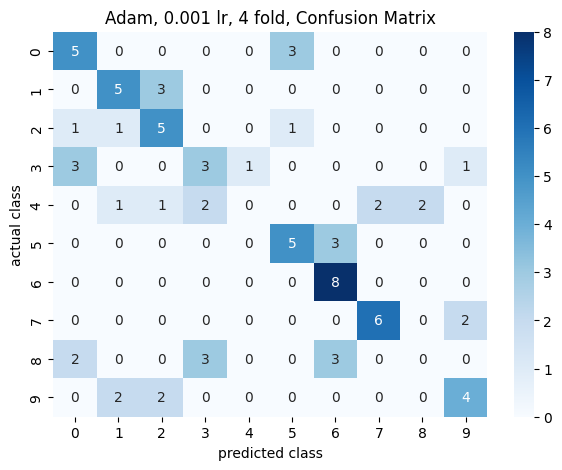

Adam, 0.001 lr, 4 fold, Overall F1 Score: 0.4614708227788723


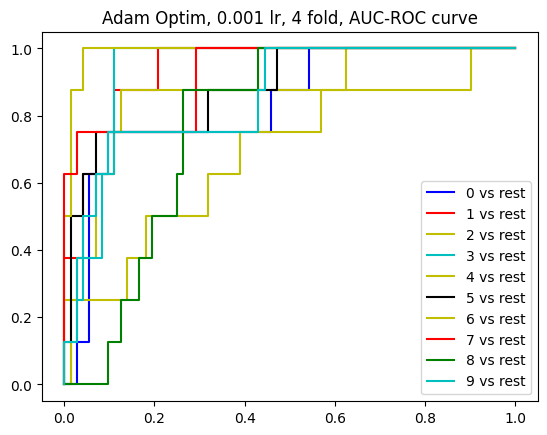

100%|██████████| 80/80 [00:00<00:00, 17383.91it/s]


Adam, 0.001 lr, 5 fold, Epoch 10/100, Training Loss: 2.0208902060985565, Training Accuracy: 46.25
Adam, 0.001 lr, 5 fold, Epoch 10/100, Validation Loss: 2.0581262906392417, Validation Accuracy: 37.5
Adam, 0.001 lr, 5 fold, Epoch 20/100, Training Loss: 1.8812151551246643, Training Accuracy: 62.083333333333336
Adam, 0.001 lr, 5 fold, Epoch 20/100, Validation Loss: 2.009815772374471, Validation Accuracy: 47.5
Adam, 0.001 lr, 5 fold, Epoch 30/100, Training Loss: 1.7434560358524323, Training Accuracy: 77.08333333333333
Adam, 0.001 lr, 5 fold, Epoch 30/100, Validation Loss: 1.9581462144851685, Validation Accuracy: 52.5
Adam, 0.001 lr, 5 fold, Epoch 40/100, Training Loss: 1.641397625207901, Training Accuracy: 84.16666666666667
Adam, 0.001 lr, 5 fold, Epoch 40/100, Validation Loss: 1.9547085762023926, Validation Accuracy: 55.0
Adam, 0.001 lr, 5 fold, Epoch 50/100, Training Loss: 1.6125264465808868, Training Accuracy: 87.08333333333333
Adam, 0.001 lr, 5 fold, Epoch 50/100, Validation Loss: 1.96

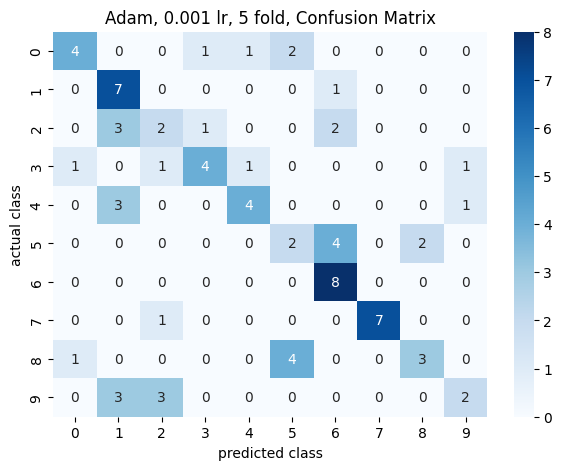

Adam, 0.001 lr, 5 fold, Overall F1 Score: 0.5238143016403887


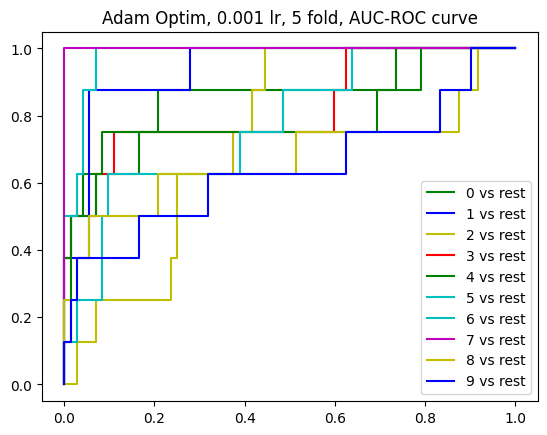

Adam, 0.001 lr, Mean validation accuracy: 55.625
Adam, 0.001 lr, Best test accuracy: 53.75


100%|██████████| 80/80 [00:00<00:00, 15704.59it/s]


Adam, 0.05 lr, 2 fold, Epoch 10/100, Training Loss: 2.3634782135486603, Training Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 10/100, Validation Loss: 2.3673907121022544, Validation Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 20/100, Training Loss: 2.355675160884857, Training Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 20/100, Validation Loss: 2.36739444732666, Validation Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 30/100, Training Loss: 2.351768583059311, Training Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 30/100, Validation Loss: 2.3673929373423257, Validation Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 40/100, Training Loss: 2.3595753610134125, Training Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 40/100, Validation Loss: 2.3673881689707437, Validation Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 50/100, Training Loss: 2.3673582077026367, Training Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 50/100, Validation Loss: 2.3673561414082847, Validation Accuracy: 10.0
Adam, 0.05 lr, 2 fold, E

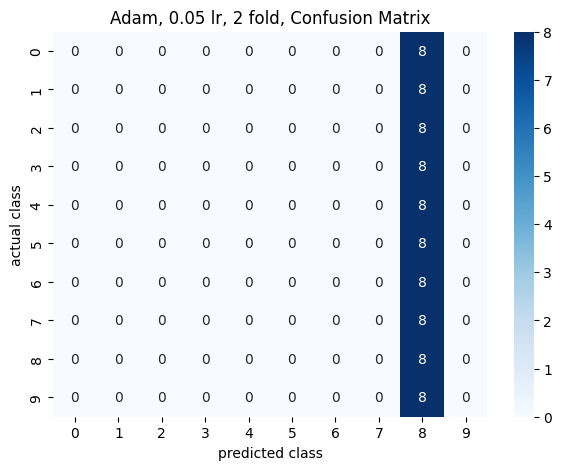

Adam, 0.05 lr, 2 fold, Overall F1 Score: 0.01818181818181818


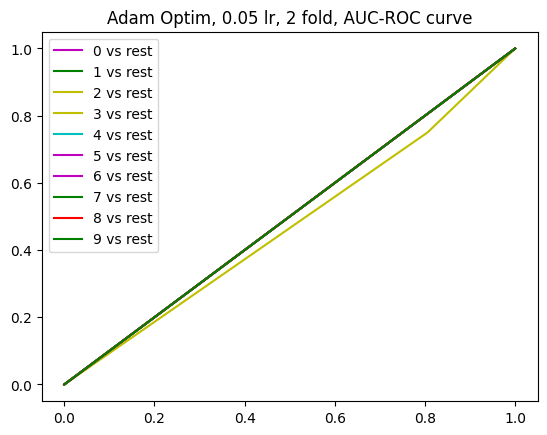

100%|██████████| 80/80 [00:00<00:00, 16939.84it/s]


Adam, 0.05 lr, 3 fold, Epoch 10/100, Training Loss: 2.355681926012039, Training Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 10/100, Validation Loss: 2.3674007256825766, Validation Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 20/100, Training Loss: 2.3634944558143616, Training Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 20/100, Validation Loss: 2.3674007256825766, Validation Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 30/100, Training Loss: 2.367400735616684, Training Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 30/100, Validation Loss: 2.3674007256825766, Validation Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 40/100, Training Loss: 2.3634945452213287, Training Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 40/100, Validation Loss: 2.3674007256825766, Validation Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 50/100, Training Loss: 2.3595882654190063, Training Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 50/100, Validation Loss: 2.3674007256825766, Validation Accuracy: 10.0
Adam, 0.05 lr, 3 fold,

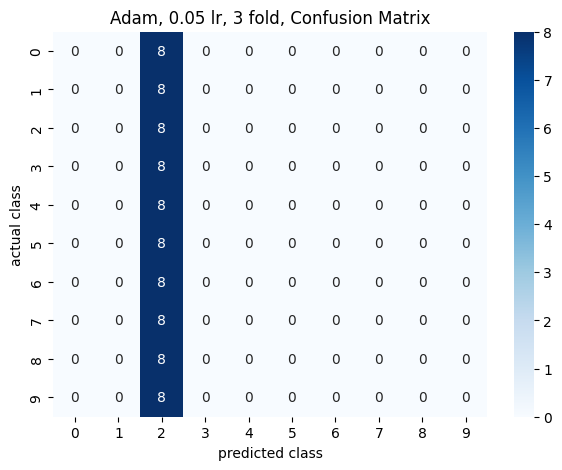

Adam, 0.05 lr, 3 fold, Overall F1 Score: 0.01818181818181818


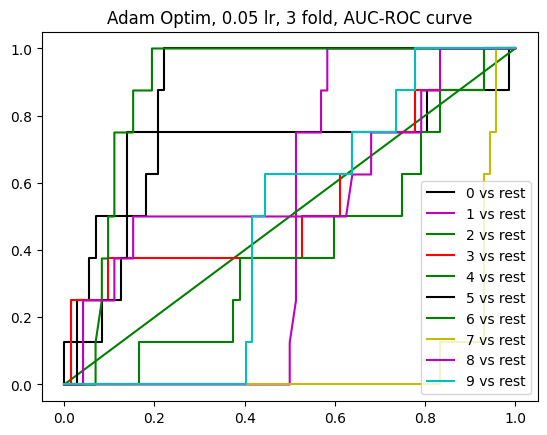

100%|██████████| 80/80 [00:00<00:00, 16426.51it/s]


Adam, 0.05 lr, 4 fold, Epoch 10/100, Training Loss: 2.332544505596161, Training Accuracy: 9.166666666666666
Adam, 0.05 lr, 4 fold, Epoch 10/100, Validation Loss: 2.3397430578867593, Validation Accuracy: 10.0
Adam, 0.05 lr, 4 fold, Epoch 20/100, Training Loss: 2.3493801057338715, Training Accuracy: 10.0
Adam, 0.05 lr, 4 fold, Epoch 20/100, Validation Loss: 2.341803948084513, Validation Accuracy: 10.0
Adam, 0.05 lr, 4 fold, Epoch 30/100, Training Loss: 2.3179309368133545, Training Accuracy: 9.583333333333334
Adam, 0.05 lr, 4 fold, Epoch 30/100, Validation Loss: 2.319399436314901, Validation Accuracy: 10.0
Adam, 0.05 lr, 4 fold, Epoch 40/100, Training Loss: 2.3148553371429443, Training Accuracy: 9.166666666666666
Adam, 0.05 lr, 4 fold, Epoch 40/100, Validation Loss: 2.31679368019104, Validation Accuracy: 10.0
Adam, 0.05 lr, 4 fold, Epoch 50/100, Training Loss: 2.329199969768524, Training Accuracy: 9.583333333333334
Adam, 0.05 lr, 4 fold, Epoch 50/100, Validation Loss: 2.3197887738545737, 

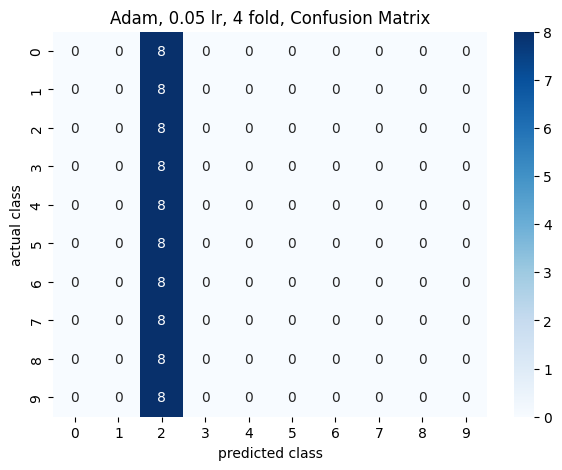

Adam, 0.05 lr, 4 fold, Overall F1 Score: 0.01818181818181818


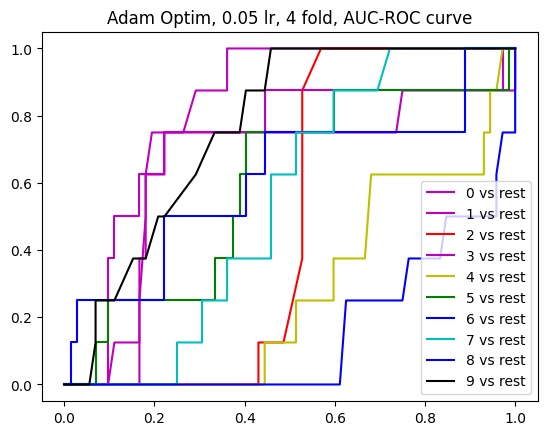

100%|██████████| 80/80 [00:00<00:00, 16165.36it/s]


Adam, 0.05 lr, 5 fold, Epoch 10/100, Training Loss: 2.3556821048259735, Training Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 10/100, Validation Loss: 2.377817471822103, Validation Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 20/100, Training Loss: 2.3674008548259735, Training Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 20/100, Validation Loss: 2.377817471822103, Validation Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 30/100, Training Loss: 2.3674008548259735, Training Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 30/100, Validation Loss: 2.377817471822103, Validation Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 40/100, Training Loss: 2.3595883548259735, Training Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 40/100, Validation Loss: 2.377817471822103, Validation Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 50/100, Training Loss: 2.3595883548259735, Training Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 50/100, Validation Loss: 2.377817471822103, Validation Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Ep

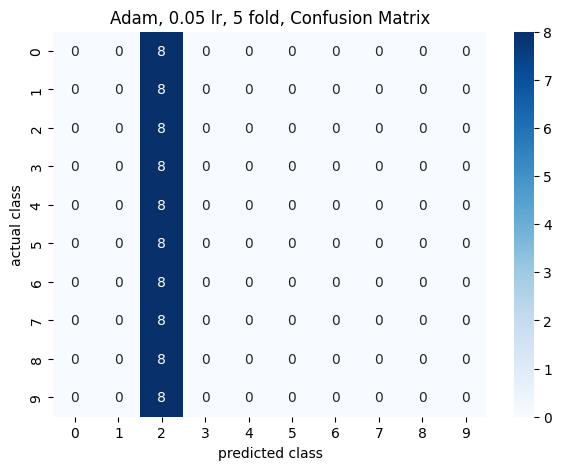

Adam, 0.05 lr, 5 fold, Overall F1 Score: 0.01818181818181818


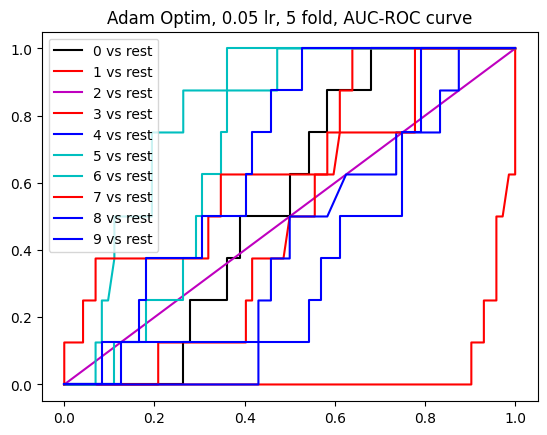

Adam, 0.05 lr, Mean validation accuracy: 10.0
Adam, 0.05 lr, Best test accuracy: 10.0


100%|██████████| 80/80 [00:00<00:00, 16180.95it/s]


SGD, 0.001 lr, 2 fold, Epoch 10/100, Training Loss: 2.305449992418289, Training Accuracy: 9.166666666666666
SGD, 0.001 lr, 2 fold, Epoch 10/100, Validation Loss: 2.299550692240397, Validation Accuracy: 8.75
SGD, 0.001 lr, 2 fold, Epoch 20/100, Training Loss: 2.3040080070495605, Training Accuracy: 9.166666666666666
SGD, 0.001 lr, 2 fold, Epoch 20/100, Validation Loss: 2.299343983332316, Validation Accuracy: 8.75
SGD, 0.001 lr, 2 fold, Epoch 30/100, Training Loss: 2.3032762110233307, Training Accuracy: 9.166666666666666
SGD, 0.001 lr, 2 fold, Epoch 30/100, Validation Loss: 2.2990379333496094, Validation Accuracy: 8.75
SGD, 0.001 lr, 2 fold, Epoch 40/100, Training Loss: 2.3023783564567566, Training Accuracy: 8.333333333333334
SGD, 0.001 lr, 2 fold, Epoch 40/100, Validation Loss: 2.2989919980367026, Validation Accuracy: 8.75
SGD, 0.001 lr, 2 fold, Epoch 50/100, Training Loss: 2.3030766546726227, Training Accuracy: 8.75
SGD, 0.001 lr, 2 fold, Epoch 50/100, Validation Loss: 2.298741022745768

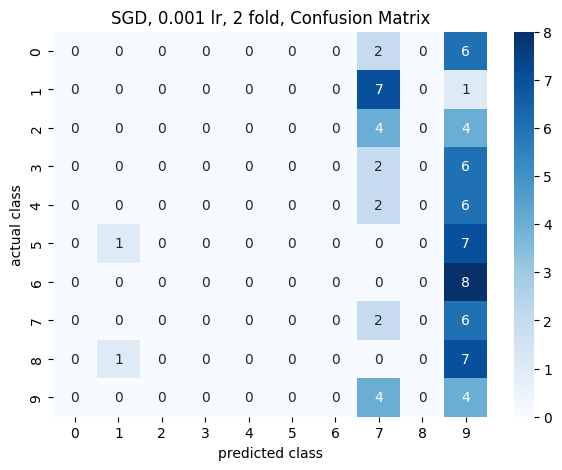

SGD, 0.001 lr, 2 fold, Overall F1 Score: 0.02560163850486431


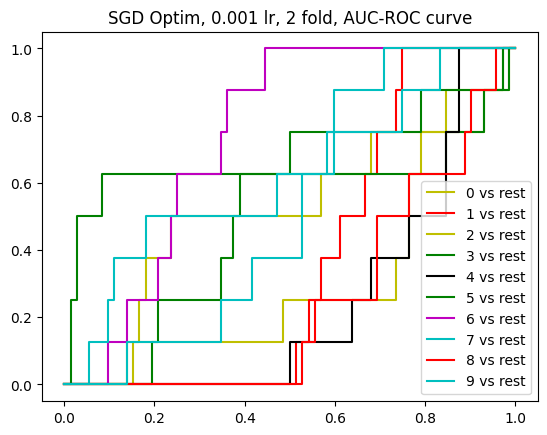

100%|██████████| 80/80 [00:00<00:00, 12612.55it/s]


SGD, 0.001 lr, 3 fold, Epoch 10/100, Training Loss: 2.3052691519260406, Training Accuracy: 10.416666666666666
SGD, 0.001 lr, 3 fold, Epoch 10/100, Validation Loss: 2.2979768911997476, Validation Accuracy: 11.25
SGD, 0.001 lr, 3 fold, Epoch 20/100, Training Loss: 2.304399073123932, Training Accuracy: 10.416666666666666
SGD, 0.001 lr, 3 fold, Epoch 20/100, Validation Loss: 2.2977015177408853, Validation Accuracy: 11.25
SGD, 0.001 lr, 3 fold, Epoch 30/100, Training Loss: 2.305060923099518, Training Accuracy: 10.416666666666666
SGD, 0.001 lr, 3 fold, Epoch 30/100, Validation Loss: 2.297482172648112, Validation Accuracy: 11.25
SGD, 0.001 lr, 3 fold, Epoch 40/100, Training Loss: 2.305540144443512, Training Accuracy: 10.0
SGD, 0.001 lr, 3 fold, Epoch 40/100, Validation Loss: 2.2972091833750405, Validation Accuracy: 11.25
SGD, 0.001 lr, 3 fold, Epoch 50/100, Training Loss: 2.3042097091674805, Training Accuracy: 10.416666666666666
SGD, 0.001 lr, 3 fold, Epoch 50/100, Validation Loss: 2.29697418

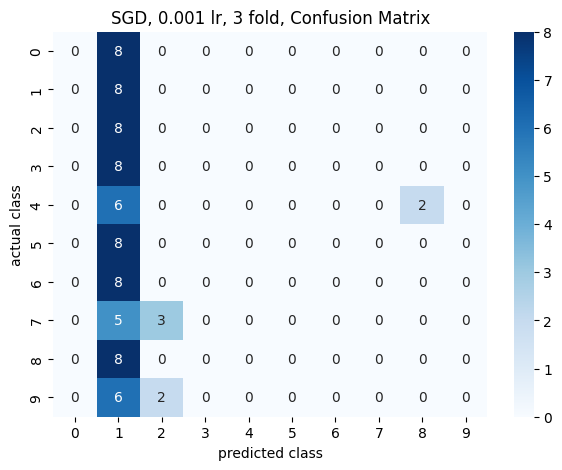

SGD, 0.001 lr, 3 fold, Overall F1 Score: 0.019753086419753086


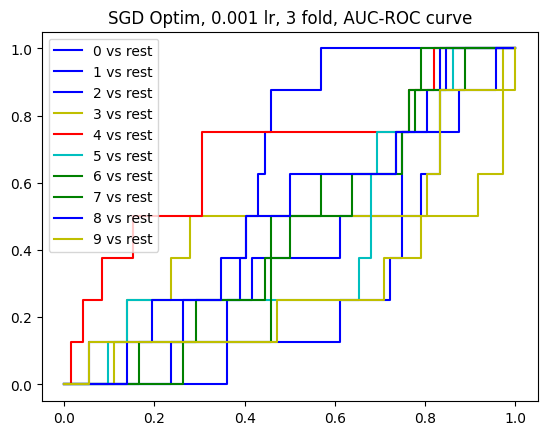

100%|██████████| 80/80 [00:00<00:00, 15525.83it/s]


SGD, 0.001 lr, 4 fold, Epoch 10/100, Training Loss: 2.301596313714981, Training Accuracy: 13.75
SGD, 0.001 lr, 4 fold, Epoch 10/100, Validation Loss: 2.3054882685343423, Validation Accuracy: 7.5
SGD, 0.001 lr, 4 fold, Epoch 20/100, Training Loss: 2.3018653094768524, Training Accuracy: 14.166666666666666
SGD, 0.001 lr, 4 fold, Epoch 20/100, Validation Loss: 2.305528004964193, Validation Accuracy: 10.0
SGD, 0.001 lr, 4 fold, Epoch 30/100, Training Loss: 2.301077216863632, Training Accuracy: 12.5
SGD, 0.001 lr, 4 fold, Epoch 30/100, Validation Loss: 2.3053759733835855, Validation Accuracy: 10.0
SGD, 0.001 lr, 4 fold, Epoch 40/100, Training Loss: 2.301745295524597, Training Accuracy: 12.5
SGD, 0.001 lr, 4 fold, Epoch 40/100, Validation Loss: 2.3053622245788574, Validation Accuracy: 10.0
SGD, 0.001 lr, 4 fold, Epoch 50/100, Training Loss: 2.3015556633472443, Training Accuracy: 13.333333333333334
SGD, 0.001 lr, 4 fold, Epoch 50/100, Validation Loss: 2.305265426635742, Validation Accuracy: 10

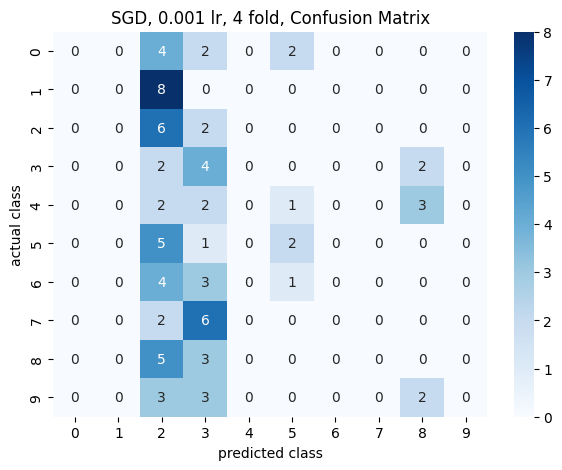

SGD, 0.001 lr, 4 fold, Overall F1 Score: 0.0765906362545018


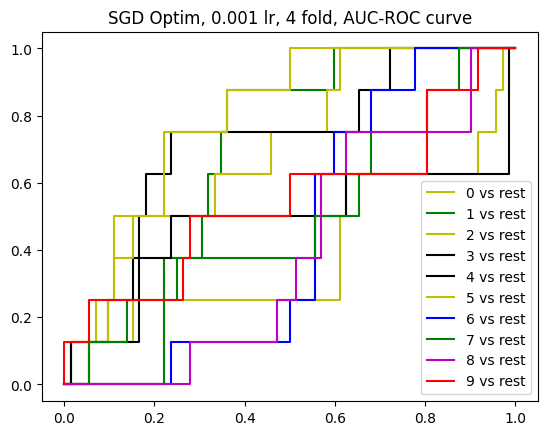

100%|██████████| 80/80 [00:00<00:00, 13505.51it/s]


SGD, 0.001 lr, 5 fold, Epoch 10/100, Training Loss: 2.3058221340179443, Training Accuracy: 10.0
SGD, 0.001 lr, 5 fold, Epoch 10/100, Validation Loss: 2.3038310209910073, Validation Accuracy: 10.0
SGD, 0.001 lr, 5 fold, Epoch 20/100, Training Loss: 2.304993122816086, Training Accuracy: 9.583333333333334
SGD, 0.001 lr, 5 fold, Epoch 20/100, Validation Loss: 2.3033897082010903, Validation Accuracy: 10.0
SGD, 0.001 lr, 5 fold, Epoch 30/100, Training Loss: 2.3051430881023407, Training Accuracy: 9.583333333333334
SGD, 0.001 lr, 5 fold, Epoch 30/100, Validation Loss: 2.303014357884725, Validation Accuracy: 7.5
SGD, 0.001 lr, 5 fold, Epoch 40/100, Training Loss: 2.302869886159897, Training Accuracy: 9.583333333333334
SGD, 0.001 lr, 5 fold, Epoch 40/100, Validation Loss: 2.302639643351237, Validation Accuracy: 8.75
SGD, 0.001 lr, 5 fold, Epoch 50/100, Training Loss: 2.30436110496521, Training Accuracy: 10.416666666666666
SGD, 0.001 lr, 5 fold, Epoch 50/100, Validation Loss: 2.3023602962493896, 

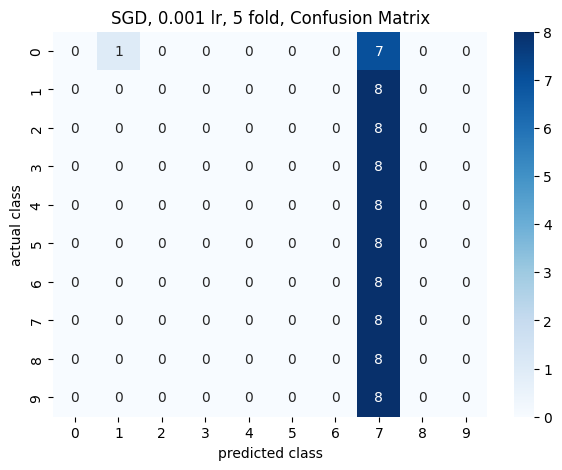

SGD, 0.001 lr, 5 fold, Overall F1 Score: 0.018390804597701146


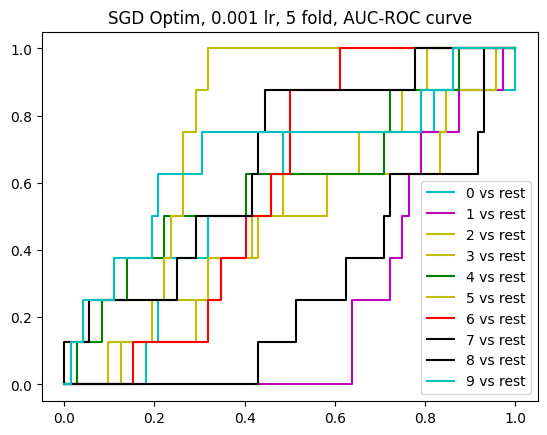

SGD, 0.001 lr, Mean validation accuracy: 10.3125
SGD, 0.001 lr, Best test accuracy: 15.0


100%|██████████| 80/80 [00:00<00:00, 16241.25it/s]


SGD, 0.05 lr, 2 fold, Epoch 10/100, Training Loss: 2.3046929836273193, Training Accuracy: 7.5
SGD, 0.05 lr, 2 fold, Epoch 10/100, Validation Loss: 2.3066964149475098, Validation Accuracy: 10.0
SGD, 0.05 lr, 2 fold, Epoch 20/100, Training Loss: 2.303664982318878, Training Accuracy: 10.0
SGD, 0.05 lr, 2 fold, Epoch 20/100, Validation Loss: 2.3050305048624673, Validation Accuracy: 8.75
SGD, 0.05 lr, 2 fold, Epoch 30/100, Training Loss: 2.3027049899101257, Training Accuracy: 7.916666666666667
SGD, 0.05 lr, 2 fold, Epoch 30/100, Validation Loss: 2.3046141465504966, Validation Accuracy: 11.25
SGD, 0.05 lr, 2 fold, Epoch 40/100, Training Loss: 2.3013694286346436, Training Accuracy: 14.583333333333334
SGD, 0.05 lr, 2 fold, Epoch 40/100, Validation Loss: 2.3022449811299643, Validation Accuracy: 17.5
SGD, 0.05 lr, 2 fold, Epoch 50/100, Training Loss: 2.2856899797916412, Training Accuracy: 18.75
SGD, 0.05 lr, 2 fold, Epoch 50/100, Validation Loss: 2.2826267083485923, Validation Accuracy: 17.5
SGD

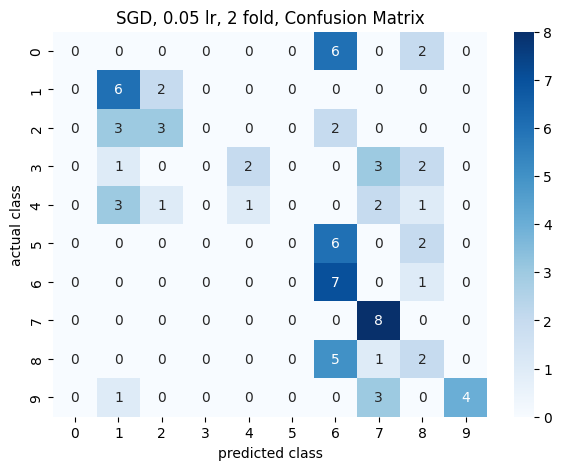

SGD, 0.05 lr, 2 fold, Overall F1 Score: 0.3096497750615398


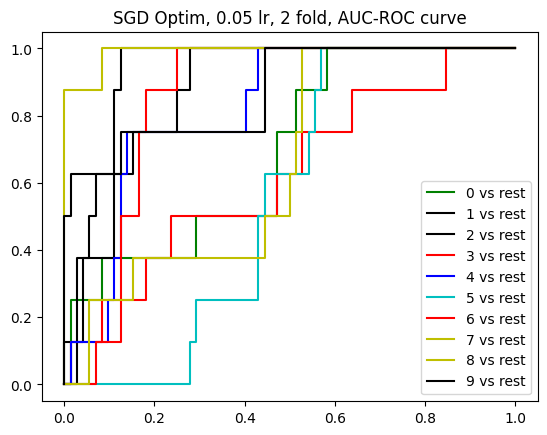

100%|██████████| 80/80 [00:00<00:00, 16909.11it/s]


SGD, 0.05 lr, 3 fold, Epoch 10/100, Training Loss: 2.192267417907715, Training Accuracy: 28.75
SGD, 0.05 lr, 3 fold, Epoch 10/100, Validation Loss: 2.1885794003804526, Validation Accuracy: 27.5
SGD, 0.05 lr, 3 fold, Epoch 20/100, Training Loss: 2.0879503041505814, Training Accuracy: 41.666666666666664
SGD, 0.05 lr, 3 fold, Epoch 20/100, Validation Loss: 2.1367428302764893, Validation Accuracy: 32.5
SGD, 0.05 lr, 3 fold, Epoch 30/100, Training Loss: 2.0146987289190292, Training Accuracy: 48.333333333333336
SGD, 0.05 lr, 3 fold, Epoch 30/100, Validation Loss: 2.1157617568969727, Validation Accuracy: 33.75
SGD, 0.05 lr, 3 fold, Epoch 40/100, Training Loss: 1.981285274028778, Training Accuracy: 52.083333333333336
SGD, 0.05 lr, 3 fold, Epoch 40/100, Validation Loss: 2.0858147144317627, Validation Accuracy: 33.75
SGD, 0.05 lr, 3 fold, Epoch 50/100, Training Loss: 1.9734762459993362, Training Accuracy: 51.666666666666664
SGD, 0.05 lr, 3 fold, Epoch 50/100, Validation Loss: 2.0726889769236245,

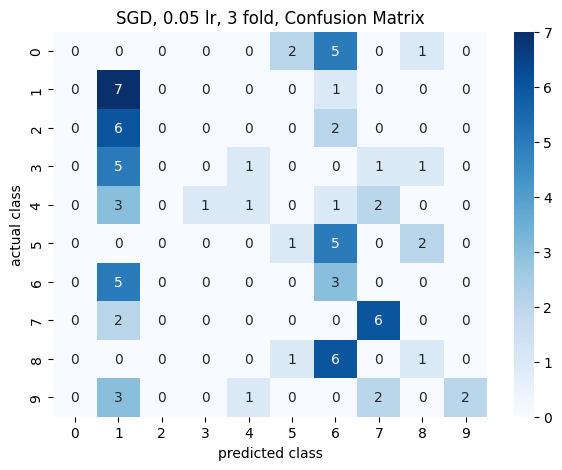

SGD, 0.05 lr, 3 fold, Overall F1 Score: 0.20864326957705565


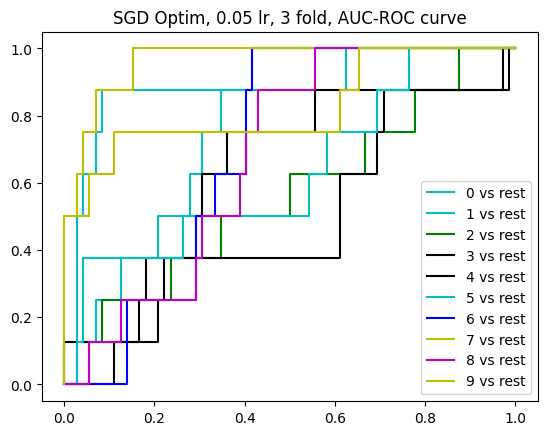

100%|██████████| 80/80 [00:00<00:00, 15858.23it/s]


SGD, 0.05 lr, 4 fold, Epoch 10/100, Training Loss: 2.2499621212482452, Training Accuracy: 23.75
SGD, 0.05 lr, 4 fold, Epoch 10/100, Validation Loss: 2.2279485066731772, Validation Accuracy: 22.5
SGD, 0.05 lr, 4 fold, Epoch 20/100, Training Loss: 2.1090967059135437, Training Accuracy: 40.0
SGD, 0.05 lr, 4 fold, Epoch 20/100, Validation Loss: 2.133859395980835, Validation Accuracy: 32.5
SGD, 0.05 lr, 4 fold, Epoch 30/100, Training Loss: 2.0669186860322952, Training Accuracy: 44.583333333333336
SGD, 0.05 lr, 4 fold, Epoch 30/100, Validation Loss: 2.0636730988820395, Validation Accuracy: 43.75
SGD, 0.05 lr, 4 fold, Epoch 40/100, Training Loss: 2.0169728696346283, Training Accuracy: 49.583333333333336
SGD, 0.05 lr, 4 fold, Epoch 40/100, Validation Loss: 2.0614280700683594, Validation Accuracy: 41.25
SGD, 0.05 lr, 4 fold, Epoch 50/100, Training Loss: 1.9881579279899597, Training Accuracy: 51.25
SGD, 0.05 lr, 4 fold, Epoch 50/100, Validation Loss: 2.0235721270243325, Validation Accuracy: 43.7

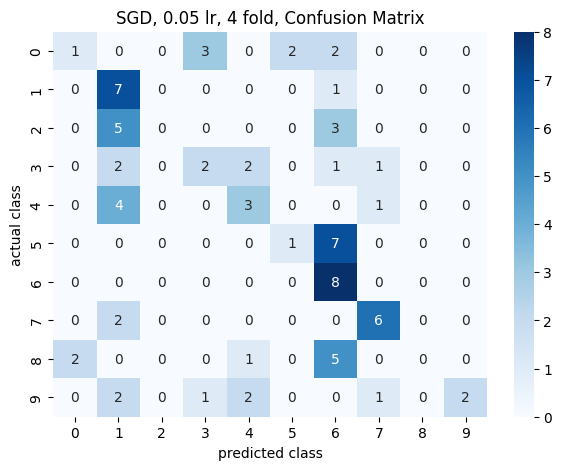

SGD, 0.05 lr, 4 fold, Overall F1 Score: 0.30540425261013493


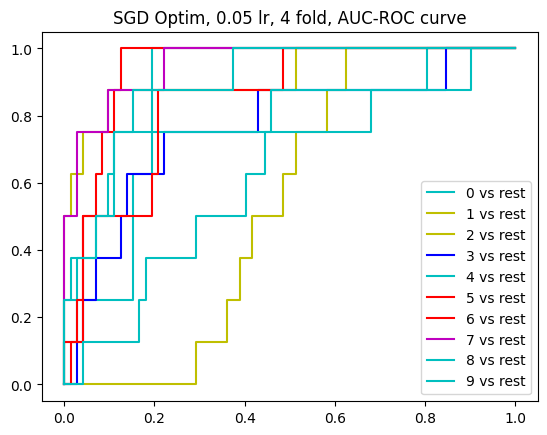

100%|██████████| 80/80 [00:00<00:00, 16730.37it/s]


SGD, 0.05 lr, 5 fold, Epoch 10/100, Training Loss: 2.297495871782303, Training Accuracy: 15.416666666666666
SGD, 0.05 lr, 5 fold, Epoch 10/100, Validation Loss: 2.2922677993774414, Validation Accuracy: 27.5
SGD, 0.05 lr, 5 fold, Epoch 20/100, Training Loss: 2.173147588968277, Training Accuracy: 32.083333333333336
SGD, 0.05 lr, 5 fold, Epoch 20/100, Validation Loss: 2.1455697218577066, Validation Accuracy: 37.5
SGD, 0.05 lr, 5 fold, Epoch 30/100, Training Loss: 2.085538327693939, Training Accuracy: 42.083333333333336
SGD, 0.05 lr, 5 fold, Epoch 30/100, Validation Loss: 2.1145896911621094, Validation Accuracy: 42.5
SGD, 0.05 lr, 5 fold, Epoch 40/100, Training Loss: 2.044420212507248, Training Accuracy: 43.75
SGD, 0.05 lr, 5 fold, Epoch 40/100, Validation Loss: 2.0579595963160195, Validation Accuracy: 41.25
SGD, 0.05 lr, 5 fold, Epoch 50/100, Training Loss: 1.9990509003400803, Training Accuracy: 48.333333333333336
SGD, 0.05 lr, 5 fold, Epoch 50/100, Validation Loss: 2.036196152369181, Val

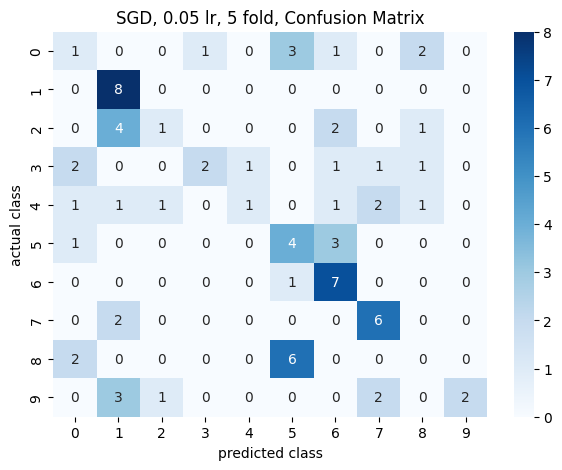

SGD, 0.05 lr, 5 fold, Overall F1 Score: 0.34980834573511915


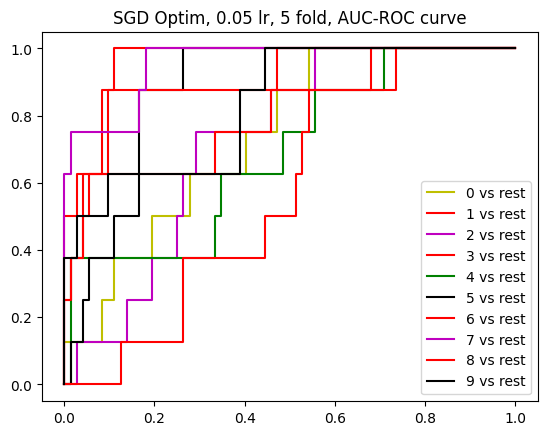

SGD, 0.05 lr, Mean validation accuracy: 41.25
SGD, 0.05 lr, Best test accuracy: 40.0


In [29]:
for optimizer_type in optimizers:
    for lr_type in learning_rates:

        all_test_accuracy = []
        all_validation_accuracy = []
        valid_samples = [2,3,4,5]

        for i in valid_samples:
            # Data Setup
            test_samp = 1 #Do not change this!!
            valid_samp = i # Use any value ranging from 2 to 5 for k-fold validation (valid_fold)
            batch_size = 32 # Free to change
            num_workers = 2 # Free to change
            custom_data_module = CustomDataModule(batch_size=batch_size,
                                                num_workers=num_workers,
                                                data_directory=path,
                                                data_frame=df,
                                                validation_fold=valid_samp,
                                                testing_fold=test_samp,  # set to 0 for no test set
                                                esc_10_flag=True,
                                                file_column='filename',
                                                label_column='category',
                                                sampling_rate=44100,
                                                new_sampling_rate=16000,  # new sample rate for input
                                                sample_length_seconds=1  # new length of input in seconds
                                                )

            custom_data_module.setup()

            # Hyperparameters
            num_classes = 10
            lr = lr_type
            epochs = 100
            # Model, Optimizer, Loss function
            model2 = Architecture2().to(device)
            # model2 = Architecture2()
            # optimizer = optim.Adam(model2.parameters(), lr=lr)
            if optimizer_type == 'Adam':
                optimizer = optim.Adam(model2.parameters(), lr=lr)
            elif optimizer_type == 'SGD':
                optimizer = optim.SGD(model2.parameters(), lr=lr)

            criterion = nn.CrossEntropyLoss()

            # WandB initialization
            wandb.init(project="Architecture2_model2_Head1_final_light", name=f"{optimizer_type}, {lr} lr, {i} fold")

            # Training loop
            train_acc_track = []
            val_acc_track = []
            train_loss_track = []
            val_loss_track = []

            for epoch in range(epochs):
                model2.train()
                running_loss = 0.0
                correct = 0
                total = 0

                for data, target in custom_data_module.train_dataloader():
                    data, target = data.to(device), target.to(device)
                    optimizer.zero_grad()
                    output = model2(data)
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()
                    _, predicted = output.max(1)

                    total += target.size(0)
                    correct += predicted.eq(target).sum().item()

                train_loss = running_loss / len(custom_data_module.train_dataloader())
                train_acc = 100. * correct / total

                train_loss_track.append(train_loss)
                train_acc_track.append(train_acc)

                if (epoch+1) % 10 == 0:
                    print(f'{optimizer_type}, {lr} lr, {i} fold, Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Training Accuracy: {train_acc}')
                # print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Training Accuracy: {train_acc}')

                # Validation
                model2.eval()
                val_loss = 0.0
                val_correct = 0
                val_total = 0

                with torch.no_grad():
                    for data, target in custom_data_module.val_dataloader():
                        data, target = data.to(device), target.to(device)
                        output = model2(data)
                        loss = criterion(output, target)
                        val_loss += loss.item()
                        _, predicted = output.max(1)

                        val_total += target.size(0)
                        val_correct += predicted.eq(target).sum().item()

                val_loss /= len(custom_data_module.val_dataloader())
                val_acc = 100. * val_correct / val_total

                val_loss_track.append(val_loss)
                val_acc_track.append(val_acc)

                if (epoch+1) % 10 == 0:
                    print(f'{optimizer_type}, {lr} lr, {i} fold, Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')
                # print(f'Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

                # # Logging
                wandb.log({"Train Loss": train_loss, "Train Accuracy": train_acc, "Validation Loss": val_loss, "Val Accuracy": val_acc, "Learning rate": lr, "Optimizer": optimizer_type})


            all_validation_accuracy.append(val_acc)

            # Testing
            model2.eval()
            test_correct = 0
            test_total = 0
            all_labels_test = []
            all_preds_test = []
            all_probabilities = []

            with torch.no_grad():
                for data, target in custom_data_module.test_dataloader():
                    data, target = data.to(device), target.to(device)
                    output = model2(data)
                    all_probabilities.extend(output.cpu().numpy())
                    _, predicted = output.max(1)
                    test_total += target.size(0)
                    test_correct += predicted.eq(target).sum().item()
                    all_labels_test.extend(target.cpu().numpy())
                    all_preds_test.extend(predicted.cpu().numpy())

            test_acc = 100. * test_correct / test_total
            print(f'{optimizer_type}, {lr} lr, {i} fold, Test Accuracy: {test_acc:.2f}%')
            # print(f'Test Accuracy: {test_acc:.2f}%')
            all_test_accuracy.append(test_acc)

            # Confusion Matrix for test set
            cm = confusion_matrix(all_labels_test, all_preds_test)
            plt.figure(figsize=(7, 5))
            sns.heatmap(cm, annot=True,fmt = 'd', cmap='Blues')
            plt.title(f'{optimizer_type}, {lr} lr, {i} fold, Confusion Matrix')
            # plt.title(f'Confusion Matrix')
            plt.xlabel("predicted class",size=10)
            plt.ylabel("actual class",size=10)
            # plt.show()

            # # Confusion Matrix
            # cm = wandb.plot.confusion_matrix(
            #     y_true = all_labels_test, preds = all_preds_test
            # )
            wandb.log({"Confusion Matrix": wandb.Image(plt)})
            plt.show()

            # Calculate overall F1 score
            overall_f1_score = f1_score(all_labels_test, all_preds_test, average='weighted')

            # print(f'Overall F1 Score: {overall_f1_score}')
            print(f'{optimizer_type}, {lr} lr, {i} fold, Overall F1 Score: {overall_f1_score}')

            wandb.summary["F1 score"] = overall_f1_score

            # roc curve for classes
            fpr = {}
            tpr = {}
            thresh ={}
            n_class = 10

            for j in range(n_class):
                fpr[j], tpr[j], thresh[j] = roc_curve(all_labels_test, np.array(all_probabilities)[:,j], pos_label=j)
                plt.plot(fpr[j], tpr[j], label = f'{j} vs rest',color = np.random.choice(['r','g','b','y','c','m','k']))
            plt.legend()
            # plt.title("AUC-ROC curve")
            plt.title(f'{optimizer_type} Optim, {lr} lr, {i} fold, AUC-ROC curve')


            # # roc curve for classes
            # roc_curves = {}
            # n_class = 10  # Assuming you have 10 classes, adjust accordingly

            # for j in range(n_class):
            #     fpr[j], tpr[j], _ = roc_curve(all_labels_test, np.array(all_probabilities)[:, j], pos_label=j)
            #     roc_curves[j] = {"fpr": fpr[j], "tpr": tpr[j]}

            wandb.log({"ROC curve": wandb.Image(plt)})
            plt.show()

            wandb.summary["Test accuracy"] = test_acc
            wandb.finish()

        print(f'{optimizer_type}, {lr} lr, Mean validation accuracy: {mean(all_validation_accuracy)}')
        print(f'{optimizer_type}, {lr} lr, Best test accuracy: {max(all_test_accuracy)}')

In [30]:
#Architecture2 - Model2 - head = 2

In [31]:
class Architecture2(nn.Module):
    def __init__(self):
        super(Architecture2, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(16)  # BatchNorm1d after first conv layer
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(32)  # BatchNorm1d after second conv layer
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)  # BatchNorm1d after third conv layer
        self.conv4 = nn.Conv1d(64, 48, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(48)
        self.ad1 = nn.AdaptiveAvgPool2d((47, 48))
        # self.conv5 = nn.Conv1d(48, 16, kernel_size=3, stride=1, padding=1)
        # self.bn5 = nn.BatchNorm1d(16)
        self.fc1 = nn.Linear(48, 48)
        self.fc2 = nn.Linear(48, 48)
        self.fc3= nn.Linear(48, 10)
        # self.fc3 = nn.Linear(2250, 10)

        self.multi_head_self_attention = multi_head_self_attention(48, 2)
        self.multi_head_self_attention2 = multi_head_self_attention(48, 2)
        self.attention_blocks = [(self.multi_head_self_attention, self.fc1),(self.multi_head_self_attention2, self.fc2) ]

    def forward(self, x):
        # x=x.float()
        x = F.max_pool1d(F.relu(self.bn1(self.conv1(x))), 12)
        x = F.max_pool1d(F.relu(self.bn2(self.conv2(x))), 8)
        x = F.max_pool1d(F.relu(self.bn3(self.conv3(x))), 4)
        x = F.max_pool1d(F.relu(self.bn4(self.conv4(x))), 2)
        x = self.ad1(x)
        # x = F.max_pool1d(F.relu(self.bn5(self.conv5(x))), 16)
        # x = x.view(x.size(0), -1)
        # x = F.relu(self.fc1(x))  # Add ReLU after fc1
        # x = F.relu(self.fc2(x))  # Add ReLU after fc2
        # x = F.softmax(self.fc2(x), dim=1)  # Apply softmax on final layer

        # print(x.shape)
        self.cls_token = nn.Parameter(torch.zeros(1, 48).to(device))
        x = torch.cat((self.cls_token.expand(x.size(0), 1, -1), x), dim=1)
        x = x.to(device)
        # x = torch.cat((cls_token,x), dim=1)
        # print(x.shape)

        #Multi-head self attention
        for blocks in self.attention_blocks:

            #Positional encoding
            x = x + torch.tensor(self.getPositionEncoding(48, 48),dtype = x.dtype).to(device)

            multihead = blocks[0]
            fc = blocks[1]

            y = multihead(x)
            x = x + y

            #layer norm
            x = self.layer_normalization(x)

            #mlp
            y = fc(x)#self.mlp_layer(x)
            x = x + y

            #layer norm
            x = self.layer_normalization(x)

        #final mlp layer for classification
        x = torch.flatten(x[:,0],1)
        # x = self.fc2(x)#self.mlp_layer_final(x)
        x = F.softmax(self.fc3(x), dim=1)  # Apply softmax on final layer

        # print(x.shape)
        return x

    def getPositionEncoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(0,seq_len-1):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k+1, 2*i] = np.sin(k/denominator)
                P[k+1, 2*i+1] = np.cos(k/denominator)
        return P

    def layer_normalization(self, x, eps=1e-6):
        mean = torch.mean(x, dim=-1, keepdim=True)
        std = torch.std(x, dim=-1, keepdim=True) + eps
        return (x - mean) / std

In [32]:
learning_rates = [0.001, 0.05]
optimizers = ['Adam', 'SGD']

100%|██████████| 80/80 [00:00<00:00, 16862.37it/s]


Adam, 0.001 lr, 2 fold, Epoch 10/100, Training Loss: 2.0591559410095215, Training Accuracy: 45.0
Adam, 0.001 lr, 2 fold, Epoch 10/100, Validation Loss: 2.085754871368408, Validation Accuracy: 41.25
Adam, 0.001 lr, 2 fold, Epoch 20/100, Training Loss: 1.9026221632957458, Training Accuracy: 62.083333333333336
Adam, 0.001 lr, 2 fold, Epoch 20/100, Validation Loss: 2.0402735074361167, Validation Accuracy: 41.25
Adam, 0.001 lr, 2 fold, Epoch 30/100, Training Loss: 1.8099820464849472, Training Accuracy: 66.25
Adam, 0.001 lr, 2 fold, Epoch 30/100, Validation Loss: 2.0402417182922363, Validation Accuracy: 45.0
Adam, 0.001 lr, 2 fold, Epoch 40/100, Training Loss: 1.7349788397550583, Training Accuracy: 75.41666666666667
Adam, 0.001 lr, 2 fold, Epoch 40/100, Validation Loss: 1.988666335741679, Validation Accuracy: 47.5
Adam, 0.001 lr, 2 fold, Epoch 50/100, Training Loss: 1.7279108464717865, Training Accuracy: 75.83333333333333
Adam, 0.001 lr, 2 fold, Epoch 50/100, Validation Loss: 2.0107163190841

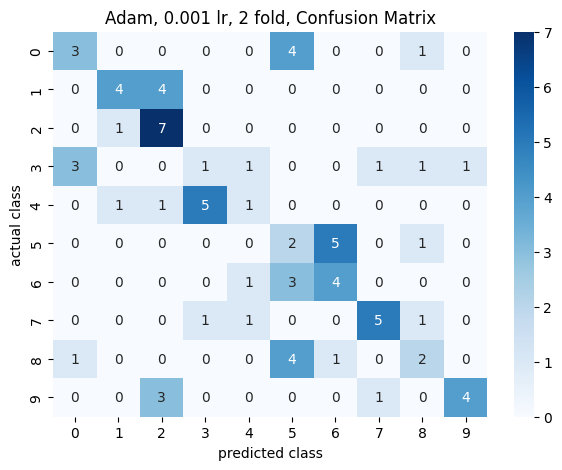

Adam, 0.001 lr, 2 fold, Overall F1 Score: 0.4082810426288687


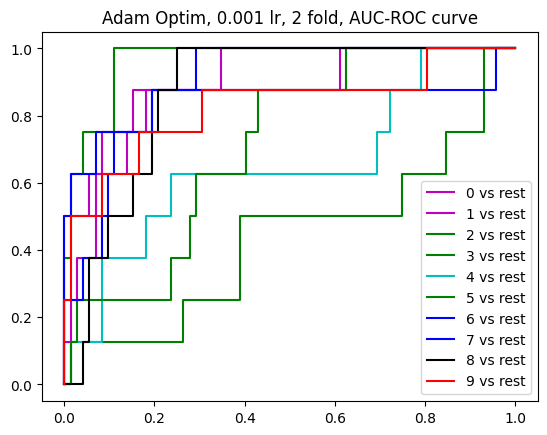

100%|██████████| 80/80 [00:00<00:00, 17209.17it/s]


Adam, 0.001 lr, 3 fold, Epoch 10/100, Training Loss: 1.9979969561100006, Training Accuracy: 50.0
Adam, 0.001 lr, 3 fold, Epoch 10/100, Validation Loss: 2.0926942825317383, Validation Accuracy: 35.0
Adam, 0.001 lr, 3 fold, Epoch 20/100, Training Loss: 1.8523876667022705, Training Accuracy: 63.75
Adam, 0.001 lr, 3 fold, Epoch 20/100, Validation Loss: 2.063568909962972, Validation Accuracy: 37.5
Adam, 0.001 lr, 3 fold, Epoch 30/100, Training Loss: 1.6992372423410416, Training Accuracy: 80.41666666666667
Adam, 0.001 lr, 3 fold, Epoch 30/100, Validation Loss: 1.9819678862889607, Validation Accuracy: 48.75
Adam, 0.001 lr, 3 fold, Epoch 40/100, Training Loss: 1.6499665528535843, Training Accuracy: 84.16666666666667
Adam, 0.001 lr, 3 fold, Epoch 40/100, Validation Loss: 1.9424549341201782, Validation Accuracy: 55.0
Adam, 0.001 lr, 3 fold, Epoch 50/100, Training Loss: 1.5831505954265594, Training Accuracy: 88.33333333333333
Adam, 0.001 lr, 3 fold, Epoch 50/100, Validation Loss: 1.91133487224578

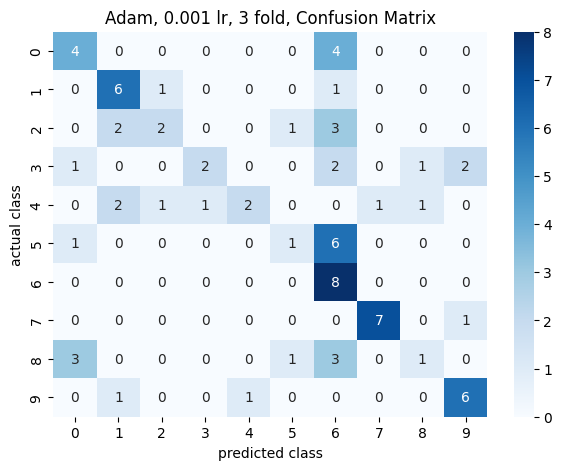

Adam, 0.001 lr, 3 fold, Overall F1 Score: 0.4564434816988996


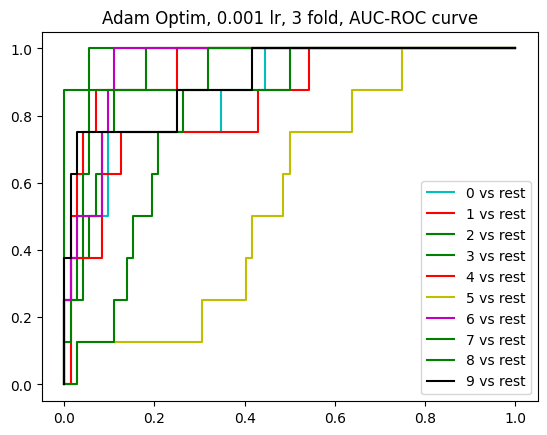

100%|██████████| 80/80 [00:00<00:00, 17514.58it/s]


Adam, 0.001 lr, 4 fold, Epoch 10/100, Training Loss: 2.0178258270025253, Training Accuracy: 50.0
Adam, 0.001 lr, 4 fold, Epoch 10/100, Validation Loss: 2.0555107593536377, Validation Accuracy: 43.75
Adam, 0.001 lr, 4 fold, Epoch 20/100, Training Loss: 1.8405484557151794, Training Accuracy: 69.16666666666667
Adam, 0.001 lr, 4 fold, Epoch 20/100, Validation Loss: 1.9445459445317586, Validation Accuracy: 55.0
Adam, 0.001 lr, 4 fold, Epoch 30/100, Training Loss: 1.752070114016533, Training Accuracy: 75.0
Adam, 0.001 lr, 4 fold, Epoch 30/100, Validation Loss: 1.9138162930806477, Validation Accuracy: 53.75
Adam, 0.001 lr, 4 fold, Epoch 40/100, Training Loss: 1.6559972614049911, Training Accuracy: 83.33333333333333
Adam, 0.001 lr, 4 fold, Epoch 40/100, Validation Loss: 1.926630934079488, Validation Accuracy: 48.75
Adam, 0.001 lr, 4 fold, Epoch 50/100, Training Loss: 1.6097008883953094, Training Accuracy: 87.91666666666667
Adam, 0.001 lr, 4 fold, Epoch 50/100, Validation Loss: 1.90980720520019

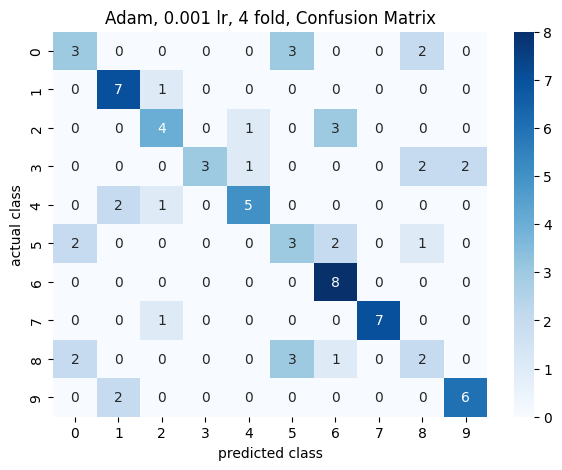

Adam, 0.001 lr, 4 fold, Overall F1 Score: 0.5912510554461019


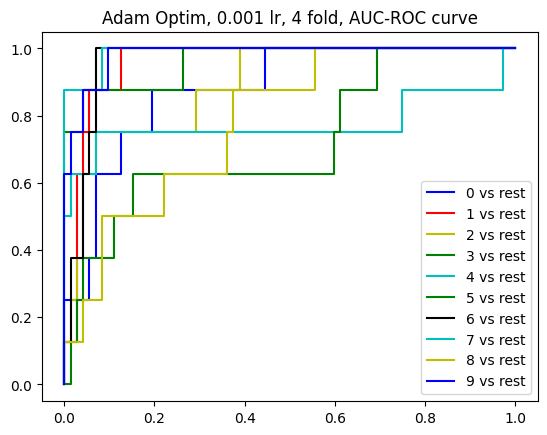

100%|██████████| 80/80 [00:00<00:00, 16464.39it/s]


Adam, 0.001 lr, 5 fold, Epoch 10/100, Training Loss: 2.060211956501007, Training Accuracy: 45.833333333333336
Adam, 0.001 lr, 5 fold, Epoch 10/100, Validation Loss: 2.1189862887064614, Validation Accuracy: 35.0
Adam, 0.001 lr, 5 fold, Epoch 20/100, Training Loss: 1.9338921308517456, Training Accuracy: 55.0
Adam, 0.001 lr, 5 fold, Epoch 20/100, Validation Loss: 2.0456851720809937, Validation Accuracy: 40.0
Adam, 0.001 lr, 5 fold, Epoch 30/100, Training Loss: 1.8107797503471375, Training Accuracy: 69.58333333333333
Adam, 0.001 lr, 5 fold, Epoch 30/100, Validation Loss: 1.9521483182907104, Validation Accuracy: 52.5
Adam, 0.001 lr, 5 fold, Epoch 40/100, Training Loss: 1.777734249830246, Training Accuracy: 72.5
Adam, 0.001 lr, 5 fold, Epoch 40/100, Validation Loss: 1.8403087854385376, Validation Accuracy: 67.5
Adam, 0.001 lr, 5 fold, Epoch 50/100, Training Loss: 1.6316838413476944, Training Accuracy: 87.91666666666667
Adam, 0.001 lr, 5 fold, Epoch 50/100, Validation Loss: 1.8190134366353352

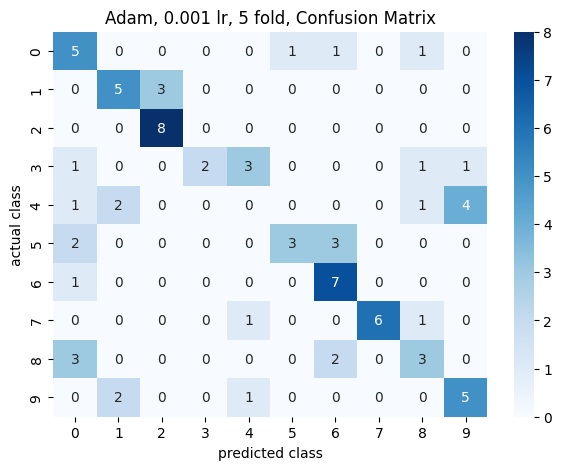

Adam, 0.001 lr, 5 fold, Overall F1 Score: 0.5285896112831098


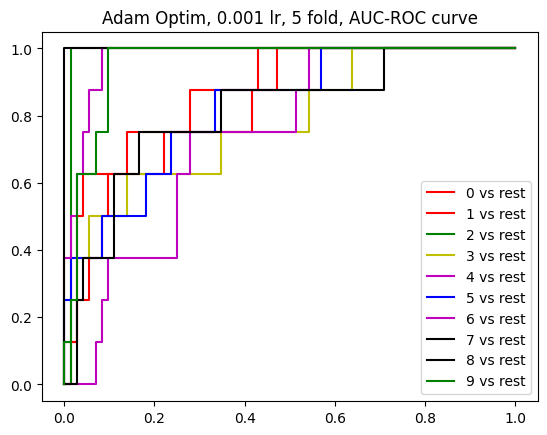

Adam, 0.001 lr, Mean validation accuracy: 56.25
Adam, 0.001 lr, Best test accuracy: 60.0


100%|██████████| 80/80 [00:00<00:00, 15870.98it/s]


Adam, 0.05 lr, 2 fold, Epoch 10/100, Training Loss: 2.3634946048259735, Training Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 10/100, Validation Loss: 2.377817471822103, Validation Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 20/100, Training Loss: 2.3595883548259735, Training Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 20/100, Validation Loss: 2.377817471822103, Validation Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 30/100, Training Loss: 2.3517758548259735, Training Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 30/100, Validation Loss: 2.377817471822103, Validation Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 40/100, Training Loss: 2.3595883548259735, Training Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 40/100, Validation Loss: 2.377817471822103, Validation Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 50/100, Training Loss: 2.3674008548259735, Training Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 50/100, Validation Loss: 2.377817471822103, Validation Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Ep

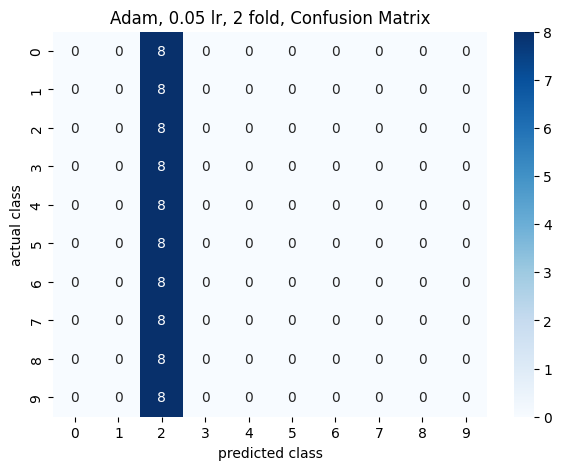

Adam, 0.05 lr, 2 fold, Overall F1 Score: 0.01818181818181818


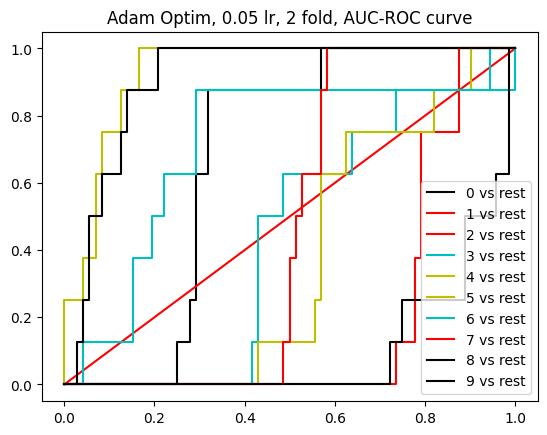

100%|██████████| 80/80 [00:00<00:00, 17278.29it/s]


Adam, 0.05 lr, 3 fold, Epoch 10/100, Training Loss: 2.3371683061122894, Training Accuracy: 7.916666666666667
Adam, 0.05 lr, 3 fold, Epoch 10/100, Validation Loss: 2.345137437184652, Validation Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 20/100, Training Loss: 2.355166584253311, Training Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 20/100, Validation Loss: 2.3771399656931558, Validation Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 30/100, Training Loss: 2.3280812203884125, Training Accuracy: 8.333333333333334
Adam, 0.05 lr, 3 fold, Epoch 30/100, Validation Loss: 2.3360597292582193, Validation Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 40/100, Training Loss: 2.3174230754375458, Training Accuracy: 10.833333333333334
Adam, 0.05 lr, 3 fold, Epoch 40/100, Validation Loss: 2.321896235148112, Validation Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 50/100, Training Loss: 2.366918593645096, Training Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 50/100, Validation Loss: 2.3771918614705405, Validation

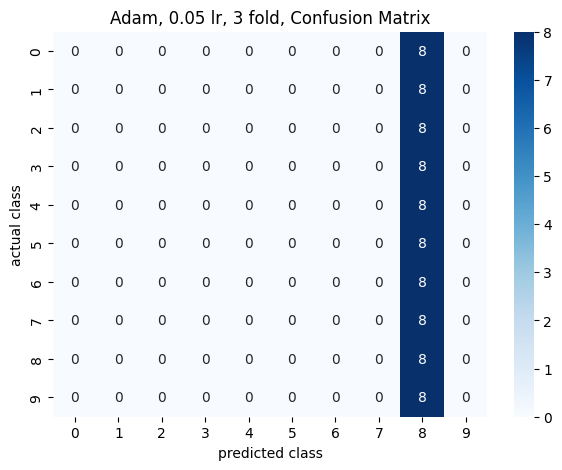

Adam, 0.05 lr, 3 fold, Overall F1 Score: 0.01818181818181818


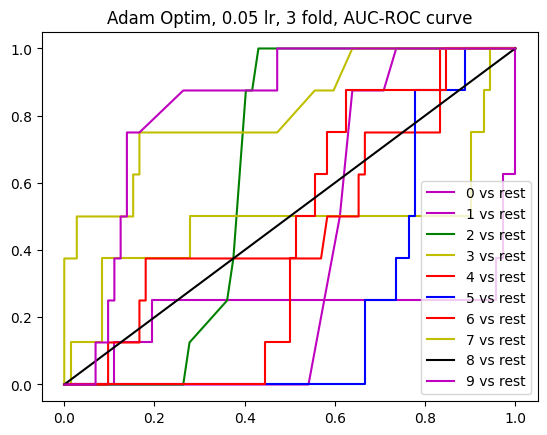

100%|██████████| 80/80 [00:00<00:00, 16997.33it/s]


Adam, 0.05 lr, 4 fold, Epoch 10/100, Training Loss: 2.3517448604106903, Training Accuracy: 10.0
Adam, 0.05 lr, 4 fold, Epoch 10/100, Validation Loss: 2.3256868521372476, Validation Accuracy: 10.0
Adam, 0.05 lr, 4 fold, Epoch 20/100, Training Loss: 2.3157554864883423, Training Accuracy: 9.583333333333334
Adam, 0.05 lr, 4 fold, Epoch 20/100, Validation Loss: 2.3079380989074707, Validation Accuracy: 10.0
Adam, 0.05 lr, 4 fold, Epoch 30/100, Training Loss: 2.344916135072708, Training Accuracy: 10.0
Adam, 0.05 lr, 4 fold, Epoch 30/100, Validation Loss: 2.298830986022949, Validation Accuracy: 10.0
Adam, 0.05 lr, 4 fold, Epoch 40/100, Training Loss: 2.332585096359253, Training Accuracy: 10.833333333333334
Adam, 0.05 lr, 4 fold, Epoch 40/100, Validation Loss: 2.322985887527466, Validation Accuracy: 10.0
Adam, 0.05 lr, 4 fold, Epoch 50/100, Training Loss: 2.3556821048259735, Training Accuracy: 10.0
Adam, 0.05 lr, 4 fold, Epoch 50/100, Validation Loss: 2.3569841384887695, Validation Accuracy: 10

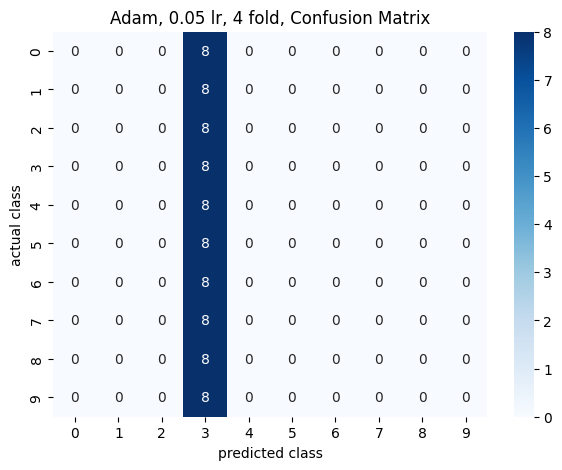

Adam, 0.05 lr, 4 fold, Overall F1 Score: 0.01818181818181818


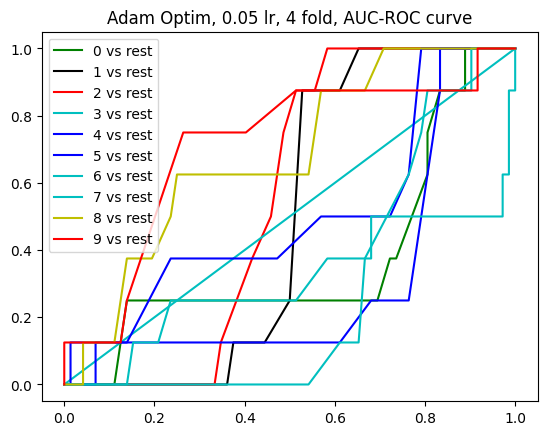

100%|██████████| 80/80 [00:00<00:00, 16134.27it/s]


Adam, 0.05 lr, 5 fold, Epoch 10/100, Training Loss: 2.3781938552856445, Training Accuracy: 7.916666666666667
Adam, 0.05 lr, 5 fold, Epoch 10/100, Validation Loss: 2.367400805155436, Validation Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 20/100, Training Loss: 2.3595800697803497, Training Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 20/100, Validation Loss: 2.3673866589864097, Validation Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 30/100, Training Loss: 2.3634946048259735, Training Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 30/100, Validation Loss: 2.3569841384887695, Validation Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 40/100, Training Loss: 2.3634946048259735, Training Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 40/100, Validation Loss: 2.3569841384887695, Validation Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 50/100, Training Loss: 2.3595883548259735, Training Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 50/100, Validation Loss: 2.3569841384887695, Validation Accuracy: 10.0
Adam, 0.

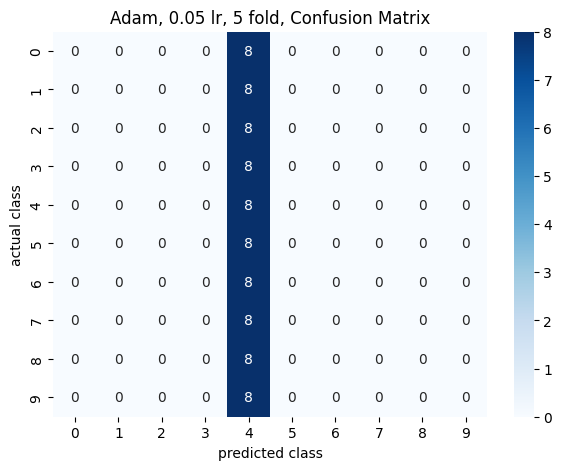

Adam, 0.05 lr, 5 fold, Overall F1 Score: 0.01818181818181818


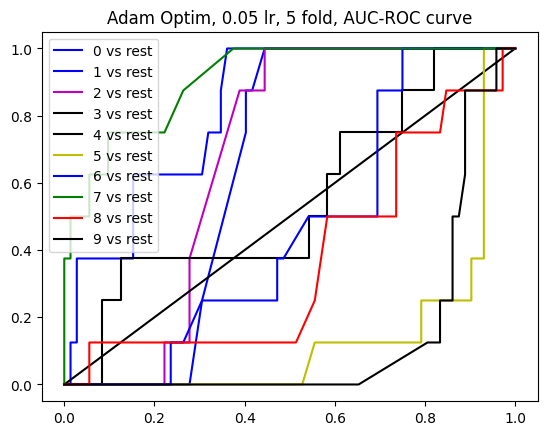

Adam, 0.05 lr, Mean validation accuracy: 10.0
Adam, 0.05 lr, Best test accuracy: 10.0


100%|██████████| 80/80 [00:00<00:00, 16269.60it/s]


SGD, 0.001 lr, 2 fold, Epoch 10/100, Training Loss: 2.303998291492462, Training Accuracy: 10.0
SGD, 0.001 lr, 2 fold, Epoch 10/100, Validation Loss: 2.3061060905456543, Validation Accuracy: 10.0
SGD, 0.001 lr, 2 fold, Epoch 20/100, Training Loss: 2.3050995767116547, Training Accuracy: 10.0
SGD, 0.001 lr, 2 fold, Epoch 20/100, Validation Loss: 2.305438756942749, Validation Accuracy: 10.0
SGD, 0.001 lr, 2 fold, Epoch 30/100, Training Loss: 2.3033923506736755, Training Accuracy: 10.0
SGD, 0.001 lr, 2 fold, Epoch 30/100, Validation Loss: 2.3048530419667563, Validation Accuracy: 10.0
SGD, 0.001 lr, 2 fold, Epoch 40/100, Training Loss: 2.3034738302230835, Training Accuracy: 10.0
SGD, 0.001 lr, 2 fold, Epoch 40/100, Validation Loss: 2.3043341636657715, Validation Accuracy: 10.0
SGD, 0.001 lr, 2 fold, Epoch 50/100, Training Loss: 2.3033775091171265, Training Accuracy: 10.0
SGD, 0.001 lr, 2 fold, Epoch 50/100, Validation Loss: 2.303819179534912, Validation Accuracy: 10.0
SGD, 0.001 lr, 2 fold, 

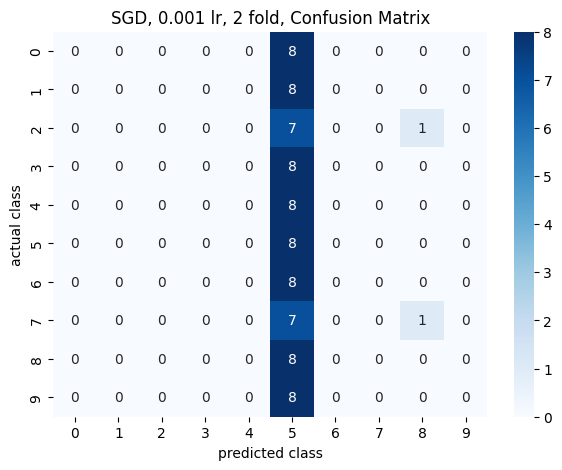

SGD, 0.001 lr, 2 fold, Overall F1 Score: 0.018604651162790694


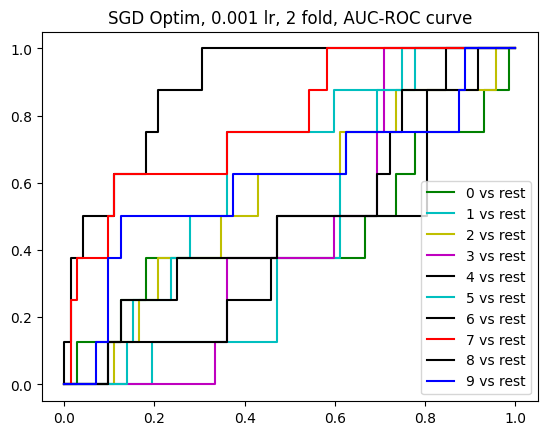

100%|██████████| 80/80 [00:00<00:00, 16938.98it/s]


SGD, 0.001 lr, 3 fold, Epoch 10/100, Training Loss: 2.3008773624897003, Training Accuracy: 10.0
SGD, 0.001 lr, 3 fold, Epoch 10/100, Validation Loss: 2.3064252535502114, Validation Accuracy: 11.25
SGD, 0.001 lr, 3 fold, Epoch 20/100, Training Loss: 2.3024481534957886, Training Accuracy: 10.0
SGD, 0.001 lr, 3 fold, Epoch 20/100, Validation Loss: 2.306138038635254, Validation Accuracy: 11.25
SGD, 0.001 lr, 3 fold, Epoch 30/100, Training Loss: 2.3018883168697357, Training Accuracy: 10.0
SGD, 0.001 lr, 3 fold, Epoch 30/100, Validation Loss: 2.3058390617370605, Validation Accuracy: 10.0
SGD, 0.001 lr, 3 fold, Epoch 40/100, Training Loss: 2.299044579267502, Training Accuracy: 10.0
SGD, 0.001 lr, 3 fold, Epoch 40/100, Validation Loss: 2.3056207497914634, Validation Accuracy: 10.0
SGD, 0.001 lr, 3 fold, Epoch 50/100, Training Loss: 2.300842136144638, Training Accuracy: 10.416666666666666
SGD, 0.001 lr, 3 fold, Epoch 50/100, Validation Loss: 2.3053606351216636, Validation Accuracy: 10.0
SGD, 0.

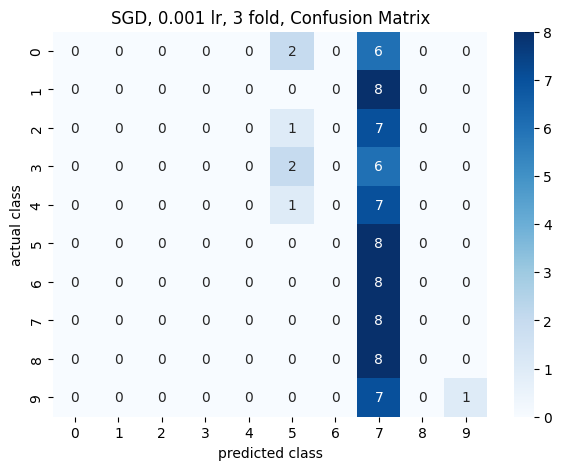

SGD, 0.001 lr, 3 fold, Overall F1 Score: 0.04197530864197531


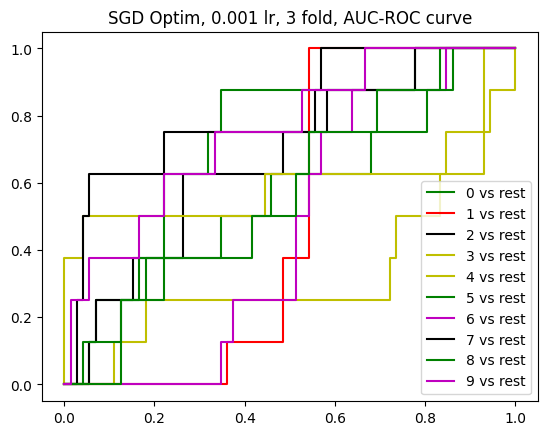

100%|██████████| 80/80 [00:00<00:00, 17518.24it/s]


SGD, 0.001 lr, 4 fold, Epoch 10/100, Training Loss: 2.304551750421524, Training Accuracy: 10.0
SGD, 0.001 lr, 4 fold, Epoch 10/100, Validation Loss: 2.3074007829030356, Validation Accuracy: 10.0
SGD, 0.001 lr, 4 fold, Epoch 20/100, Training Loss: 2.304851472377777, Training Accuracy: 10.0
SGD, 0.001 lr, 4 fold, Epoch 20/100, Validation Loss: 2.3067848682403564, Validation Accuracy: 10.0
SGD, 0.001 lr, 4 fold, Epoch 30/100, Training Loss: 2.302732467651367, Training Accuracy: 10.0
SGD, 0.001 lr, 4 fold, Epoch 30/100, Validation Loss: 2.306182940800985, Validation Accuracy: 10.0
SGD, 0.001 lr, 4 fold, Epoch 40/100, Training Loss: 2.3040035367012024, Training Accuracy: 10.0
SGD, 0.001 lr, 4 fold, Epoch 40/100, Validation Loss: 2.3057411511739097, Validation Accuracy: 10.0
SGD, 0.001 lr, 4 fold, Epoch 50/100, Training Loss: 2.3041387498378754, Training Accuracy: 10.0
SGD, 0.001 lr, 4 fold, Epoch 50/100, Validation Loss: 2.3053219318389893, Validation Accuracy: 10.0
SGD, 0.001 lr, 4 fold, E

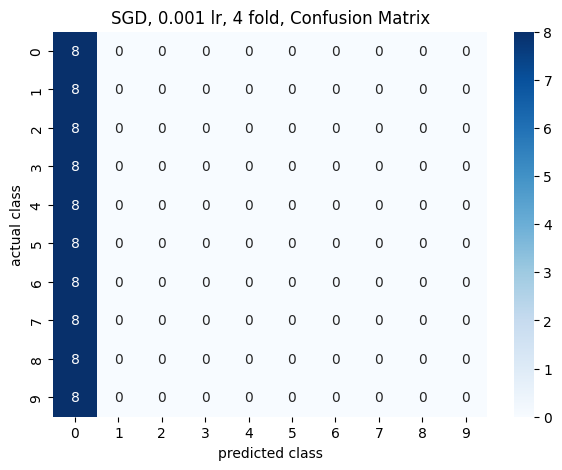

SGD, 0.001 lr, 4 fold, Overall F1 Score: 0.01818181818181818


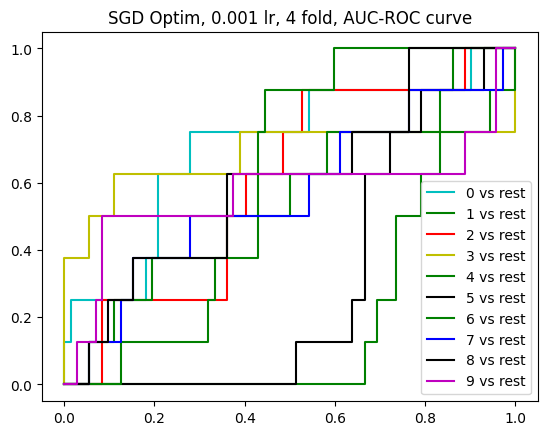

100%|██████████| 80/80 [00:00<00:00, 16897.19it/s]


SGD, 0.001 lr, 5 fold, Epoch 10/100, Training Loss: 2.305210828781128, Training Accuracy: 10.0
SGD, 0.001 lr, 5 fold, Epoch 10/100, Validation Loss: 2.3083202044169107, Validation Accuracy: 10.0
SGD, 0.001 lr, 5 fold, Epoch 20/100, Training Loss: 2.3064036071300507, Training Accuracy: 10.0
SGD, 0.001 lr, 5 fold, Epoch 20/100, Validation Loss: 2.307887315750122, Validation Accuracy: 10.0
SGD, 0.001 lr, 5 fold, Epoch 30/100, Training Loss: 2.3060116469860077, Training Accuracy: 10.0
SGD, 0.001 lr, 5 fold, Epoch 30/100, Validation Loss: 2.3075238863627114, Validation Accuracy: 10.0
SGD, 0.001 lr, 5 fold, Epoch 40/100, Training Loss: 2.306057095527649, Training Accuracy: 10.0
SGD, 0.001 lr, 5 fold, Epoch 40/100, Validation Loss: 2.3072401682535806, Validation Accuracy: 10.0
SGD, 0.001 lr, 5 fold, Epoch 50/100, Training Loss: 2.304489016532898, Training Accuracy: 10.0
SGD, 0.001 lr, 5 fold, Epoch 50/100, Validation Loss: 2.30692466100057, Validation Accuracy: 10.0
SGD, 0.001 lr, 5 fold, Epo

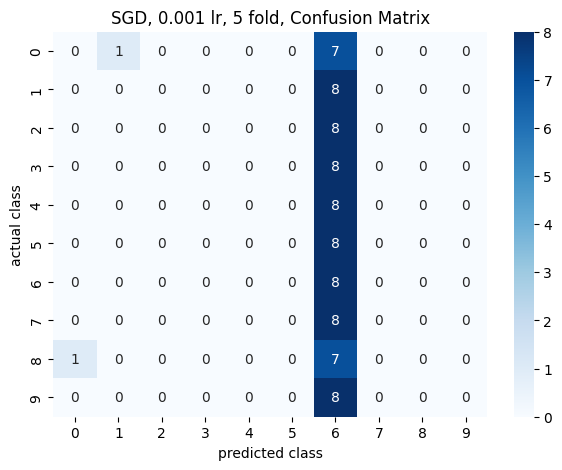

SGD, 0.001 lr, 5 fold, Overall F1 Score: 0.018604651162790694


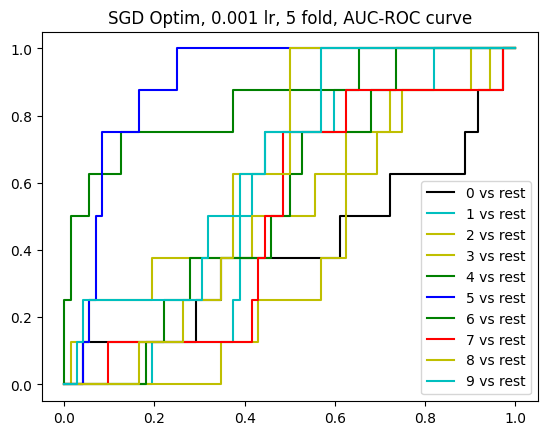

SGD, 0.001 lr, Mean validation accuracy: 10.3125
SGD, 0.001 lr, Best test accuracy: 11.25


100%|██████████| 80/80 [00:00<00:00, 14466.23it/s]


SGD, 0.05 lr, 2 fold, Epoch 10/100, Training Loss: 2.2159024477005005, Training Accuracy: 26.25
SGD, 0.05 lr, 2 fold, Epoch 10/100, Validation Loss: 2.194917599360148, Validation Accuracy: 30.0
SGD, 0.05 lr, 2 fold, Epoch 20/100, Training Loss: 2.1144986748695374, Training Accuracy: 38.333333333333336
SGD, 0.05 lr, 2 fold, Epoch 20/100, Validation Loss: 2.1049369970957437, Validation Accuracy: 33.75
SGD, 0.05 lr, 2 fold, Epoch 30/100, Training Loss: 2.068548947572708, Training Accuracy: 40.0
SGD, 0.05 lr, 2 fold, Epoch 30/100, Validation Loss: 2.115297238032023, Validation Accuracy: 32.5
SGD, 0.05 lr, 2 fold, Epoch 40/100, Training Loss: 2.0396820306777954, Training Accuracy: 45.833333333333336
SGD, 0.05 lr, 2 fold, Epoch 40/100, Validation Loss: 2.0591963132222495, Validation Accuracy: 41.25
SGD, 0.05 lr, 2 fold, Epoch 50/100, Training Loss: 1.9784842282533646, Training Accuracy: 50.0
SGD, 0.05 lr, 2 fold, Epoch 50/100, Validation Loss: 2.0406566858291626, Validation Accuracy: 41.25
S

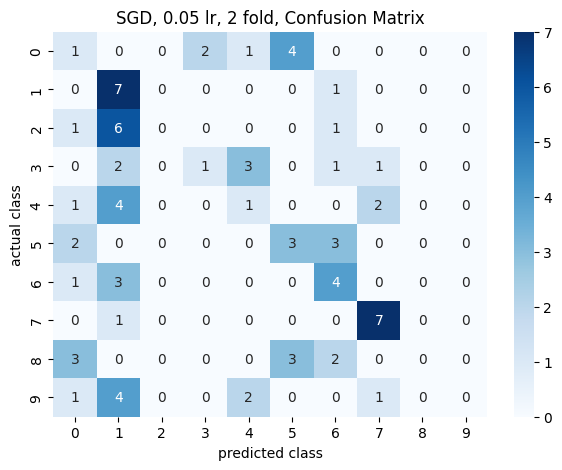

SGD, 0.05 lr, 2 fold, Overall F1 Score: 0.22964380648591173


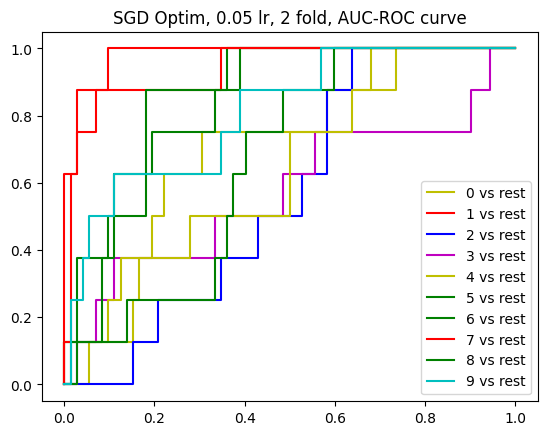

100%|██████████| 80/80 [00:00<00:00, 16090.94it/s]


SGD, 0.05 lr, 3 fold, Epoch 10/100, Training Loss: 2.2997657656669617, Training Accuracy: 17.083333333333332
SGD, 0.05 lr, 3 fold, Epoch 10/100, Validation Loss: 2.302694400151571, Validation Accuracy: 17.5
SGD, 0.05 lr, 3 fold, Epoch 20/100, Training Loss: 2.2400271594524384, Training Accuracy: 21.25
SGD, 0.05 lr, 3 fold, Epoch 20/100, Validation Loss: 2.2577080726623535, Validation Accuracy: 17.5
SGD, 0.05 lr, 3 fold, Epoch 30/100, Training Loss: 2.1639822721481323, Training Accuracy: 35.0
SGD, 0.05 lr, 3 fold, Epoch 30/100, Validation Loss: 2.196326494216919, Validation Accuracy: 28.75
SGD, 0.05 lr, 3 fold, Epoch 40/100, Training Loss: 2.093668580055237, Training Accuracy: 41.25
SGD, 0.05 lr, 3 fold, Epoch 40/100, Validation Loss: 2.1539928118387857, Validation Accuracy: 27.5
SGD, 0.05 lr, 3 fold, Epoch 50/100, Training Loss: 2.015440911054611, Training Accuracy: 50.416666666666664
SGD, 0.05 lr, 3 fold, Epoch 50/100, Validation Loss: 2.116067806879679, Validation Accuracy: 28.75
SGD

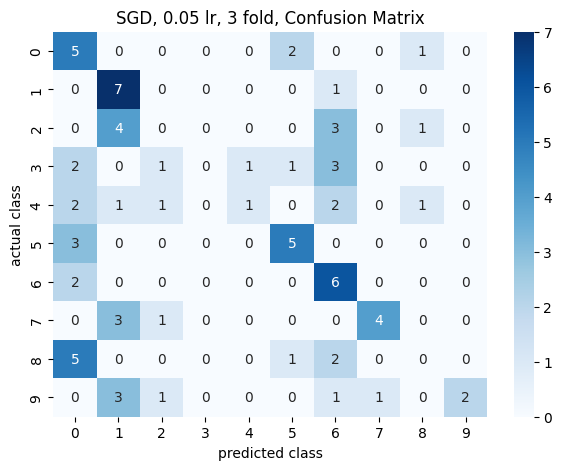

SGD, 0.05 lr, 3 fold, Overall F1 Score: 0.31739902798726327


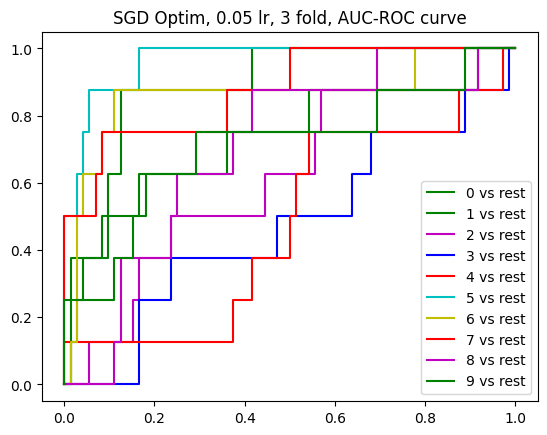

100%|██████████| 80/80 [00:00<00:00, 16279.08it/s]


SGD, 0.05 lr, 4 fold, Epoch 10/100, Training Loss: 2.2276566922664642, Training Accuracy: 24.166666666666668
SGD, 0.05 lr, 4 fold, Epoch 10/100, Validation Loss: 2.2174402872721353, Validation Accuracy: 26.25
SGD, 0.05 lr, 4 fold, Epoch 20/100, Training Loss: 2.129903107881546, Training Accuracy: 35.416666666666664
SGD, 0.05 lr, 4 fold, Epoch 20/100, Validation Loss: 2.1799588998158774, Validation Accuracy: 33.75
SGD, 0.05 lr, 4 fold, Epoch 30/100, Training Loss: 2.063731849193573, Training Accuracy: 40.833333333333336
SGD, 0.05 lr, 4 fold, Epoch 30/100, Validation Loss: 2.1055796146392822, Validation Accuracy: 41.25
SGD, 0.05 lr, 4 fold, Epoch 40/100, Training Loss: 2.0361498445272446, Training Accuracy: 45.416666666666664
SGD, 0.05 lr, 4 fold, Epoch 40/100, Validation Loss: 2.0868258476257324, Validation Accuracy: 41.25
SGD, 0.05 lr, 4 fold, Epoch 50/100, Training Loss: 1.9877529740333557, Training Accuracy: 55.416666666666664
SGD, 0.05 lr, 4 fold, Epoch 50/100, Validation Loss: 2.08

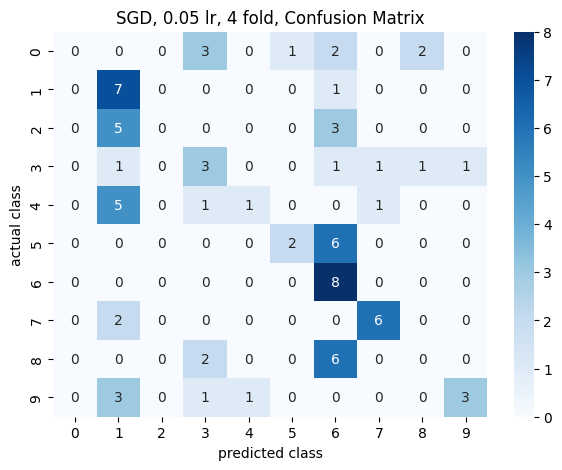

SGD, 0.05 lr, 4 fold, Overall F1 Score: 0.3055725457338361


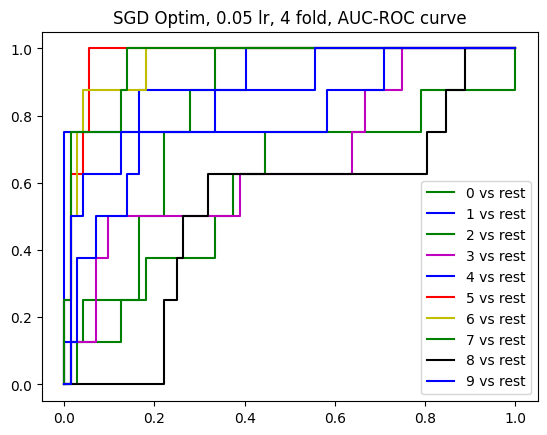

100%|██████████| 80/80 [00:00<00:00, 17177.45it/s]


SGD, 0.05 lr, 5 fold, Epoch 10/100, Training Loss: 2.1787383258342743, Training Accuracy: 30.0
SGD, 0.05 lr, 5 fold, Epoch 10/100, Validation Loss: 2.156966209411621, Validation Accuracy: 31.25
SGD, 0.05 lr, 5 fold, Epoch 20/100, Training Loss: 2.109448254108429, Training Accuracy: 39.166666666666664
SGD, 0.05 lr, 5 fold, Epoch 20/100, Validation Loss: 2.090334415435791, Validation Accuracy: 32.5
SGD, 0.05 lr, 5 fold, Epoch 30/100, Training Loss: 2.0437899976968765, Training Accuracy: 44.583333333333336
SGD, 0.05 lr, 5 fold, Epoch 30/100, Validation Loss: 2.0836270252863565, Validation Accuracy: 37.5
SGD, 0.05 lr, 5 fold, Epoch 40/100, Training Loss: 1.9975284934043884, Training Accuracy: 52.5
SGD, 0.05 lr, 5 fold, Epoch 40/100, Validation Loss: 2.063920736312866, Validation Accuracy: 36.25
SGD, 0.05 lr, 5 fold, Epoch 50/100, Training Loss: 1.9790014773607254, Training Accuracy: 53.75
SGD, 0.05 lr, 5 fold, Epoch 50/100, Validation Loss: 2.10430113474528, Validation Accuracy: 37.5
SGD, 

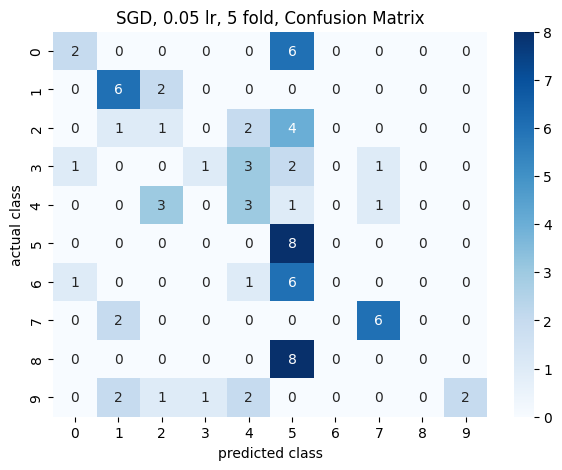

SGD, 0.05 lr, 5 fold, Overall F1 Score: 0.3136128110975112


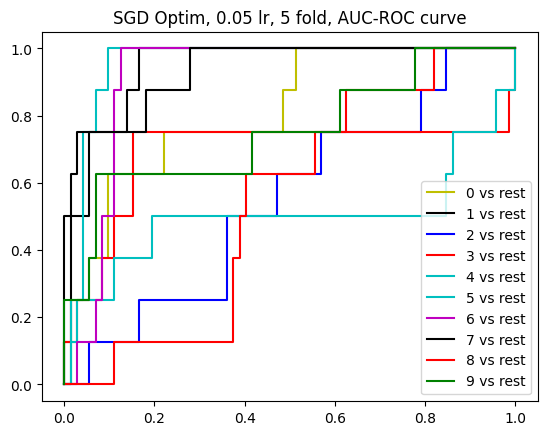

SGD, 0.05 lr, Mean validation accuracy: 38.75
SGD, 0.05 lr, Best test accuracy: 37.5


In [33]:
for optimizer_type in optimizers:
    for lr_type in learning_rates:

        all_test_accuracy = []
        all_validation_accuracy = []
        valid_samples = [2,3,4,5]

        for i in valid_samples:
            # Data Setup
            test_samp = 1 #Do not change this!!
            valid_samp = i # Use any value ranging from 2 to 5 for k-fold validation (valid_fold)
            batch_size = 32 # Free to change
            num_workers = 2 # Free to change
            custom_data_module = CustomDataModule(batch_size=batch_size,
                                                num_workers=num_workers,
                                                data_directory=path,
                                                data_frame=df,
                                                validation_fold=valid_samp,
                                                testing_fold=test_samp,  # set to 0 for no test set
                                                esc_10_flag=True,
                                                file_column='filename',
                                                label_column='category',
                                                sampling_rate=44100,
                                                new_sampling_rate=16000,  # new sample rate for input
                                                sample_length_seconds=1  # new length of input in seconds
                                                )

            custom_data_module.setup()

            # Hyperparameters
            num_classes = 10
            lr = lr_type
            epochs = 100
            # Model, Optimizer, Loss function
            model2 = Architecture2().to(device)
            # model2 = Architecture2()
            # optimizer = optim.Adam(model2.parameters(), lr=lr)
            if optimizer_type == 'Adam':
                optimizer = optim.Adam(model2.parameters(), lr=lr)
            elif optimizer_type == 'SGD':
                optimizer = optim.SGD(model2.parameters(), lr=lr)

            criterion = nn.CrossEntropyLoss()

            # WandB initialization
            wandb.init(project="Architecture2_model2_Head2_final_light", name=f"{optimizer_type}, {lr} lr, {i} fold")

            # Training loop
            train_acc_track = []
            val_acc_track = []
            train_loss_track = []
            val_loss_track = []

            for epoch in range(epochs):
                model2.train()
                running_loss = 0.0
                correct = 0
                total = 0

                for data, target in custom_data_module.train_dataloader():
                    data, target = data.to(device), target.to(device)
                    optimizer.zero_grad()
                    output = model2(data)
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()
                    _, predicted = output.max(1)

                    total += target.size(0)
                    correct += predicted.eq(target).sum().item()

                train_loss = running_loss / len(custom_data_module.train_dataloader())
                train_acc = 100. * correct / total

                train_loss_track.append(train_loss)
                train_acc_track.append(train_acc)

                if (epoch+1) % 10 == 0:
                    print(f'{optimizer_type}, {lr} lr, {i} fold, Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Training Accuracy: {train_acc}')
                # print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Training Accuracy: {train_acc}')

                # Validation
                model2.eval()
                val_loss = 0.0
                val_correct = 0
                val_total = 0

                with torch.no_grad():
                    for data, target in custom_data_module.val_dataloader():
                        data, target = data.to(device), target.to(device)
                        output = model2(data)
                        loss = criterion(output, target)
                        val_loss += loss.item()
                        _, predicted = output.max(1)

                        val_total += target.size(0)
                        val_correct += predicted.eq(target).sum().item()

                val_loss /= len(custom_data_module.val_dataloader())
                val_acc = 100. * val_correct / val_total

                val_loss_track.append(val_loss)
                val_acc_track.append(val_acc)

                if (epoch+1) % 10 == 0:
                    print(f'{optimizer_type}, {lr} lr, {i} fold, Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')
                # print(f'Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

                # # Logging
                wandb.log({"Train Loss": train_loss, "Train Accuracy": train_acc, "Validation Loss": val_loss, "Val Accuracy": val_acc, "Learning rate": lr, "Optimizer": optimizer_type})


            all_validation_accuracy.append(val_acc)

            # Testing
            model2.eval()
            test_correct = 0
            test_total = 0
            all_labels_test = []
            all_preds_test = []
            all_probabilities = []

            with torch.no_grad():
                for data, target in custom_data_module.test_dataloader():
                    data, target = data.to(device), target.to(device)
                    output = model2(data)
                    all_probabilities.extend(output.cpu().numpy())
                    _, predicted = output.max(1)
                    test_total += target.size(0)
                    test_correct += predicted.eq(target).sum().item()
                    all_labels_test.extend(target.cpu().numpy())
                    all_preds_test.extend(predicted.cpu().numpy())

            test_acc = 100. * test_correct / test_total
            print(f'{optimizer_type}, {lr} lr, {i} fold, Test Accuracy: {test_acc:.2f}%')
            # print(f'Test Accuracy: {test_acc:.2f}%')
            all_test_accuracy.append(test_acc)

            # Confusion Matrix for test set
            cm = confusion_matrix(all_labels_test, all_preds_test)
            plt.figure(figsize=(7, 5))
            sns.heatmap(cm, annot=True,fmt = 'd', cmap='Blues')
            plt.title(f'{optimizer_type}, {lr} lr, {i} fold, Confusion Matrix')
            # plt.title(f'Confusion Matrix')
            plt.xlabel("predicted class",size=10)
            plt.ylabel("actual class",size=10)
            # plt.show()

            # # Confusion Matrix
            # cm = wandb.plot.confusion_matrix(
            #     y_true = all_labels_test, preds = all_preds_test
            # )
            wandb.log({"Confusion Matrix": wandb.Image(plt)})
            plt.show()

            # Calculate overall F1 score
            overall_f1_score = f1_score(all_labels_test, all_preds_test, average='weighted')

            # print(f'Overall F1 Score: {overall_f1_score}')
            print(f'{optimizer_type}, {lr} lr, {i} fold, Overall F1 Score: {overall_f1_score}')

            wandb.summary["F1 score"] = overall_f1_score

            # roc curve for classes
            fpr = {}
            tpr = {}
            thresh ={}
            n_class = 10

            for j in range(n_class):
                fpr[j], tpr[j], thresh[j] = roc_curve(all_labels_test, np.array(all_probabilities)[:,j], pos_label=j)
                plt.plot(fpr[j], tpr[j], label = f'{j} vs rest',color = np.random.choice(['r','g','b','y','c','m','k']))
            plt.legend()
            # plt.title("AUC-ROC curve")
            plt.title(f'{optimizer_type} Optim, {lr} lr, {i} fold, AUC-ROC curve')


            # # roc curve for classes
            # roc_curves = {}
            # n_class = 10  # Assuming you have 10 classes, adjust accordingly

            # for j in range(n_class):
            #     fpr[j], tpr[j], _ = roc_curve(all_labels_test, np.array(all_probabilities)[:, j], pos_label=j)
            #     roc_curves[j] = {"fpr": fpr[j], "tpr": tpr[j]}

            wandb.log({"ROC curve": wandb.Image(plt)})
            plt.show()

            wandb.summary["Test accuracy"] = test_acc
            wandb.finish()

        print(f'{optimizer_type}, {lr} lr, Mean validation accuracy: {mean(all_validation_accuracy)}')
        print(f'{optimizer_type}, {lr} lr, Best test accuracy: {max(all_test_accuracy)}')

In [34]:
#Architecture2 - Model2 - Head =4

In [35]:
class Architecture2(nn.Module):
    def __init__(self):
        super(Architecture2, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(16)  # BatchNorm1d after first conv layer
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(32)  # BatchNorm1d after second conv layer
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)  # BatchNorm1d after third conv layer
        self.conv4 = nn.Conv1d(64, 48, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(48)
        self.ad1 = nn.AdaptiveAvgPool2d((47, 48))
        # self.conv5 = nn.Conv1d(48, 16, kernel_size=3, stride=1, padding=1)
        # self.bn5 = nn.BatchNorm1d(16)
        self.fc1 = nn.Linear(48, 48)
        self.fc2 = nn.Linear(48, 48)
        self.fc3= nn.Linear(48, 10)
        # self.fc3 = nn.Linear(2250, 10)

        self.multi_head_self_attention = multi_head_self_attention(48, 4)
        self.multi_head_self_attention2 = multi_head_self_attention(48, 4)
        self.attention_blocks = [(self.multi_head_self_attention, self.fc1),(self.multi_head_self_attention2, self.fc2) ]

    def forward(self, x):
        # x=x.float()
        x = F.max_pool1d(F.relu(self.bn1(self.conv1(x))), 12)
        x = F.max_pool1d(F.relu(self.bn2(self.conv2(x))), 8)
        x = F.max_pool1d(F.relu(self.bn3(self.conv3(x))), 4)
        x = F.max_pool1d(F.relu(self.bn4(self.conv4(x))), 2)
        x = self.ad1(x)
        # x = F.max_pool1d(F.relu(self.bn5(self.conv5(x))), 16)
        # x = x.view(x.size(0), -1)
        # x = F.relu(self.fc1(x))  # Add ReLU after fc1
        # x = F.relu(self.fc2(x))  # Add ReLU after fc2
        # x = F.softmax(self.fc2(x), dim=1)  # Apply softmax on final layer

        # print(x.shape)
        self.cls_token = nn.Parameter(torch.zeros(1, 48).to(device))
        x = torch.cat((self.cls_token.expand(x.size(0), 1, -1), x), dim=1)
        x = x.to(device)
        # x = torch.cat((cls_token,x), dim=1)
        # print(x.shape)

        #Multi-head self attention
        for blocks in self.attention_blocks:

            #Positional encoding
            x = x + torch.tensor(self.getPositionEncoding(48, 48),dtype = x.dtype).to(device)

            multihead = blocks[0]
            fc = blocks[1]

            y = multihead(x)
            x = x + y

            #layer norm
            x = self.layer_normalization(x)

            #mlp
            y = fc(x)#self.mlp_layer(x)
            x = x + y

            #layer norm
            x = self.layer_normalization(x)

        #final mlp layer for classification
        x = torch.flatten(x[:,0],1)
        # x = self.fc2(x)#self.mlp_layer_final(x)
        x = F.softmax(self.fc3(x), dim=1)  # Apply softmax on final layer

        # print(x.shape)
        return x

    def getPositionEncoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(0,seq_len-1):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k+1, 2*i] = np.sin(k/denominator)
                P[k+1, 2*i+1] = np.cos(k/denominator)
        return P

    def layer_normalization(self, x, eps=1e-6):
        mean = torch.mean(x, dim=-1, keepdim=True)
        std = torch.std(x, dim=-1, keepdim=True) + eps
        return (x - mean) / std

In [36]:
learning_rates = [0.001, 0.05]
optimizers = ['Adam', 'SGD']

100%|██████████| 80/80 [00:00<00:00, 16067.05it/s]


Adam, 0.001 lr, 2 fold, Epoch 10/100, Training Loss: 2.019038215279579, Training Accuracy: 50.416666666666664
Adam, 0.001 lr, 2 fold, Epoch 10/100, Validation Loss: 2.0607533057530723, Validation Accuracy: 40.0
Adam, 0.001 lr, 2 fold, Epoch 20/100, Training Loss: 1.8424775153398514, Training Accuracy: 63.75
Adam, 0.001 lr, 2 fold, Epoch 20/100, Validation Loss: 2.0025829474131265, Validation Accuracy: 40.0
Adam, 0.001 lr, 2 fold, Epoch 30/100, Training Loss: 1.8132265508174896, Training Accuracy: 68.75
Adam, 0.001 lr, 2 fold, Epoch 30/100, Validation Loss: 1.9880877335866292, Validation Accuracy: 48.75
Adam, 0.001 lr, 2 fold, Epoch 40/100, Training Loss: 1.775270700454712, Training Accuracy: 69.58333333333333
Adam, 0.001 lr, 2 fold, Epoch 40/100, Validation Loss: 1.988051176071167, Validation Accuracy: 42.5
Adam, 0.001 lr, 2 fold, Epoch 50/100, Training Loss: 1.691435620188713, Training Accuracy: 79.58333333333333
Adam, 0.001 lr, 2 fold, Epoch 50/100, Validation Loss: 1.964624484380086

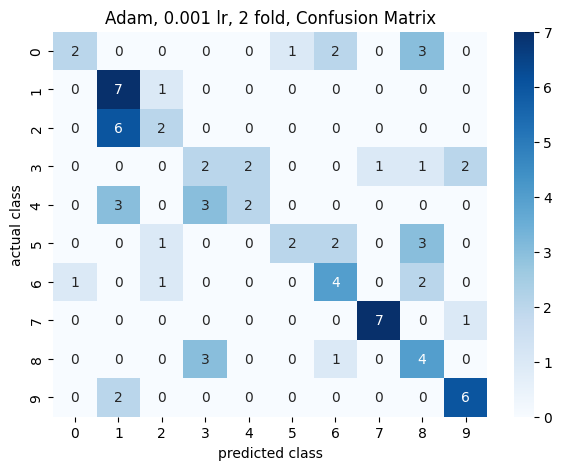

Adam, 0.001 lr, 2 fold, Overall F1 Score: 0.4589182875947582


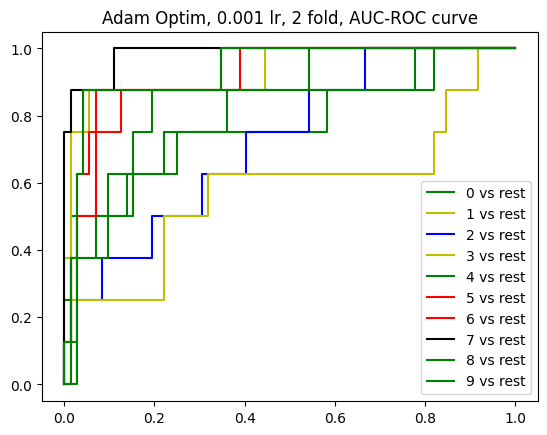

100%|██████████| 80/80 [00:00<00:00, 16242.04it/s]


Adam, 0.001 lr, 3 fold, Epoch 10/100, Training Loss: 2.012162446975708, Training Accuracy: 45.833333333333336
Adam, 0.001 lr, 3 fold, Epoch 10/100, Validation Loss: 2.10392689704895, Validation Accuracy: 35.0
Adam, 0.001 lr, 3 fold, Epoch 20/100, Training Loss: 1.824960932135582, Training Accuracy: 71.66666666666667
Adam, 0.001 lr, 3 fold, Epoch 20/100, Validation Loss: 1.9975202878316243, Validation Accuracy: 43.75
Adam, 0.001 lr, 3 fold, Epoch 30/100, Training Loss: 1.6645575612783432, Training Accuracy: 84.58333333333333
Adam, 0.001 lr, 3 fold, Epoch 30/100, Validation Loss: 1.8979814847310383, Validation Accuracy: 56.25
Adam, 0.001 lr, 3 fold, Epoch 40/100, Training Loss: 1.5844450294971466, Training Accuracy: 90.83333333333333
Adam, 0.001 lr, 3 fold, Epoch 40/100, Validation Loss: 1.931702693303426, Validation Accuracy: 51.25
Adam, 0.001 lr, 3 fold, Epoch 50/100, Training Loss: 1.5758267641067505, Training Accuracy: 91.66666666666667
Adam, 0.001 lr, 3 fold, Epoch 50/100, Validatio

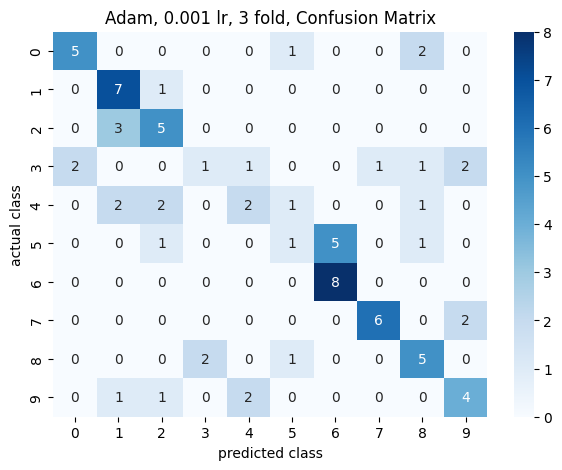

Adam, 0.001 lr, 3 fold, Overall F1 Score: 0.5162526362526363


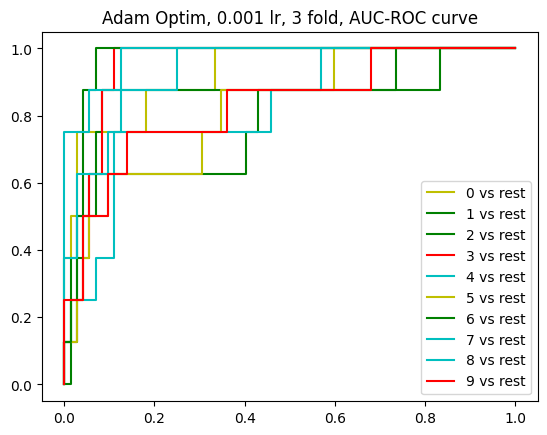

100%|██████████| 80/80 [00:00<00:00, 15262.42it/s]


Adam, 0.001 lr, 4 fold, Epoch 10/100, Training Loss: 2.02470925450325, Training Accuracy: 46.25
Adam, 0.001 lr, 4 fold, Epoch 10/100, Validation Loss: 2.1032046476999917, Validation Accuracy: 38.75
Adam, 0.001 lr, 4 fold, Epoch 20/100, Training Loss: 1.862764060497284, Training Accuracy: 67.08333333333333
Adam, 0.001 lr, 4 fold, Epoch 20/100, Validation Loss: 2.0503059228261313, Validation Accuracy: 43.75
Adam, 0.001 lr, 4 fold, Epoch 30/100, Training Loss: 1.7065510898828506, Training Accuracy: 77.91666666666667
Adam, 0.001 lr, 4 fold, Epoch 30/100, Validation Loss: 1.9181512594223022, Validation Accuracy: 53.75
Adam, 0.001 lr, 4 fold, Epoch 40/100, Training Loss: 1.6601109057664871, Training Accuracy: 83.33333333333333
Adam, 0.001 lr, 4 fold, Epoch 40/100, Validation Loss: 1.9524918397267659, Validation Accuracy: 53.75
Adam, 0.001 lr, 4 fold, Epoch 50/100, Training Loss: 1.614883154630661, Training Accuracy: 88.33333333333333
Adam, 0.001 lr, 4 fold, Epoch 50/100, Validation Loss: 1.9

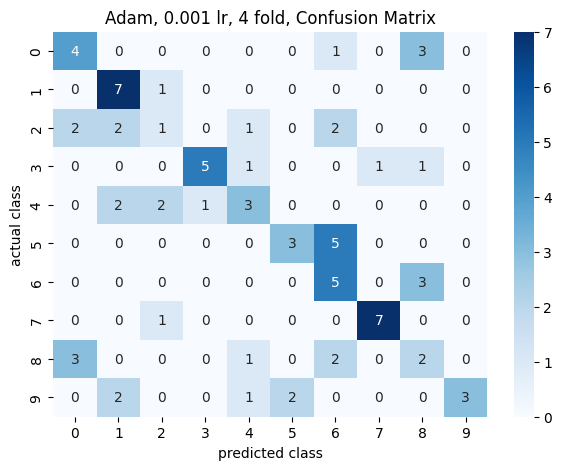

Adam, 0.001 lr, 4 fold, Overall F1 Score: 0.49574565034283696


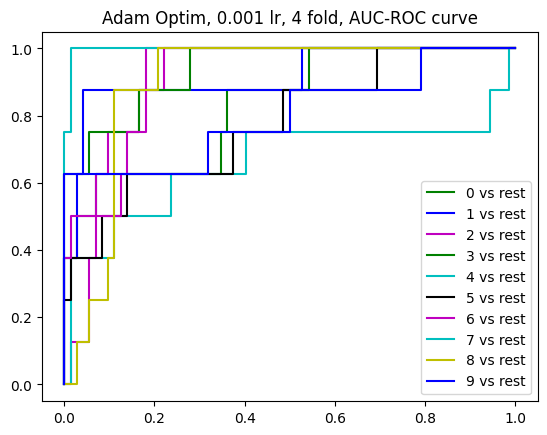

100%|██████████| 80/80 [00:00<00:00, 16974.97it/s]


Adam, 0.001 lr, 5 fold, Epoch 10/100, Training Loss: 1.9830577224493027, Training Accuracy: 53.333333333333336
Adam, 0.001 lr, 5 fold, Epoch 10/100, Validation Loss: 2.1142656803131104, Validation Accuracy: 35.0
Adam, 0.001 lr, 5 fold, Epoch 20/100, Training Loss: 1.8308999985456467, Training Accuracy: 69.58333333333333
Adam, 0.001 lr, 5 fold, Epoch 20/100, Validation Loss: 2.043952147165934, Validation Accuracy: 43.75
Adam, 0.001 lr, 5 fold, Epoch 30/100, Training Loss: 1.6722324937582016, Training Accuracy: 84.58333333333333
Adam, 0.001 lr, 5 fold, Epoch 30/100, Validation Loss: 1.9649562040964763, Validation Accuracy: 50.0
Adam, 0.001 lr, 5 fold, Epoch 40/100, Training Loss: 1.5900065898895264, Training Accuracy: 90.83333333333333
Adam, 0.001 lr, 5 fold, Epoch 40/100, Validation Loss: 1.9224683046340942, Validation Accuracy: 57.5
Adam, 0.001 lr, 5 fold, Epoch 50/100, Training Loss: 1.554090827703476, Training Accuracy: 92.5
Adam, 0.001 lr, 5 fold, Epoch 50/100, Validation Loss: 1.93

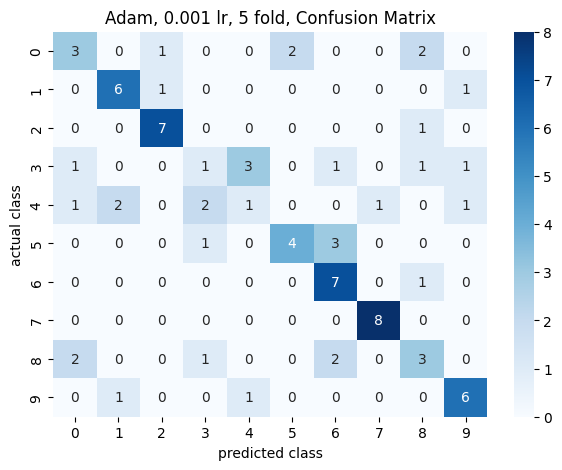

Adam, 0.001 lr, 5 fold, Overall F1 Score: 0.549725813402284


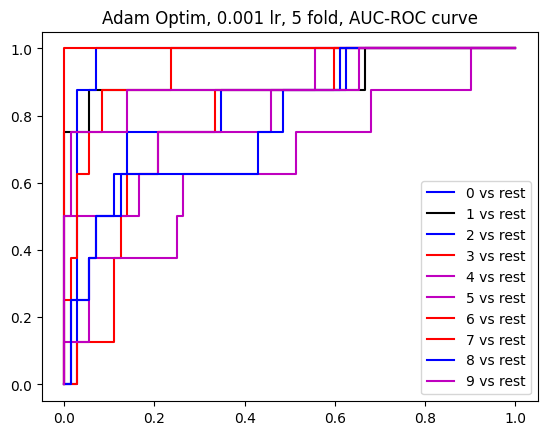

Adam, 0.001 lr, Mean validation accuracy: 56.875
Adam, 0.001 lr, Best test accuracy: 57.5


100%|██████████| 80/80 [00:00<00:00, 16606.17it/s]


Adam, 0.05 lr, 2 fold, Epoch 10/100, Training Loss: 2.35568168759346, Training Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 10/100, Validation Loss: 2.3674000898996987, Validation Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 20/100, Training Loss: 2.3517757654190063, Training Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 20/100, Validation Loss: 2.367400805155436, Validation Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 30/100, Training Loss: 2.367400735616684, Training Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 30/100, Validation Loss: 2.367400805155436, Validation Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 40/100, Training Loss: 2.359588176012039, Training Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 40/100, Validation Loss: 2.367400805155436, Validation Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 50/100, Training Loss: 2.363494485616684, Training Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 50/100, Validation Loss: 2.367400805155436, Validation Accuracy: 10.0
Adam, 0.05 lr, 2 fold, Epoch 

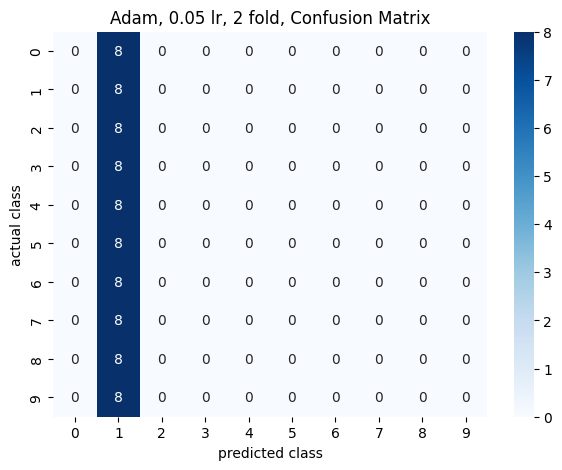

Adam, 0.05 lr, 2 fold, Overall F1 Score: 0.01818181818181818


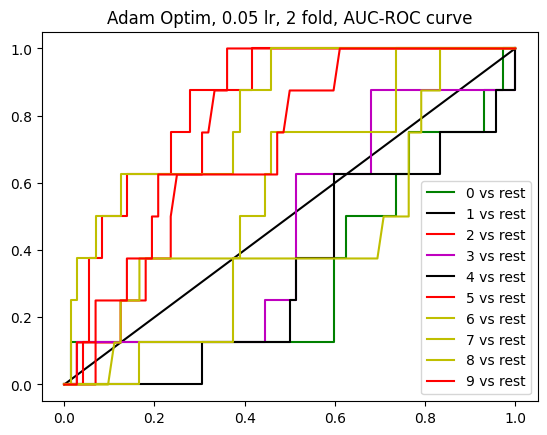

100%|██████████| 80/80 [00:00<00:00, 15892.03it/s]


Adam, 0.05 lr, 3 fold, Epoch 10/100, Training Loss: 2.327517092227936, Training Accuracy: 8.75
Adam, 0.05 lr, 3 fold, Epoch 10/100, Validation Loss: 2.3241195678710938, Validation Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 20/100, Training Loss: 2.362499088048935, Training Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 20/100, Validation Loss: 2.3778088887532554, Validation Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 30/100, Training Loss: 2.367400735616684, Training Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 30/100, Validation Loss: 2.377817471822103, Validation Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 40/100, Training Loss: 2.3595882654190063, Training Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 40/100, Validation Loss: 2.377817471822103, Validation Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 50/100, Training Loss: 2.363494485616684, Training Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoch 50/100, Validation Loss: 2.377817471822103, Validation Accuracy: 10.0
Adam, 0.05 lr, 3 fold, Epoc

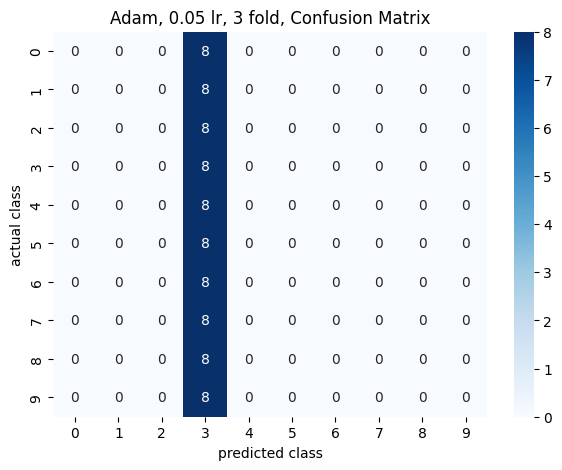

Adam, 0.05 lr, 3 fold, Overall F1 Score: 0.01818181818181818


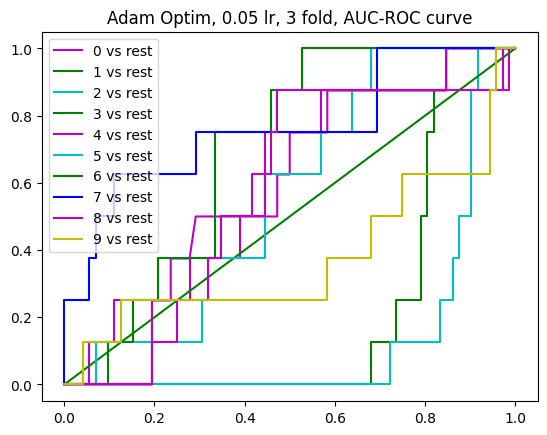

100%|██████████| 80/80 [00:00<00:00, 17534.72it/s]


Adam, 0.05 lr, 4 fold, Epoch 10/100, Training Loss: 2.3634946048259735, Training Accuracy: 10.0
Adam, 0.05 lr, 4 fold, Epoch 10/100, Validation Loss: 2.367400805155436, Validation Accuracy: 10.0
Adam, 0.05 lr, 4 fold, Epoch 20/100, Training Loss: 2.3634946048259735, Training Accuracy: 10.0
Adam, 0.05 lr, 4 fold, Epoch 20/100, Validation Loss: 2.367400805155436, Validation Accuracy: 10.0
Adam, 0.05 lr, 4 fold, Epoch 30/100, Training Loss: 2.3674008548259735, Training Accuracy: 10.0
Adam, 0.05 lr, 4 fold, Epoch 30/100, Validation Loss: 2.367400805155436, Validation Accuracy: 10.0
Adam, 0.05 lr, 4 fold, Epoch 40/100, Training Loss: 2.3674008548259735, Training Accuracy: 10.0
Adam, 0.05 lr, 4 fold, Epoch 40/100, Validation Loss: 2.367400805155436, Validation Accuracy: 10.0
Adam, 0.05 lr, 4 fold, Epoch 50/100, Training Loss: 2.3556821048259735, Training Accuracy: 10.0
Adam, 0.05 lr, 4 fold, Epoch 50/100, Validation Loss: 2.367400805155436, Validation Accuracy: 10.0
Adam, 0.05 lr, 4 fold, Ep

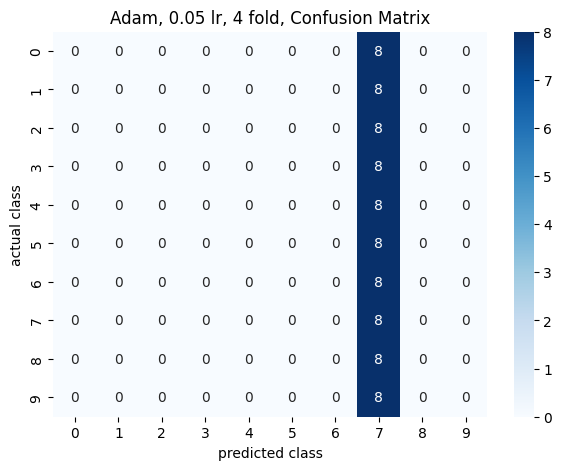

Adam, 0.05 lr, 4 fold, Overall F1 Score: 0.01818181818181818


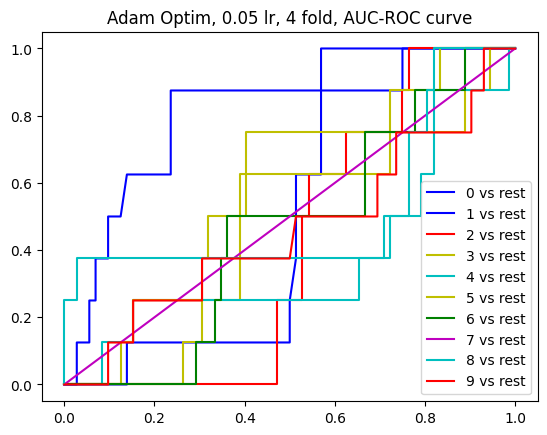

100%|██████████| 80/80 [00:00<00:00, 17027.52it/s]


Adam, 0.05 lr, 5 fold, Epoch 10/100, Training Loss: 2.359588146209717, Training Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 10/100, Validation Loss: 2.377816836039225, Validation Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 20/100, Training Loss: 2.367400348186493, Training Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 20/100, Validation Loss: 2.377816836039225, Validation Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 30/100, Training Loss: 2.3634938299655914, Training Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 30/100, Validation Loss: 2.377816597620646, Validation Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 40/100, Training Loss: 2.3595875203609467, Training Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 40/100, Validation Loss: 2.3778164386749268, Validation Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 50/100, Training Loss: 2.367398887872696, Training Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epoch 50/100, Validation Loss: 2.3778152465820312, Validation Accuracy: 10.0
Adam, 0.05 lr, 5 fold, Epo

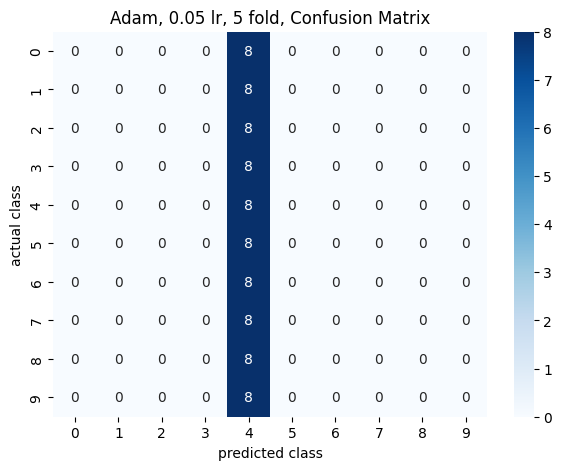

Adam, 0.05 lr, 5 fold, Overall F1 Score: 0.01818181818181818


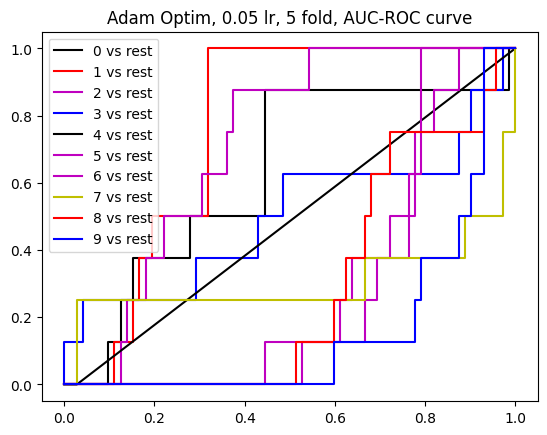

Adam, 0.05 lr, Mean validation accuracy: 10.0
Adam, 0.05 lr, Best test accuracy: 10.0


100%|██████████| 80/80 [00:00<00:00, 15839.52it/s]


SGD, 0.001 lr, 2 fold, Epoch 10/100, Training Loss: 2.3030031621456146, Training Accuracy: 12.5
SGD, 0.001 lr, 2 fold, Epoch 10/100, Validation Loss: 2.3011138439178467, Validation Accuracy: 13.75
SGD, 0.001 lr, 2 fold, Epoch 20/100, Training Loss: 2.3044537901878357, Training Accuracy: 13.333333333333334
SGD, 0.001 lr, 2 fold, Epoch 20/100, Validation Loss: 2.300970713297526, Validation Accuracy: 13.75
SGD, 0.001 lr, 2 fold, Epoch 30/100, Training Loss: 2.30325648188591, Training Accuracy: 13.333333333333334
SGD, 0.001 lr, 2 fold, Epoch 30/100, Validation Loss: 2.3008744716644287, Validation Accuracy: 13.75
SGD, 0.001 lr, 2 fold, Epoch 40/100, Training Loss: 2.3035761415958405, Training Accuracy: 14.583333333333334
SGD, 0.001 lr, 2 fold, Epoch 40/100, Validation Loss: 2.300729433695475, Validation Accuracy: 13.75
SGD, 0.001 lr, 2 fold, Epoch 50/100, Training Loss: 2.3032925724983215, Training Accuracy: 14.166666666666666
SGD, 0.001 lr, 2 fold, Epoch 50/100, Validation Loss: 2.30051906

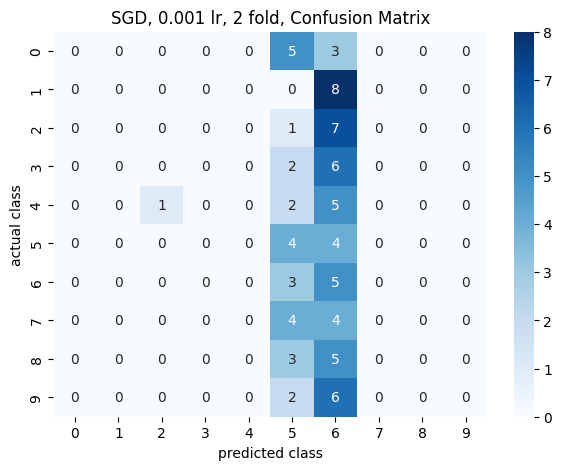

SGD, 0.001 lr, 2 fold, Overall F1 Score: 0.039922854387656706


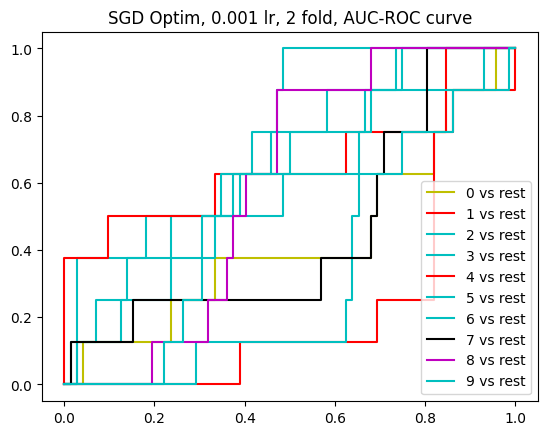

100%|██████████| 80/80 [00:00<00:00, 17265.84it/s]


SGD, 0.001 lr, 3 fold, Epoch 10/100, Training Loss: 2.299320310354233, Training Accuracy: 10.0
SGD, 0.001 lr, 3 fold, Epoch 10/100, Validation Loss: 2.3010145823160806, Validation Accuracy: 11.25
SGD, 0.001 lr, 3 fold, Epoch 20/100, Training Loss: 2.298650413751602, Training Accuracy: 10.833333333333334
SGD, 0.001 lr, 3 fold, Epoch 20/100, Validation Loss: 2.300442934036255, Validation Accuracy: 11.25
SGD, 0.001 lr, 3 fold, Epoch 30/100, Training Loss: 2.299136698246002, Training Accuracy: 10.833333333333334
SGD, 0.001 lr, 3 fold, Epoch 30/100, Validation Loss: 2.300075054168701, Validation Accuracy: 11.25
SGD, 0.001 lr, 3 fold, Epoch 40/100, Training Loss: 2.2983417212963104, Training Accuracy: 11.25
SGD, 0.001 lr, 3 fold, Epoch 40/100, Validation Loss: 2.299627145131429, Validation Accuracy: 11.25
SGD, 0.001 lr, 3 fold, Epoch 50/100, Training Loss: 2.2978864908218384, Training Accuracy: 11.25
SGD, 0.001 lr, 3 fold, Epoch 50/100, Validation Loss: 2.2991604010264077, Validation Accurac

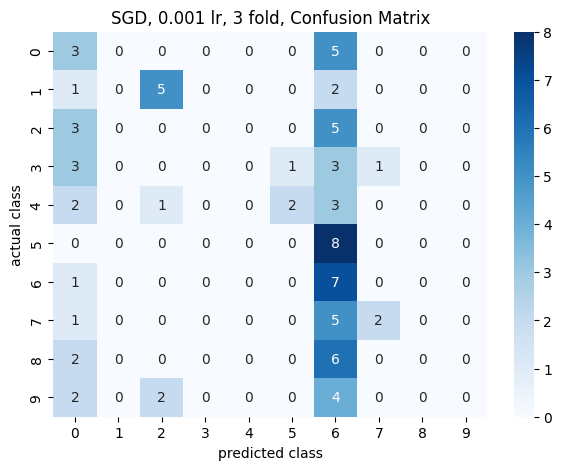

SGD, 0.001 lr, 3 fold, Overall F1 Score: 0.08444055944055946


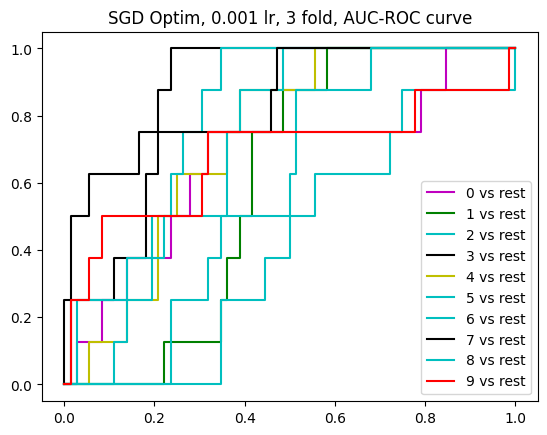

100%|██████████| 80/80 [00:00<00:00, 17475.36it/s]


SGD, 0.001 lr, 4 fold, Epoch 10/100, Training Loss: 2.3036803007125854, Training Accuracy: 7.916666666666667
SGD, 0.001 lr, 4 fold, Epoch 10/100, Validation Loss: 2.305898586908976, Validation Accuracy: 8.75
SGD, 0.001 lr, 4 fold, Epoch 20/100, Training Loss: 2.301781862974167, Training Accuracy: 10.0
SGD, 0.001 lr, 4 fold, Epoch 20/100, Validation Loss: 2.3056227366129556, Validation Accuracy: 8.75
SGD, 0.001 lr, 4 fold, Epoch 30/100, Training Loss: 2.303023785352707, Training Accuracy: 9.166666666666666
SGD, 0.001 lr, 4 fold, Epoch 30/100, Validation Loss: 2.3052866458892822, Validation Accuracy: 8.75
SGD, 0.001 lr, 4 fold, Epoch 40/100, Training Loss: 2.300899177789688, Training Accuracy: 10.0
SGD, 0.001 lr, 4 fold, Epoch 40/100, Validation Loss: 2.3049784501393638, Validation Accuracy: 8.75
SGD, 0.001 lr, 4 fold, Epoch 50/100, Training Loss: 2.301468461751938, Training Accuracy: 10.833333333333334
SGD, 0.001 lr, 4 fold, Epoch 50/100, Validation Loss: 2.304682493209839, Validation A

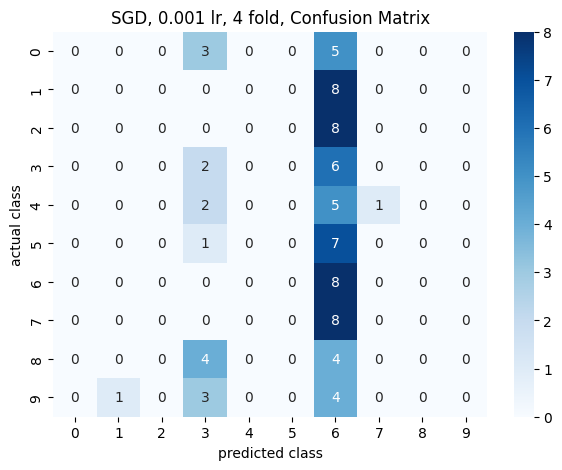

SGD, 0.001 lr, 4 fold, Overall F1 Score: 0.03992651561543172


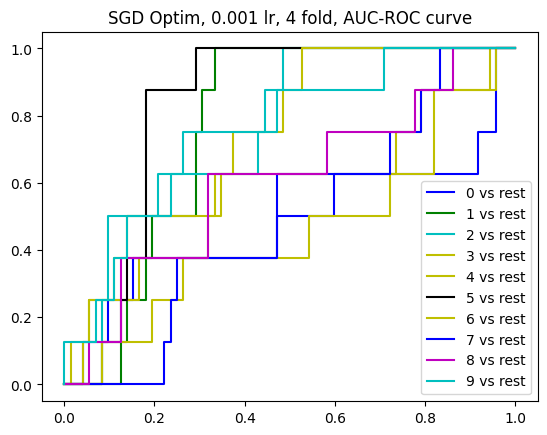

100%|██████████| 80/80 [00:00<00:00, 15379.95it/s]


SGD, 0.001 lr, 5 fold, Epoch 10/100, Training Loss: 2.305247515439987, Training Accuracy: 7.5
SGD, 0.001 lr, 5 fold, Epoch 10/100, Validation Loss: 2.298553943634033, Validation Accuracy: 8.75
SGD, 0.001 lr, 5 fold, Epoch 20/100, Training Loss: 2.3048664331436157, Training Accuracy: 6.666666666666667
SGD, 0.001 lr, 5 fold, Epoch 20/100, Validation Loss: 2.2979928652445474, Validation Accuracy: 10.0
SGD, 0.001 lr, 5 fold, Epoch 30/100, Training Loss: 2.3040827214717865, Training Accuracy: 9.583333333333334
SGD, 0.001 lr, 5 fold, Epoch 30/100, Validation Loss: 2.297744353612264, Validation Accuracy: 10.0
SGD, 0.001 lr, 5 fold, Epoch 40/100, Training Loss: 2.3023541271686554, Training Accuracy: 10.833333333333334
SGD, 0.001 lr, 5 fold, Epoch 40/100, Validation Loss: 2.2973287105560303, Validation Accuracy: 8.75
SGD, 0.001 lr, 5 fold, Epoch 50/100, Training Loss: 2.3030668795108795, Training Accuracy: 12.916666666666666
SGD, 0.001 lr, 5 fold, Epoch 50/100, Validation Loss: 2.29680021603902

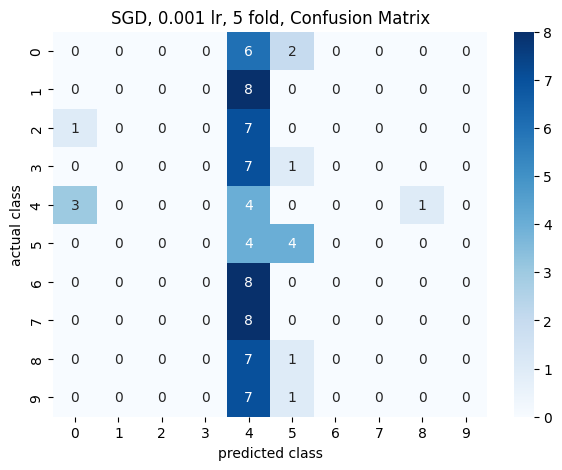

SGD, 0.001 lr, 5 fold, Overall F1 Score: 0.057869634340222575


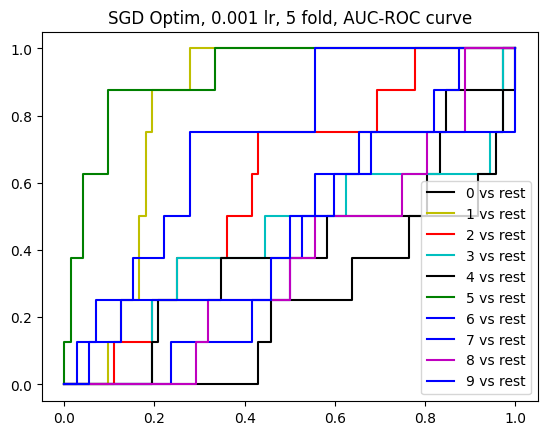

SGD, 0.001 lr, Mean validation accuracy: 16.25
SGD, 0.001 lr, Best test accuracy: 15.0


100%|██████████| 80/80 [00:00<00:00, 17327.36it/s]


SGD, 0.05 lr, 2 fold, Epoch 10/100, Training Loss: 2.2135405838489532, Training Accuracy: 25.0
SGD, 0.05 lr, 2 fold, Epoch 10/100, Validation Loss: 2.2061804930369058, Validation Accuracy: 31.25
SGD, 0.05 lr, 2 fold, Epoch 20/100, Training Loss: 2.1358595192432404, Training Accuracy: 36.666666666666664
SGD, 0.05 lr, 2 fold, Epoch 20/100, Validation Loss: 2.1261181831359863, Validation Accuracy: 32.5
SGD, 0.05 lr, 2 fold, Epoch 30/100, Training Loss: 2.090904653072357, Training Accuracy: 41.25
SGD, 0.05 lr, 2 fold, Epoch 30/100, Validation Loss: 2.1374851067860923, Validation Accuracy: 25.0
SGD, 0.05 lr, 2 fold, Epoch 40/100, Training Loss: 2.037046790122986, Training Accuracy: 46.666666666666664
SGD, 0.05 lr, 2 fold, Epoch 40/100, Validation Loss: 2.109156052271525, Validation Accuracy: 38.75
SGD, 0.05 lr, 2 fold, Epoch 50/100, Training Loss: 2.003793880343437, Training Accuracy: 49.166666666666664
SGD, 0.05 lr, 2 fold, Epoch 50/100, Validation Loss: 2.1517585118611655, Validation Accu

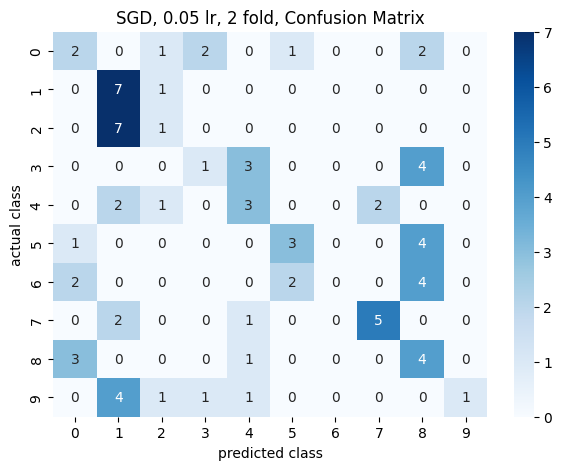

SGD, 0.05 lr, 2 fold, Overall F1 Score: 0.30152732888027006


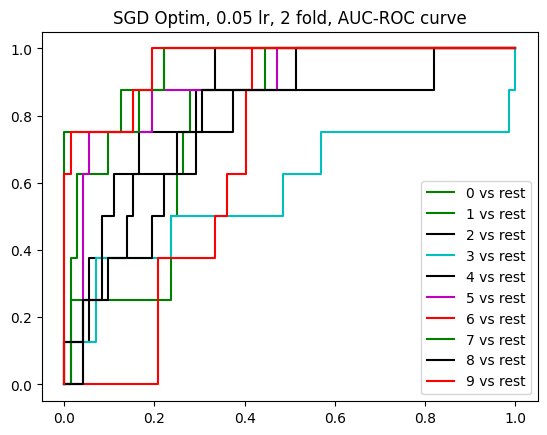

100%|██████████| 80/80 [00:00<00:00, 15841.01it/s]


SGD, 0.05 lr, 3 fold, Epoch 10/100, Training Loss: 2.224331319332123, Training Accuracy: 23.333333333333332
SGD, 0.05 lr, 3 fold, Epoch 10/100, Validation Loss: 2.1864260037740073, Validation Accuracy: 27.5
SGD, 0.05 lr, 3 fold, Epoch 20/100, Training Loss: 2.091764599084854, Training Accuracy: 39.583333333333336
SGD, 0.05 lr, 3 fold, Epoch 20/100, Validation Loss: 2.121415456136068, Validation Accuracy: 33.75
SGD, 0.05 lr, 3 fold, Epoch 30/100, Training Loss: 2.053394079208374, Training Accuracy: 45.833333333333336
SGD, 0.05 lr, 3 fold, Epoch 30/100, Validation Loss: 2.120401938756307, Validation Accuracy: 35.0
SGD, 0.05 lr, 3 fold, Epoch 40/100, Training Loss: 1.9937411546707153, Training Accuracy: 50.833333333333336
SGD, 0.05 lr, 3 fold, Epoch 40/100, Validation Loss: 2.094078024228414, Validation Accuracy: 35.0
SGD, 0.05 lr, 3 fold, Epoch 50/100, Training Loss: 1.943643718957901, Training Accuracy: 53.75
SGD, 0.05 lr, 3 fold, Epoch 50/100, Validation Loss: 2.078769087791443, Valida

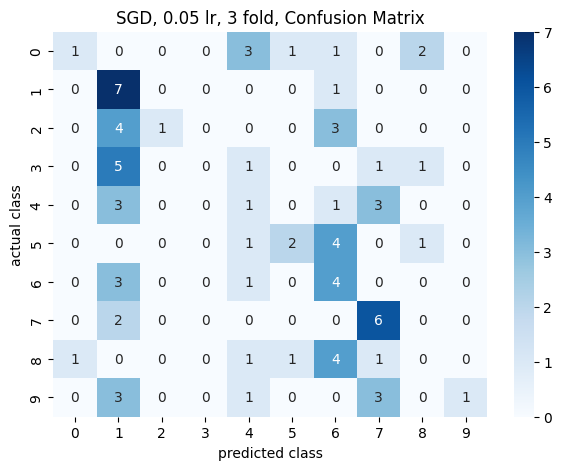

SGD, 0.05 lr, 3 fold, Overall F1 Score: 0.23485716897481607


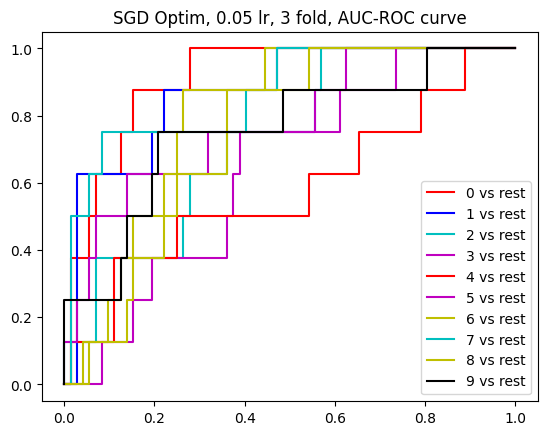

100%|██████████| 80/80 [00:00<00:00, 16720.37it/s]


SGD, 0.05 lr, 4 fold, Epoch 10/100, Training Loss: 2.183712273836136, Training Accuracy: 29.166666666666668
SGD, 0.05 lr, 4 fold, Epoch 10/100, Validation Loss: 2.216155687967936, Validation Accuracy: 28.75
SGD, 0.05 lr, 4 fold, Epoch 20/100, Training Loss: 2.0940202176570892, Training Accuracy: 41.666666666666664
SGD, 0.05 lr, 4 fold, Epoch 20/100, Validation Loss: 2.138430595397949, Validation Accuracy: 35.0
SGD, 0.05 lr, 4 fold, Epoch 30/100, Training Loss: 2.030050367116928, Training Accuracy: 48.75
SGD, 0.05 lr, 4 fold, Epoch 30/100, Validation Loss: 2.1044209798177085, Validation Accuracy: 36.25
SGD, 0.05 lr, 4 fold, Epoch 40/100, Training Loss: 1.9616429805755615, Training Accuracy: 58.75
SGD, 0.05 lr, 4 fold, Epoch 40/100, Validation Loss: 2.079838991165161, Validation Accuracy: 38.75
SGD, 0.05 lr, 4 fold, Epoch 50/100, Training Loss: 1.919708713889122, Training Accuracy: 61.25
SGD, 0.05 lr, 4 fold, Epoch 50/100, Validation Loss: 2.1198004881540933, Validation Accuracy: 33.75
S

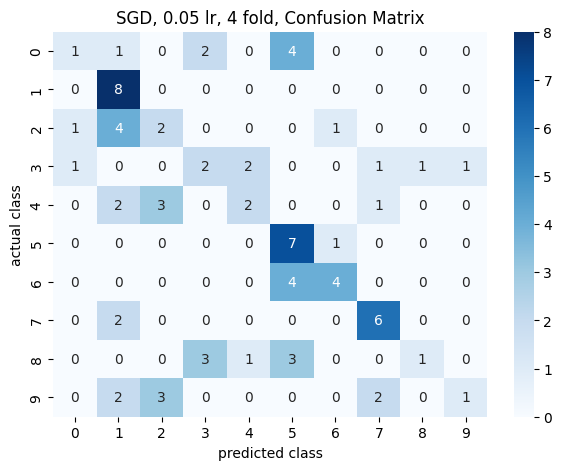

SGD, 0.05 lr, 4 fold, Overall F1 Score: 0.3775326525326526


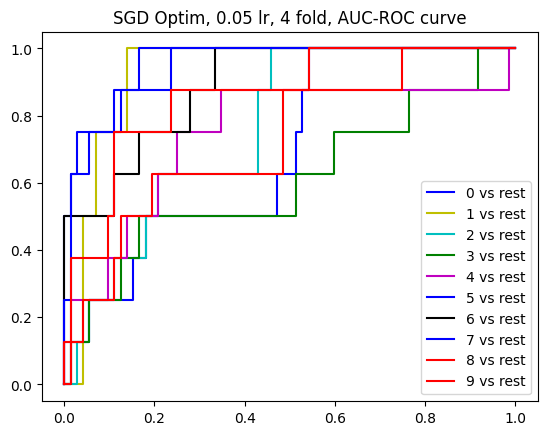

100%|██████████| 80/80 [00:00<00:00, 17225.07it/s]


SGD, 0.05 lr, 5 fold, Epoch 10/100, Training Loss: 2.2118456959724426, Training Accuracy: 29.166666666666668
SGD, 0.05 lr, 5 fold, Epoch 10/100, Validation Loss: 2.2132972876230874, Validation Accuracy: 23.75
SGD, 0.05 lr, 5 fold, Epoch 20/100, Training Loss: 2.1034690886735916, Training Accuracy: 38.75
SGD, 0.05 lr, 5 fold, Epoch 20/100, Validation Loss: 2.138098398844401, Validation Accuracy: 28.75
SGD, 0.05 lr, 5 fold, Epoch 30/100, Training Loss: 2.0416122674942017, Training Accuracy: 46.666666666666664
SGD, 0.05 lr, 5 fold, Epoch 30/100, Validation Loss: 2.1330296993255615, Validation Accuracy: 33.75
SGD, 0.05 lr, 5 fold, Epoch 40/100, Training Loss: 1.991239070892334, Training Accuracy: 52.5
SGD, 0.05 lr, 5 fold, Epoch 40/100, Validation Loss: 2.07336954275767, Validation Accuracy: 35.0
SGD, 0.05 lr, 5 fold, Epoch 50/100, Training Loss: 1.9674972146749496, Training Accuracy: 55.416666666666664
SGD, 0.05 lr, 5 fold, Epoch 50/100, Validation Loss: 2.0730415185292563, Validation Acc

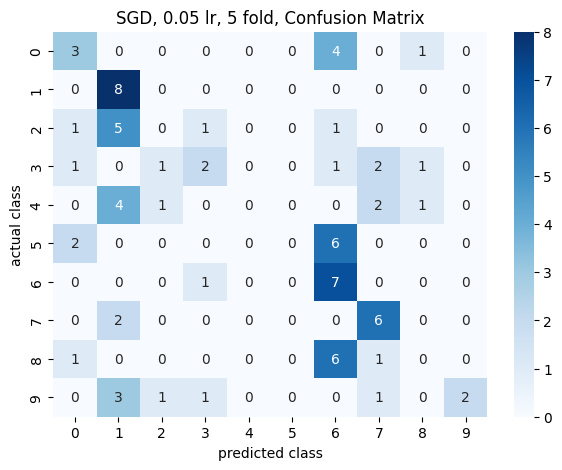

SGD, 0.05 lr, 5 fold, Overall F1 Score: 0.2640268065268065


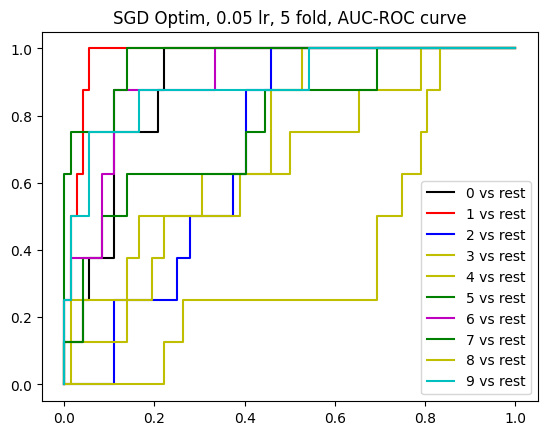

SGD, 0.05 lr, Mean validation accuracy: 37.1875
SGD, 0.05 lr, Best test accuracy: 42.5


In [37]:
for optimizer_type in optimizers:
    for lr_type in learning_rates:

        all_test_accuracy = []
        all_validation_accuracy = []
        valid_samples = [2,3,4,5]

        for i in valid_samples:
            # Data Setup
            test_samp = 1 #Do not change this!!
            valid_samp = i # Use any value ranging from 2 to 5 for k-fold validation (valid_fold)
            batch_size = 32 # Free to change
            num_workers = 2 # Free to change
            custom_data_module = CustomDataModule(batch_size=batch_size,
                                                num_workers=num_workers,
                                                data_directory=path,
                                                data_frame=df,
                                                validation_fold=valid_samp,
                                                testing_fold=test_samp,  # set to 0 for no test set
                                                esc_10_flag=True,
                                                file_column='filename',
                                                label_column='category',
                                                sampling_rate=44100,
                                                new_sampling_rate=16000,  # new sample rate for input
                                                sample_length_seconds=1  # new length of input in seconds
                                                )

            custom_data_module.setup()

            # Hyperparameters
            num_classes = 10
            lr = lr_type
            epochs = 100
            # Model, Optimizer, Loss function
            model2 = Architecture2().to(device)
            # model2 = Architecture2()
            # optimizer = optim.Adam(model2.parameters(), lr=lr)
            if optimizer_type == 'Adam':
                optimizer = optim.Adam(model2.parameters(), lr=lr)
            elif optimizer_type == 'SGD':
                optimizer = optim.SGD(model2.parameters(), lr=lr)

            criterion = nn.CrossEntropyLoss()

            # WandB initialization
            wandb.init(project="Architecture2_model2_Head4_final_light", name=f"{optimizer_type}, {lr} lr, {i} fold")

            # Training loop
            train_acc_track = []
            val_acc_track = []
            train_loss_track = []
            val_loss_track = []

            for epoch in range(epochs):
                model2.train()
                running_loss = 0.0
                correct = 0
                total = 0

                for data, target in custom_data_module.train_dataloader():
                    data, target = data.to(device), target.to(device)
                    optimizer.zero_grad()
                    output = model2(data)
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()
                    _, predicted = output.max(1)

                    total += target.size(0)
                    correct += predicted.eq(target).sum().item()

                train_loss = running_loss / len(custom_data_module.train_dataloader())
                train_acc = 100. * correct / total

                train_loss_track.append(train_loss)
                train_acc_track.append(train_acc)

                if (epoch+1) % 10 == 0:
                    print(f'{optimizer_type}, {lr} lr, {i} fold, Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Training Accuracy: {train_acc}')
                # print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Training Accuracy: {train_acc}')

                # Validation
                model2.eval()
                val_loss = 0.0
                val_correct = 0
                val_total = 0

                with torch.no_grad():
                    for data, target in custom_data_module.val_dataloader():
                        data, target = data.to(device), target.to(device)
                        output = model2(data)
                        loss = criterion(output, target)
                        val_loss += loss.item()
                        _, predicted = output.max(1)

                        val_total += target.size(0)
                        val_correct += predicted.eq(target).sum().item()

                val_loss /= len(custom_data_module.val_dataloader())
                val_acc = 100. * val_correct / val_total

                val_loss_track.append(val_loss)
                val_acc_track.append(val_acc)

                if (epoch+1) % 10 == 0:
                    print(f'{optimizer_type}, {lr} lr, {i} fold, Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')
                # print(f'Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

                # # Logging
                wandb.log({"Train Loss": train_loss, "Train Accuracy": train_acc, "Validation Loss": val_loss, "Val Accuracy": val_acc, "Learning rate": lr, "Optimizer": optimizer_type})


            all_validation_accuracy.append(val_acc)

            # Testing
            model2.eval()
            test_correct = 0
            test_total = 0
            all_labels_test = []
            all_preds_test = []
            all_probabilities = []

            with torch.no_grad():
                for data, target in custom_data_module.test_dataloader():
                    data, target = data.to(device), target.to(device)
                    output = model2(data)
                    all_probabilities.extend(output.cpu().numpy())
                    _, predicted = output.max(1)
                    test_total += target.size(0)
                    test_correct += predicted.eq(target).sum().item()
                    all_labels_test.extend(target.cpu().numpy())
                    all_preds_test.extend(predicted.cpu().numpy())

            test_acc = 100. * test_correct / test_total
            print(f'{optimizer_type}, {lr} lr, {i} fold, Test Accuracy: {test_acc:.2f}%')
            # print(f'Test Accuracy: {test_acc:.2f}%')
            all_test_accuracy.append(test_acc)

            # Confusion Matrix for test set
            cm = confusion_matrix(all_labels_test, all_preds_test)
            plt.figure(figsize=(7, 5))
            sns.heatmap(cm, annot=True,fmt = 'd', cmap='Blues')
            plt.title(f'{optimizer_type}, {lr} lr, {i} fold, Confusion Matrix')
            # plt.title(f'Confusion Matrix')
            plt.xlabel("predicted class",size=10)
            plt.ylabel("actual class",size=10)
            # plt.show()

            # # Confusion Matrix
            # cm = wandb.plot.confusion_matrix(
            #     y_true = all_labels_test, preds = all_preds_test
            # )
            wandb.log({"Confusion Matrix": wandb.Image(plt)})
            plt.show()

            # Calculate overall F1 score
            overall_f1_score = f1_score(all_labels_test, all_preds_test, average='weighted')

            # print(f'Overall F1 Score: {overall_f1_score}')
            print(f'{optimizer_type}, {lr} lr, {i} fold, Overall F1 Score: {overall_f1_score}')

            wandb.summary["F1 score"] = overall_f1_score

            # roc curve for classes
            fpr = {}
            tpr = {}
            thresh ={}
            n_class = 10

            for j in range(n_class):
                fpr[j], tpr[j], thresh[j] = roc_curve(all_labels_test, np.array(all_probabilities)[:,j], pos_label=j)
                plt.plot(fpr[j], tpr[j], label = f'{j} vs rest',color = np.random.choice(['r','g','b','y','c','m','k']))
            plt.legend()
            # plt.title("AUC-ROC curve")
            plt.title(f'{optimizer_type} Optim, {lr} lr, {i} fold, AUC-ROC curve')


            # # roc curve for classes
            # roc_curves = {}
            # n_class = 10  # Assuming you have 10 classes, adjust accordingly

            # for j in range(n_class):
            #     fpr[j], tpr[j], _ = roc_curve(all_labels_test, np.array(all_probabilities)[:, j], pos_label=j)
            #     roc_curves[j] = {"fpr": fpr[j], "tpr": tpr[j]}

            wandb.log({"ROC curve": wandb.Image(plt)})
            plt.show()

            wandb.summary["Test accuracy"] = test_acc
            wandb.finish()

        print(f'{optimizer_type}, {lr} lr, Mean validation accuracy: {mean(all_validation_accuracy)}')
        print(f'{optimizer_type}, {lr} lr, Best test accuracy: {max(all_test_accuracy)}')

In [38]:
def numel(model2: torch.nn.Module, only_trainable: bool = False):

    parameters = list(model2.parameters())
    if only_trainable:
        parameters = [p for p in parameters if p.requires_grad]
    unique = {p.data_ptr(): p for p in parameters}.values()
    return sum(p.numel() for p in unique)

numel(model2,only_trainable=True),numel(model2,only_trainable=False)-numel(model2,only_trainable=True)

(98730, 0)